# 0. Import

In [5]:
import os, sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from PIL import Image
import numpy as np
import matplotlib
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import fnmatch
from scipy.misc import bytescale
pixel_size = 20
frame_num = 300
from skimage.measure import profile_line
sys.path.append('..')
from utils.plot_image import (zoom_line, zoom, scalebar, plot_image1, align_image, outputs_shareloc)
from utils.msssim import MultiScaleSSIM

# 1. functions for plotting data

In [2]:
def zoom_line(image, lim, line, c ='y',zoom=3, loc=2, loc1=2, loc2=4, **kwargs):
    # --------
    ax = plt.gca()
    axins = zoomed_inset_axes(ax, zoom, loc=loc) # zoom = 6
    x0,y0,x1,y1 = line
    axins.imshow(image, interpolation="nearest",
          origin="lower", **kwargs)
    plt.plot([x0, x1], [y0, y1], '{}-'.format(c),linewidth=5*zoom,alpha = 1)
    plt.plot([x0, x1], [y0, y1], '{}-'.format(c),linewidth=1*zoom)
    plt.arrow(x0, y0, (x1-x0), (y1-y0), fc='y', ec='y',head_width=zoom)
    #scalebar(scale_factor=100/pixel_size,down_scale=2)
    # sub region of the original image
    x1, y1, x2, y2 = lim
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)

    # draw a bbox of the region of the inset axes in the parent axes and
    # connecting lines between the bbox and the inset axes area
    mark_inset(ax, axins, loc1=loc1, loc2=loc2, fc="none", ec="0.8", lw=2)

In [22]:
def zoom(image, lim, zoom=3, loc=2, loc1=2, loc2=4, f=1,**kwargs):
    # --------
    ax = plt.gca()
    axins = zoomed_inset_axes(ax, zoom, loc=loc) # zoom = 6
    print(np.shape(image))
    axins.imshow(image, interpolation="nearest",
          origin="lower", **kwargs)
    #scalebar(scale_factor=100/pixel_size/f,down_scale=2*f)
    # sub region of the original image
    x1, y1, x2, y2 = lim
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)

    # draw a bbox of the region of the inset axes in the parent axes and
    # connecting lines between the bbox and the inset axes area
    mark_inset(ax, axins, loc1=loc1, loc2=loc2, fc="none", ec="0.8", lw=2)

In [23]:
def scalebar(scale_factor=500/pixel_size, down_scale=1):
    ax = plt.gca()
    fontprops = fm.FontProperties(size=30)
    asb = AnchoredSizeBar(ax.transData,
                          scale_factor,
                          "",#r"500nm",
                          loc=3,
                          color=u'white',
                          size_vertical= 2.0/down_scale,
                          pad=0.1, borderpad=0.8, sep=5,
                          fontproperties=fontprops,
                          frameon=False)
    ax.add_artist(asb)

In [35]:
def plot_image1(zoom_lim = (150, 180, 190, 220), 
                line = (215,200, 255,240),
                add_title=True, save_fig=False, show_zoom=True,
                savedir = "figs",
                name = 'ANNA-PALM_model',
                title_c = 'Merged,trained on IMOD', 
                title_d = 'Merged,trained on 3Labs'):
    print('ploting')
    (wf, histin, gt, Merged_c, Merged_d,Reco_c,Reco_d) = __data['results_images']
    zoom_rate = 4 #10  #4
    font_size = 45
    loc1=4  #4
    loc2=2  #2
    loc=1   #1
    fontsize=45
    zoomsize = 50
    
    #x0 = 210+5#60
    #y0 = 195+5#20
    #x1 = 210-5+zoomsize#350
    #y1 = 195-5+zoomsize#350
    x0,y0,x1,y1 = line
    plt.figure(figsize=(40, 40))
    gs = gridspec.GridSpec(2,2)
    gs.update(wspace=0.02, hspace=0.02) # set the spacing between axes.
    matplotlib.rc('axes',edgecolor='w',linewidth=5)

    #-------------input-target---------------
    FigSize = 20
    #plt.subplot(gs[0])
    plt.figure(figsize=(FigSize,FigSize))
    plt.axis('off')
    plt.imshow(wf,  interpolation="nearest",
              origin="lower", cmap='gray', vmin=0)
    if add_title:
        plt.title('a. wide-field', fontsize=fontsize)
    scalebar(scale_factor=1000/pixel_size/4,down_scale=2)
    if show_zoom:
        zoom(wf, list(np.array(zoom_lim)//4), zoom_rate, loc=loc, loc1=loc1, loc2=loc2, f=4, 
             cmap='gray', vmin=0)
    if save_fig:
        from datetime import date
        today = str(date.today()).replace("-", "_")       
        if not os.path.exists('../Shareloc/{}/'.format(savedir)):
            os.makedirs('../Shareloc/{}/'.format(savedir))
        plt.savefig('../Shareloc/{}/WF_{}_{}_{}.svg'.format(savedir,name, zoom_lim,today),
                    transparent=False)


#     if histin.max() >= 10/255:
#         histin = exposure.equalize_hist(histin)
#         vmax_in = None
#     else:
    vmax_in = 3/255

    #plt.subplot(gs[1])
    plt.figure(figsize=(FigSize,FigSize))
    #
    plt.axis('off')
    scalebar(scale_factor=1000/pixel_size,down_scale=0.5)
    plt.imshow(histin,
               origin="lower", cmap='hot', vmin=0, vmax=vmax_in)
    if add_title:
        plt.title('b. PALM(k={})'.format(frame_num), fontsize=fontsize)
    if show_zoom:
        zoom(histin, zoom_lim, zoom_rate, loc=loc, loc1=loc1, loc2=loc2, cmap='hot', vmin=0, vmax=vmax_in)
    if save_fig:
        plt.savefig('../Shareloc/{}/histin_{}_{}_{}.svg'.format(savedir,name, zoom_lim,today),
                    transparent=False)
    print('b vmax:', vmax_in*255)


    #-------------merged---------------

    #ax2 = plt.subplot(gs[2])
    plt.figure(figsize=(FigSize,FigSize))
    plt.axis('off')
    plt.imshow(Merged_c,origin="lower")
    plt.plot([x0, x1], [y0, y1], 'y-',linewidth=5,alpha = 0.3)
    plt.arrow(x0, y0, (x1-x0), (y1-y0), fc='y', ec='y',head_width=4)
    if add_title:
        plt.title('c. {}'.format(title_c), fontsize=fontsize)
    #scalebar()
    scalebar(scale_factor=1000/pixel_size,down_scale=0.5)
    if show_zoom:
        #zoom(Merged_c, zoom_lim, zoom_rate, loc=loc, loc1=loc1, loc2=loc2)
        zoom_line(Merged_c,lim=zoom_lim,line=(x0,y0,x1,y1),
                  zoom=zoom_rate,loc=loc,loc1=loc1,loc2=loc2,
                  cmap='hot',vmin=0,vmax=1,c='y')
    if save_fig:
        plt.savefig('../Shareloc/{}/recobaseline_{}_{}_{}.svg'.format(savedir,name, zoom_lim,today),
                    transparent=False)


    #ax3 = plt.subplot(gs[3])
    plt.figure(figsize=(FigSize,FigSize))
    plt.axis('off')
    #scalebar()
    scalebar(scale_factor=1000/pixel_size,down_scale=0.5)
    plt.imshow(Merged_d,origin="lower")
    plt.plot([x0, x1], [y0, y1], 'y-',linewidth=5,alpha = 0.3)
    plt.arrow(x0, y0, (x1-x0), (y1-y0), fc='y', ec='y',head_width=4)
    if add_title:
        plt.title('d. {}'.format(title_d), fontsize=fontsize)
    if show_zoom:
        #zoom(Merged_d, zoom_lim, zoom_rate,loc=loc, loc1=loc1, loc2=loc2)
        zoom_line(Merged_d,lim=zoom_lim,line=(x0,y0,x1,y1),
                  zoom=zoom_rate,loc=loc,loc1=loc1,loc2=loc2,
                  cmap='hot',vmin=0,vmax=1,c='y')
    if save_fig:
        plt.savefig('../Shareloc/{}/recoD_{}_{}_{}.svg'.format(savedir,name, zoom_lim,today),
                    transparent=False)
"""
    if save_fig:
        from datetime import date
        today = str(date.today()).replace("-", "_")
        
        if not os.path.exists('../Projects/Shareloc/{}/'.format(savedir)):
            os.makedirs('../Projects/Shareloc/{}/'.format(savedir))
        # model_no = os.path.split(MODEL_DIR)[1].split('-')[0]
        # model_no = MODEL_DIR[18:-10]
        plt.savefig('../Projects/Shareloc/{}/{}frames_{}_{}_{}.svg'.format(savedir, int(frame_num),
                                                                                   name, zoom_lim,
                                                                                   today),
                    transparent=False)
        # plt.clf()"""


'\n    if save_fig:\n        from datetime import date\n        today = str(date.today()).replace("-", "_")\n        \n        if not os.path.exists(\'../Projects/Shareloc/{}/\'.format(savedir)):\n            os.makedirs(\'../Projects/Shareloc/{}/\'.format(savedir))\n        # model_no = os.path.split(MODEL_DIR)[1].split(\'-\')[0]\n        # model_no = MODEL_DIR[18:-10]\n        plt.savefig(\'../Projects/Shareloc/{}/{}frames_{}_{}_{}.svg\'.format(savedir, int(frame_num),\n                                                                                   name, zoom_lim,\n                                                                                   today),\n                    transparent=False)\n        # plt.clf()'

In [36]:
def plot_image_singelmodel(zoom_lim = (150, 180, 190, 220), add_title=True, save_fig=False, show_zoom=True, FrameNb=300, title_d = 'Merged,trained on 3Labs'):
    print('ploting')
    (wf, histin, gt, Merged_d, reco_d) = __data['results_images']
    zoom_rate = 4  #4
    font_size = 45
    loc1=4  #4
    loc2=2
    loc=1
    fontsize=45
    plt.figure(figsize=(39, 42))
    gs = gridspec.GridSpec(2,2)
    gs.update(wspace=0.01, hspace=0.08) # set the spacing between axes.
    matplotlib.rc('axes',edgecolor='w',linewidth=5)

    #-------------input-target---------------

    plt.subplot(gs[0])
    plt.axis('off')
    plt.imshow(wf,  interpolation="nearest",
              origin="lower", cmap='gray', vmin=0)
    
    if add_title:
        plt.title('a. wide-field', fontsize=fontsize)
    scalebar(scale_factor=1000/pixel_size/4)
    if show_zoom:
        zoom(wf, list(np.array(zoom_lim)//4), zoom_rate, loc=loc, loc1=loc1, loc2=loc2, cmap='gray', vmin=0)



#     if histin.max() >= 10/255:
#         histin = exposure.equalize_hist(histin)
#         vmax_in = None
#     else:
    vmax_in = 2/255

    plt.subplot(gs[1])
    plt.axis('off')
    scalebar(scale_factor=1000/pixel_size,down_scale=0.5)
    plt.imshow(bytescale(histin),interpolation="nearest",
               origin="lower", cmap='hot', vmin=0, vmax = 1)
    if add_title:
        plt.title('b. PALM(k={})'.format(FrameNb), fontsize=fontsize)
    if show_zoom:
        zoom(bytescale(histin), zoom_lim, zoom_rate, loc=loc, loc1=loc1, loc2=loc2, cmap='hot', vmin=0, vmax = 1)

    print('b vmax:', vmax_in*255)


    #-------------merged---------------

    ax2 = plt.subplot(gs[2])
    plt.axis('off')
    #plt.imshow(Merged_c,  interpolation="nearest", origin="lower")
    plt.imshow(gt, interpolation="nearest",
               origin="lower", cmap='hot', vmin=0,
               vmax=np.array(gt).max()*0.1)

    if add_title:
        plt.title('c. Ground Truth ', fontsize=50)
    #scalebar()
    scalebar(scale_factor=1000/pixel_size,down_scale=0.5)
    if show_zoom:
        zoom(gt, zoom_lim, zoom_rate, cmap='hot', loc=loc, loc1=loc1, loc2=loc2)

    ax3 = plt.subplot(gs[3])
    plt.axis('off')
    #scalebar()
    scalebar(scale_factor=1000/pixel_size,down_scale=0.5)
    plt.imshow(reco_d,interpolation="nearest",
               origin="lower", cmap='hot', vmin=0, 
               vmax=np.array(reco_d).max()*0.1)

    #plt.imshow(Merged_d,origin="lower")
    #plt.text(0,0, a[0],color=c[0],fontsize=fontsize,ha='left',transform=ax3.transAxes)
    #plt.text(0.5,0, a[1],color=c[1],fontsize=fontsize,ha='right', transform=ax3.transAxes)
    if add_title:
        plt.title('d. {}'.format(title_d), fontsize=fontsize)
    if show_zoom:
        zoom(reco_d, zoom_lim, zoom_rate, cmap='hot', 
             loc=loc, loc1=loc1, loc2=loc2)

    if save_fig:
        if not os.path.exists('./figs_out/'):
            os.makedirs('./figs_out/')
        # model_no = os.path.split(MODEL_DIR)[1].split('-')[0]
        # model_no = MODEL_DIR[18:-10]
        plt.savefig('./figs_out/{}frames_ANNA-PALM_model_{}.png'.format(int(frame_num),zoom_lim))
        # plt.clf()

In [37]:
def align_image(a, b, preprocess=False):
    import imreg_dft as ird
    if preprocess:
        b = exposure.equalize_hist(b)
        # print(b.shape)
        b = scipy.ndimage.filters.gaussian_filter(b, sigma=(4, 4))
        b = scipy.misc.imresize(b, a.shape)
    ts = ird.translation(b, a)
    tvec = ts["tvec"].round(4)
    # the Transformed IMaGe.
    a = ird.transform_img(a, tvec=tvec)
    if preprocess:
        a = scipy.misc.imresize(a, b.shape)
    return a

In [60]:
def outputs_shareloc(DirGT, DirBase_c , DirBase_d  ,
                     crop_cord=(0,0), zoom_cord=(0,0), 
                     line = (215,200, 255,240), fact=10,
                     zoomsize=50,  chopsize=2560//2, FrameNb = 300,
                     name_ind=0, add_title=True, save_fig=False, 
                     show_zoom=True,norm = True,
                     savedir = 'fig2',
                     title_c = 'Merged,trained on IMOD', 
                     title_d = 'Merged,trained on 3Labs'):

    DIR4Workspace_IMOD7 = os.listdir(DirBase_c)
    DIR4Workspace_d = os.listdir(DirBase_d)
    DIR4GT = os.listdir(DirGT)
    print(DirBase_c)
    CellName = []
    
    for name in DIR4Workspace_d:
        #print(name.split('.')[0])
        CellName.append(name.split('.')[0])
    CellName = np.unique(CellName)
    name = CellName[name_ind]
    print(CellName)
    List4GT = []
    List4Image_d =[]
    List4GT = [n for n in DIR4GT if '{}.'.format(name) in n]
    List4Image_d = [n for n in DIR4Workspace_d if '{}.'.format(name) in n]    
    FrameNbInit =List4Image_d[0].split('(')[1]
    FrameNbInit = FrameNbInit.split(',')[0]
    FrameNbInit = int(FrameNbInit)
    List4CertainRange_d =[]
    List4CertainRange_d = [n for n in List4Image_d if '({}, {})'.format(FrameNbInit,FrameNbInit+FrameNb) in n]
    #print(List4CertainRange_d)
    NameOfInput = [n for n in List4CertainRange_d if 'real_A' in n]
    if DirGT==DirBase_d : 
        #NameOfGt = [n for n in List4CertainRange_d if '_real_B_b0_' in n]
        NameOfGt = [n for n in List4CertainRange_d if '_real_B_b0_' in n]
    else : 
        NameOfGt = [n for n in List4GT if 'reco' in n]
    print(NameOfGt)
    NameOfWF= [n for n in List4CertainRange_d if 'lr_inputs_b0' in n]
    NameOfReco= [n for n in List4CertainRange_d if 'reco' in n]
    #NameOfMerged = [n for n in List4CertainRange_Mixed if 'merged' in n]
    #print(os.path.join(DirBase_c, ''.join([str(elem) for elem in NameOfInput])))
    histin = Image.open(os.path.join(DirBase_c, ''.join([str(elem) for elem in NameOfInput])))
    wf = Image.open(os.path.join(DirBase_d, ''.join([str(elem) for elem in NameOfWF])))
    #gt = Image.open(os.path.join(DirBase_c, ''.join([str(elem) for elem in NameOfGt])))
    gt = Image.open(os.path.join(DirGT, ''.join([str(elem) for elem in NameOfGt])))
    Reco_c = Image.open(os.path.join(DirBase_c, ''.join([str(elem) for elem in NameOfReco])))
    Reco_d = Image.open(os.path.join(DirBase_d, ''.join([str(elem) for elem in NameOfReco])))
    
    
    crop_x0, crop_y0 = crop_cord

    wf = np.array(wf)
    histin = np.array(histin)
    gt = np.array(gt)
    Reco_c = np.array(Reco_c)
    Reco_d = np.array(Reco_d) 
    

    wf = wf[(crop_y0//4):((crop_y0+chopsize)//4), (crop_x0//4):((crop_x0+chopsize)//4)]
    histin = histin[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]
    Reco_c = align_image(Reco_c,gt)
    Reco_d = align_image(Reco_d,gt)

    print("loc:",histin.sum(), 'total',gt.sum())
    
    #import ssim
    #cw_ssim_1 = ssim(bytescale(gt)).cw_ssim_value(bytescale(Reco_c))
    #cw_ssim_2 = ssim(bytescale(gt)).cw_ssim_value(bytescale(Reco_d))
    #print("cw_ssim_1 : ",ssim_raw_1,"cw_ssim_2 : ",ssim_raw_2)

    if norm : 
        #Merged_c = np.clip(np.stack([(Reco_c/Reco_c.sum()), 
        #                             (align_image(gt,Reco_c)/(gt.sum())), 
        #                             (Reco_c/Reco_c.sum())], axis=2)*(gt.sum())*fact, 0, 1)
        Merged_c = np.clip(np.stack([(Reco_c/Reco_c.sum()), 
                                     (gt/(gt.sum())), 
                                     (Reco_c/Reco_c.sum())], axis=2)*(gt.sum())*fact, 0, 1)
    else : 
        Merged_c = np.clip(np.stack([Reco_c, 
                                     align_image(gt,Reco_c), 
                                     Reco_c], axis=2)*fact, 0, 1)
       
    if norm : 
        Merged_d = np.clip(np.stack([(Reco_d/Reco_d.sum()), 
                                     (gt/(gt.sum())), 
                                     (Reco_d/Reco_d.sum())], axis=2)*(gt.sum())*fact, 0, 1)
    else : 
        Merged_d = np.clip(np.stack([Reco_d, 
                                     align_image(gt,Reco_d),  
                                     Reco_d], axis=2)*fact, 0, 1)

    gt = gt[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]
    Reco_c = Reco_c[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]
    Reco_d = Reco_d[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]
    Merged_c = Merged_c[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]
    Merged_d = Merged_d[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]

    print('LocNb',(np.asarray(histin).sum()))
    ssim_raw_1 = MultiScaleSSIM((Reco_c), 
                                (gt), max_val=1)
    ssim_raw_2 = MultiScaleSSIM((Reco_d), 
                                (gt), max_val=1)
    print("ssim_raw_1 : ",ssim_raw_1,"ssim_raw_2 : ",ssim_raw_2, "ssim_ra")

    
    global __data
    __data = {}
    __data['results_images'] = (wf, histin, gt, Merged_c, Merged_d, Reco_c, Reco_d)
    
    zoom_x0,zoom_y0 = zoom_cord

    plot_image1(zoom_lim = (zoom_x0, zoom_y0, zoom_x0+zoomsize, zoom_y0+zoomsize),
                line = line,
                show_zoom=show_zoom,savedir = savedir,
                title_c = title_c, title_d = title_d, 
                add_title=add_title, save_fig=save_fig, name = name)
    
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(gt, interpolation="nearest",
           origin="lower", cmap='hot',vmax=np.array(gt).max()*0.2)
    plt.title('Ground Truth : {}'.format(name), fontsize=50)
    zoom(gt, lim=(zoom_x0, zoom_y0, zoom_x0+zoomsize, zoom_y0+zoomsize), 
         zoom = 4,loc=1, loc1=4, loc2=2, cmap='hot',vmax=np.array(gt).max()*0.2)
    """
    from datetime import date
    today = str(date.today()).replace("-", "_")
    plt.savefig(
        '../Projects/Shareloc/{}/GT_{}_{}.svg'.format(
            savedir, int(frame_num),name, zoom_cord, today),
        transparent=False)
    """

In [17]:
def outputs_method(DirGT, DirBase_c , DirBase_d  ,
                     crop_cord=(0,0), zoom_cord=(0,0), 
                     line = (215,200, 255,240), fact=10,
                     zoomsize=50,  chopsize=2560//2, FrameNb = 300,
                     name_ind=0, add_title=True, save_fig=False, 
                     show_zoom=True,norm = True,
                     savedir = 'fig2',
                     title_c = 'Merged,trained on IMOD', 
                     title_d = 'Merged,trained on 3Labs'):
    bar = 1000
    DIR4Workspace_IMOD7 = os.listdir(DirBase_c)
    DIR4Workspace_d = os.listdir(DirBase_d)
    DIR4GT = os.listdir(DirGT)
    CellName = []
    zoom_rate = 4
    font_size = 45
    loc1=4  #4
    loc2=2
    loc=1
    fontsize=45
    zoomsize = 50
    zoom_x0,zoom_y0 = zoom_cord
    zoom_lim = (zoom_x0, zoom_y0, (zoom_x0+zoomsize), (zoom_y0+zoomsize))
    for name in DIR4Workspace_d:
        #print(name.split('.')[0])
        CellName.append(name.split('.')[0])
    CellName = np.unique(CellName)
    name = CellName[name_ind]
    List4GT = []
    List4Image_d =[]
    List4GT = [n for n in DIR4GT if '{}.'.format(name) in n]
    List4Image_d = [n for n in DIR4Workspace_d if '{}.'.format(name) in n]    
    FrameNbInit =List4Image_d[0].split('(')[1]
    FrameNbInit = FrameNbInit.split(',')[0]
    FrameNbInit = int(FrameNbInit)
    List4CertainRange_d =[]
    List4CertainRange_d = [n for n in List4Image_d if '({}, {})'.format(FrameNbInit,FrameNbInit+FrameNb) in n]
    #print(List4CertainRange_d)
    NameOfInput = [n for n in List4CertainRange_d if 'real_A' in n]
    if DirGT==DirBase_d : 
        #NameOfGt = [n for n in List4CertainRange_d if '_real_B_b0_' in n]
        NameOfGt = [n for n in List4CertainRange_d if '_real_B_b0_' in n]
    else : 
        NameOfGt = [n for n in List4GT if 'reco' in n]
    print(NameOfGt)
    NameOfWF= [n for n in List4CertainRange_d if 'lr_inputs_b0' in n]
    NameOfReco= [n for n in List4CertainRange_d if 'reco' in n]
    histin = Image.open(os.path.join(DirBase_c, ''.join([str(elem) for elem in NameOfInput])))
    wf = Image.open(os.path.join(DirBase_d, ''.join([str(elem) for elem in NameOfWF])))
    gt = Image.open(os.path.join(DirGT, ''.join([str(elem) for elem in NameOfGt])))
    Reco_c = Image.open(os.path.join(DirBase_c, ''.join([str(elem) for elem in NameOfReco])))
    Reco_d = Image.open(os.path.join(DirBase_d, ''.join([str(elem) for elem in NameOfReco])))
    
    print(os.path.join(DirBase_d, ''.join([str(elem) for elem in NameOfWF])))
    
    crop_x0, crop_y0 = crop_cord

    wf = np.asarray(wf)
    histin = np.asarray(histin)
    gt = np.asarray(gt)
    Reco_c = np.asarray(Reco_c)
    Reco_d = np.asarray(Reco_d) 
    
    wf = wf[(crop_y0//4):((crop_y0+chopsize)//4), (crop_x0//4):((crop_x0+chopsize)//4)]
    histin = histin[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]
    gt = gt[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]
    Reco_c = Reco_c[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]
    Reco_d = Reco_d[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]

    ssim_raw_1 = MultiScaleSSIM(Reco_c, 
                                gt, max_val=1)
    ssim_raw_2 = MultiScaleSSIM(Reco_d, 
                                gt, max_val=1)

    print("ssim_raw_1 : ",ssim_raw_1,"ssim_raw_2 : ",ssim_raw_2)

    if norm : 
        Merged_c = np.clip(np.stack([(Reco_c/Reco_c.sum()), 
                                     (align_image(gt,Reco_c)/(gt.sum())), 
                                     (Reco_c/Reco_c.sum())], axis=2)*(gt.sum())*fact, 0, 1)
    else : 
        Merged_c = np.clip(np.stack([Reco_c, 
                                     align_image(gt,Reco_c), 
                                     Reco_c], axis=2)*fact, 0, 1)
       
    if norm : 
        Merged_d = np.clip(np.stack([(Reco_d/Reco_d.sum()), 
                                     (align_image(gt,Reco_d)/(gt.sum())), 
                                     (Reco_d/Reco_d.sum())], axis=2)*(gt.sum())*fact, 0, 1)
    else : 
        Merged_d = np.clip(np.stack([Reco_d, 
                                     align_image(gt,Reco_d),  
                                     Reco_d], axis=2)*fact, 0, 1)

    print(Merged_d.max())

    global __data
    __data = {}
    __data['results_images'] = (wf, histin, gt, Merged_c, Merged_d, Reco_c, Reco_d)
    
    #------------plot---------------
    zoom_x0,zoom_y0 = zoom_cord
    x0,y0,x1,y1 = line
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    wf = plt.imshow(wf,  interpolation="nearest",
              origin="lower", cmap='gray', vmin=0)
    scalebar(scale_factor=bar/pixel_size/4,down_scale=6)
    if show_zoom:
        zoom(wf, list(np.array(zoom_lim)//4), zoom_rate, loc=loc, loc1=loc1, loc2=loc2, f=4, cmap='gray', vmin=0)
    if save_fig:
        from datetime import date
        today = str(date.today()).replace("-", "_")       
        if not os.path.exists('../Projects/Shareloc/{}/'.format(savedir)):
            os.makedirs('../Projects/Shareloc/{}/'.format(savedir))
        plt.savefig('../Projects/Shareloc/{}/WF_{}_{}_{}.svg'.format(savedir,name, zoom_cord,today),
                    transparent=False)
    vmax_in = 3/255

    plt.figure(figsize=(20, 20))
    plt.axis('off')
    scalebar(scale_factor=bar/pixel_size,down_scale=1.5)
    plt.imshow(histin,
               origin="lower", cmap='hot', vmin=0, vmax=vmax_in)
    if show_zoom:
        zoom(bytescale(histin), zoom_lim, zoom_rate, loc=loc, loc1=loc1, loc2=loc2, cmap='hot', vmin=0, vmax = 1)
    if save_fig:
        from datetime import date
        today = str(date.today()).replace("-", "_")       
        if not os.path.exists('../Projects/Shareloc/{}/'.format(savedir)):
            os.makedirs('../Projects/Shareloc/{}/'.format(savedir))
        plt.savefig('../Projects/Shareloc/{}/histin_{}_{}_{}.svg'.format(savedir,name, zoom_cord,today),
                    transparent=False)
    print('b vmax:', vmax_in*255)


    #-------------merged---------------
    plt.figure(figsize=(20, 20))
    plt.axis('off')
    plt.imshow(Merged_c,origin="lower")
    plt.plot([x0, x1], [y0, y1], 'y-',linewidth=5,alpha = 0.3)
    scalebar(scale_factor=bar/pixel_size,down_scale=1.5)
    if show_zoom:
        #zoom(Merged_d, zoom_lim, zoom_rate,loc=loc, loc1=loc1, loc2=loc2)
        zoom_line(Merged_c,lim=zoom_lim,line=(x0,y0,x1,y1),
                  zoom=zoom_rate,loc=loc,loc1=loc1,loc2=loc2,
                  cmap='hot',vmin=0,vmax=1,c='y')
    if save_fig:
        from datetime import date
        today = str(date.today()).replace("-", "_")       
        if not os.path.exists('../Projects/Shareloc/{}/'.format(savedir)):
            os.makedirs('../Projects/Shareloc/{}/'.format(savedir))
        plt.savefig('../Projects/Shareloc/{}/less_{}_{}_{}.svg'.format(savedir,name, zoom_cord,today),
                    transparent=False)

    plt.figure(figsize=(20, 20))
    plt.axis('off')
    scalebar(scale_factor=bar/pixel_size,down_scale=1.5)
    plt.imshow(Merged_d,origin="lower")
    plt.plot([x0, x1], [y0, y1], 'y-',linewidth=5,alpha = 0.3)
    if show_zoom:
        #zoom(Merged_d, zoom_lim, zoom_rate,loc=loc, loc1=loc1, loc2=loc2)
        zoom_line(Merged_d,lim=zoom_lim,line=(x0,y0,x1,y1),
                  zoom=zoom_rate,loc=loc,loc1=loc1,loc2=loc2,
                  cmap='hot',vmin=0,vmax=1,c='y')
    if save_fig:
        from datetime import date
        today = str(date.today()).replace("-", "_")       
        if not os.path.exists('../Projects/Shareloc/{}/'.format(savedir)):
            os.makedirs('../Projects/Shareloc/{}/'.format(savedir))
        plt.savefig('../Projects/Shareloc/{}/more_{}_{}_{}.svg'.format(savedir,name, zoom_cord,today),
                    transparent=False)


In [152]:
def outputs_singel_model(DirBase_d  ,crop_cord=(0,0), 
                         zoom_cord=(0,0), fact=10, zoomsize=50,  
                         chopsize=2560//2, FrameNb = 300, 
                         name_ind=0, add_title=True, save_fig=False, 
                         show_zoom=True, title_d = 'Merged,trained on 3Labs'):

    DIR4Workspace_d = os.listdir(DirBase_d)
    print(DirBase_d)
    CellName = []
    
    for name in DIR4Workspace_d:
        #print(name.split('.')[0])
        CellName.append(name.split('.')[0])
    CellName = np.unique(CellName)
    name = CellName[name_ind]
    print(name)
    List4Image_d =[]
    List4Image_d = [n for n in DIR4Workspace_d if '{}.'.format(name) in n]    
    FrameNbInit =List4Image_d[0].split('(')[1]
    FrameNbInit = FrameNbInit.split(',')[0]
    FrameNbInit = int(FrameNbInit)
    List4CertainRange_d =[]
    List4CertainRange_d = [n for n in List4Image_d if '({}, {})'.format(FrameNbInit,FrameNbInit+FrameNb) in n]
    #print(List4CertainRange_d)
    NameOfInput = [n for n in List4CertainRange_d if 'real_A' in n]
    NameOfGt = [n for n in List4CertainRange_d if '_real_B_b0_' in n]

    NameOfWF= [n for n in List4CertainRange_d if 'lr_inputs_b0' in n]
    NameOfReco= [n for n in List4CertainRange_d if 'reco' in n]
    #NameOfMerged = [n for n in List4CertainRange_Mixed if 'merged' in n]
    print(NameOfInput)
    histin = Image.open(os.path.join(DirBase_d, ''.join([str(elem) for elem in NameOfInput])))
    wf = Image.open(os.path.join(DirBase_d, ''.join([str(elem) for elem in NameOfWF])))
    gt = Image.open(os.path.join(DirBase_d, ''.join([str(elem) for elem in NameOfGt])))
    Reco_d = Image.open(os.path.join(DirBase_d, ''.join([str(elem) for elem in NameOfReco])))
    
    
    crop_x0, crop_y0 = crop_cord

    wf = np.array(wf)
    histin = np.array(histin)
    print(histin.sum())
    gt = np.array(gt)
    Reco_d = np.array(Reco_d) 
    


    histin = bytescale(histin)
    wf = bytescale(wf)
    gt = bytescale(gt)
    Reco_d = bytescale(Reco_d)


    wf = wf[(crop_y0//4):((crop_y0+chopsize)//4), (crop_x0//4):((crop_x0+chopsize)//4)]
    histin = histin[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]
    gt = gt[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]
    Reco_d = Reco_d[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]
    
    from skimage.exposure import match_histograms
    matched_d = match_histograms(Reco_d, gt, multichannel=False)





    #Merged_IMOD = np.clip(np.stack([Reco_IMOD*(len(Reco_IMOD)*255/Reco_IMOD.sum()), 
    #                               gt*(len(gt)*255/gt.sum()), np.zeros_like(gt)], axis=2), 0, 255)
     
    '''
    Merged_d = np.clip(np.stack([Reco_d*(len(Reco_d)*255/Reco_d.sum()), 
                                 gt*(len(gt)*255/gt.sum()), 
                                 Reco_d*(len(Reco_d)*255/Reco_d.sum())], axis=2), 0, 1)

    #Merged_d = np.clip(np.stack([matched_d, gt, matched_d], axis=2)*10, 0, 255)

    '''    
    Merged_d = np.clip(np.stack([(Reco_d*gt.sum()/Reco_d.sum()), 
                                 align_image(gt,Reco_d),  
                                 (Reco_d*gt.sum()/Reco_d.sum())], axis=2)*fact, 0, 255)
    Merged_d = bytescale(Merged_d)

    print(np.shape(Reco_d))



    
    global __data
    __data = {}
    __data['results_images'] = (wf, histin, gt, Merged_d, Reco_d)
    
    zoom_x0,zoom_y0 = zoom_cord

    plot_image_singelmodel(zoom_lim = (zoom_x0, zoom_y0, zoom_x0+zoomsize, zoom_y0+zoomsize),show_zoom=show_zoom, FrameNb=FrameNb, title_d = title_d, add_title=add_title)
    

In [11]:
def outputs_shareloc_sim(DirGT, DirBase_c , DirBase_d  ,crop_cord=(0,0), zoom_cord=(0,0), fact=10, zoomsize=50,  chopsize=2560//2, FrameNb = 300, name_ind=0, add_title=True, save_fig=False, show_zoom=True,title_c = 'Merged,trained on IMOD', title_d = 'Merged,trained on 3Labs'):

    DIR4Workspace_IMOD7 = os.listdir(DirBase_c)
    DIR4Workspace_d = os.listdir(DirBase_d)
    DIR4GT = os.listdir(DirGT)
    print(DirBase_c)
    CellName = []
    
    for name in DIR4Workspace_d:
        #print(name.split('.')[0])
        CellName.append(name.split('.')[0])
    CellName = np.unique(CellName)
    name = CellName[name_ind]
    #print(CellName)
    List4GT = []
    List4Image_d =[]
    List4GT = [n for n in DIR4GT if '{}.'.format(name) in n]
    List4Image_d = [n for n in DIR4Workspace_d if '{}.'.format(name) in n]    
    #FrameNbInit =List4Image_d[0].split('(')[1]
    #FrameNbInit = FrameNbInit.split(',')[0]
    #FrameNbInit = int(FrameNbInit)
    #List4CertainRange_d =[]
    #List4CertainRange_d = [n for n in List4Image_d if '({}, {})'.format(FrameNbInit,FrameNbInit+FrameNb) in n]
    
    NameOfInput = [n for n in List4Image_d if 'real_A' in n]
    #NameOfGt = [n for n in List4CertainRange_d if '_real_B_b0_' in n]
    NameOfGt = [n for n in List4Image_d if '_real_B_b0_' in n]
    #NameOfGt = [n for n in List4GT if 'reco' in n]
    NameOfWF= [n for n in List4Image_d if 'lr_inputs_b0' in n]
    NameOfReco= [n for n in List4Image_d if 'reco' in n]
    #NameOfMerged = [n for n in List4CertainRange_Mixed if 'merged' in n]
    print(NameOfInput)
    histin = Image.open(os.path.join(DirBase_c, ''.join([str(elem) for elem in NameOfInput])))
    wf = Image.open(os.path.join(DirBase_d, ''.join([str(elem) for elem in NameOfWF])))
    #gt = Image.open(os.path.join(DirBase_c, ''.join([str(elem) for elem in NameOfGt])))
    gt = Image.open(os.path.join(DirGT, ''.join([str(elem) for elem in NameOfGt])))
    Reco_c = Image.open(os.path.join(DirBase_c, ''.join([str(elem) for elem in NameOfReco])))
    Reco_d = Image.open(os.path.join(DirBase_d, ''.join([str(elem) for elem in NameOfReco])))
    
    
    crop_x0, crop_y0 = crop_cord

    wf = np.array(wf)
    histin = np.array(histin)
    gt = np.array(gt)
    Reco_c = np.array(Reco_c)
    Reco_d = np.array(Reco_d) 
    
    histin = bytescale(histin)
    wf = bytescale(wf)
    gt = bytescale(gt)
    Reco_c = bytescale(Reco_c)
    Reco_d = bytescale(Reco_d)
    pb_density = gt/(gt.sum()) #probability density
    ln_lambd = np.random.lognormal(-0.5, 0.001, 1)
    lambd = np.exp(ln_lambd)*5
    gt = np.random.poisson(lambd*pb_density/(pb_density.max())) #no noise

    wf = wf[(crop_y0//4):((crop_y0+chopsize)//4), (crop_x0//4):((crop_x0+chopsize)//4)]
    histin = histin[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]
    print('LocNb',np.count_nonzero(np.asarray(histin)))
    gt = gt[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]
    Reco_c = Reco_c[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]
    Reco_d = Reco_d[crop_y0:crop_y0+chopsize, crop_x0:crop_x0+chopsize]

    from skimage.exposure import match_histograms
    matched_c = match_histograms(Reco_c, gt, multichannel=False)
    matched_d = match_histograms(Reco_d, gt, multichannel=False)
    ssim_raw_1 = MultiScaleSSIM(bytescale(Reco_c), 
                                bytescale(gt), max_val=255)
    ssim_raw_2 = MultiScaleSSIM(bytescale(Reco_d), 
                                bytescale(gt), max_val=255)

    ssim_norm_1 = MultiScaleSSIM((bytescale(Reco_c)*bytescale(gt).sum()/bytescale(Reco_c).sum()), 
                                       bytescale(gt), max_val=255)
    ssim_norm_2 = MultiScaleSSIM((bytescale(Reco_d)*bytescale(gt).sum()/bytescale(Reco_d).sum()), 
                                       bytescale(gt), max_val=255)
    from skimage.exposure import match_histograms
    """
    matched_c = match_histograms(Reco_c, gt, multichannel=False)
    matched_d = match_histograms(Reco_d, gt, multichannel=False)
    ssim_match_hist_1 = MultiScaleSSIM(bytescale(matched_c), 
                                       bytescale(gt), max_val=255)
    ssim_match_hist_2 = MultiScaleSSIM(bytescale(matched_d), 
                                       bytescale(gt), max_val=255)
    ssim_match_hist_norm_1 = MultiScaleSSIM((bytescale(matched_c)*bytescale(gt).sum()/bytescale(matched_c).sum()), 
                                       bytescale(gt), max_val=255)
    ssim_match_hist_norm_2 = MultiScaleSSIM((bytescale(matched_d)*bytescale(gt).sum()/bytescale(matched_d).sum()), 
                                       bytescale(gt), max_val=255)
    """
    print("ssim_raw_1 : ",ssim_raw_1,"ssim_raw_2 : ",ssim_raw_2)
    print("ssim_norm_1 : ",ssim_norm_1,"ssim_norm_2 : ",ssim_norm_2)
    print("ssim_match_hist_1 : ",ssim_match_hist_1,"ssim_match_hist_2 : ",ssim_match_hist_2)
    print("ssim_match_hist_norm_1 : ",ssim_match_hist_norm_1,
          "ssim_match_hist_norm_2 : ",ssim_match_hist_norm_2)


    #Merged_IMOD = np.clip(np.stack([Reco_IMOD*(len(Reco_IMOD)*255/Reco_IMOD.sum()), 
    #                               gt*(len(gt)*255/gt.sum()), np.zeros_like(gt)], axis=2), 0, 255)
    '''
    Merged_c = np.clip(np.stack([Reco_c*(len(Reco_c)*255/Reco_c.sum()), 
                                 gt*(len(gt)*255/gt.sum()), 
                                 Reco_c*(len(Reco_c)*255/Reco_c.sum())], axis=2), 0, 1)
    
    #Merged_c = np.clip(np.stack([matched_c, gt, matched_c], axis=2)*10, 0, 255)

    '''
    Merged_c = np.stack([(Reco_c), 
                                gt, 
                                (Reco_c)], axis=2)*fact
    
    Merged_c = bytescale(Merged_c)
    
    #  
    '''
    Merged_d = np.clip(np.stack([Reco_d*(len(Reco_d)*255/Reco_d.sum()), 
                                 gt*(len(gt)*255/gt.sum()), 
                                 Reco_d*(len(Reco_d)*255/Reco_d.sum())], axis=2), 0, 1)

    #Merged_d = np.clip(np.stack([matched_d, gt, matched_d], axis=2)*10, 0, 255)

    '''    
    Merged_d = np.stack([(Reco_d), 
                                 (gt),  
                                 (Reco_d)], axis=2)*fact
    Merged_d = bytescale(Merged_d)

    print(np.shape(Reco_c))



    
    global __data
    __data = {}
    __data['results_images'] = (wf, histin, gt, Merged_c, Merged_d)
    
    zoom_x0,zoom_y0 = zoom_cord

    plot_image1(zoom_lim = (zoom_x0, zoom_y0, zoom_x0+zoomsize, zoom_y0+zoomsize),
                show_zoom=show_zoom,title_c = title_c, title_d = title_d, 
                add_title=add_title, save_fig=save_fig, name = name)
    
    plt.figure(figsize=(20,20))
    plt.axis('off')
    plt.imshow(gt, interpolation="nearest",
           origin="lower", cmap='hot',vmax=np.array(gt).max()*0.2)
    plt.title('Ground Truth : {}'.format(name), fontsize=50)

In [8]:
name_ind = 7
crop_cord = (0,0)
zoom_cord = (1150,1450)
zoom_cord = (450,950)
zoom_cord = (200,200)
zoom_cord = (210,195)
zoom_cord = (60,195)
#zoom_cord = (190,265)


#DirBase_c = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/TestOnAbbelight_ImodOnly_nonBlur/outputs/'
#DirBase_d = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/TestOnAbbelight_3labs_nonBlur/outputs/'
#DirBase_c = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/test_on_ABBE/__images__/outputs/'
#DirBase_d = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/ssABBE/__images__/outputs/'
#DirBase_c = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/test_on_CL/__images__/outputs/'
#DirBase_d = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/ssCL/test_on_CL/__images__/outputs/'
#DirBase_c = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/test_on_SAUER/__images__/outputs/'
#DirBase_d = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/ssSAUER/outputs/'
#DirBase_c = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/test_on_SIN/__images__/outputs/'
DirBase_d = '../../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/test//workspace/cross_validation/ssSIN/2000epoch/__images__/outputs/'
#DirBase_c = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/diversity/O18/test_on_K/438000/outputs'

DirBase_c = '../../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/2000epoch/test_on_SIN/__images__/outputs/'
#DirBase_d = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/ssABBE/outputs/'
DirGT = DirBase_d
#DirGT = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/GT_Singapour/sep/'
fact = 20
line = (235,260,235, 260+40)
line = (82,224, 82,240)
line = (90,200, 90,240)
line = (210,265, 210,305)
zoom_cord = (210,195)
line = (225,200,225+20, 195+40)

outputs_shareloc(
    #DirGT = DirGT,
    DirBase_1 = DirBase_c, 
    DirBase_2 = DirBase_d,
    fact = fact,
    crop_cord = crop_cord, 
    zoom_cord=zoom_cord, 
    line = line,
    zoomsize = 50,
    chopsize = 512, 
    FrameNb = 300, 
    name_ind=name_ind, 
    add_title = False, 
    save_fig = False, 
    show_zoom = True,
    norm = True,
    savedir = False,
    title_c = 'Merged,trained on IMOD', 
    title_d = 'Merged,trained on 4Labs'
    )


FileNotFoundError: [Errno 2] No such file or directory: '../../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/2000epoch/test_on_SIN/__images__/outputs/'

../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/Traitement_concentration/train_on_imod/withWF/1uM/outputs/
['Cell_10_Final' 'Cell_11_Final' 'Cell_12_Final' 'Cell_13_Final'
 'Cell_14_Final' 'Cell_15_Final' 'Cell_16_Final' 'Cell_17_Final'
 'Cell_18_Final' 'Cell_19_Final' 'Cell_1_Final' 'Cell_20_Final'
 'Cell_2_Final' 'Cell_3_Final' 'Cell_4_Final' 'Cell_5_Final'
 'Cell_6_Final' 'Cell_7_Final' 'Cell_8_Final' 'Cell_9_Final']
['Cell_8_Final.csv_A_0_(1, 301).png_real_B_b0_i0.tif']
LocNb 7232.0


/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:67: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:68: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:70: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


7232.0
ssim_raw_1 :  0.67396314382307 ssim_raw_2 :  0.8428772660608196
1.0
10.244986 5.946643 20.0
ploting
b vmax: 3.0


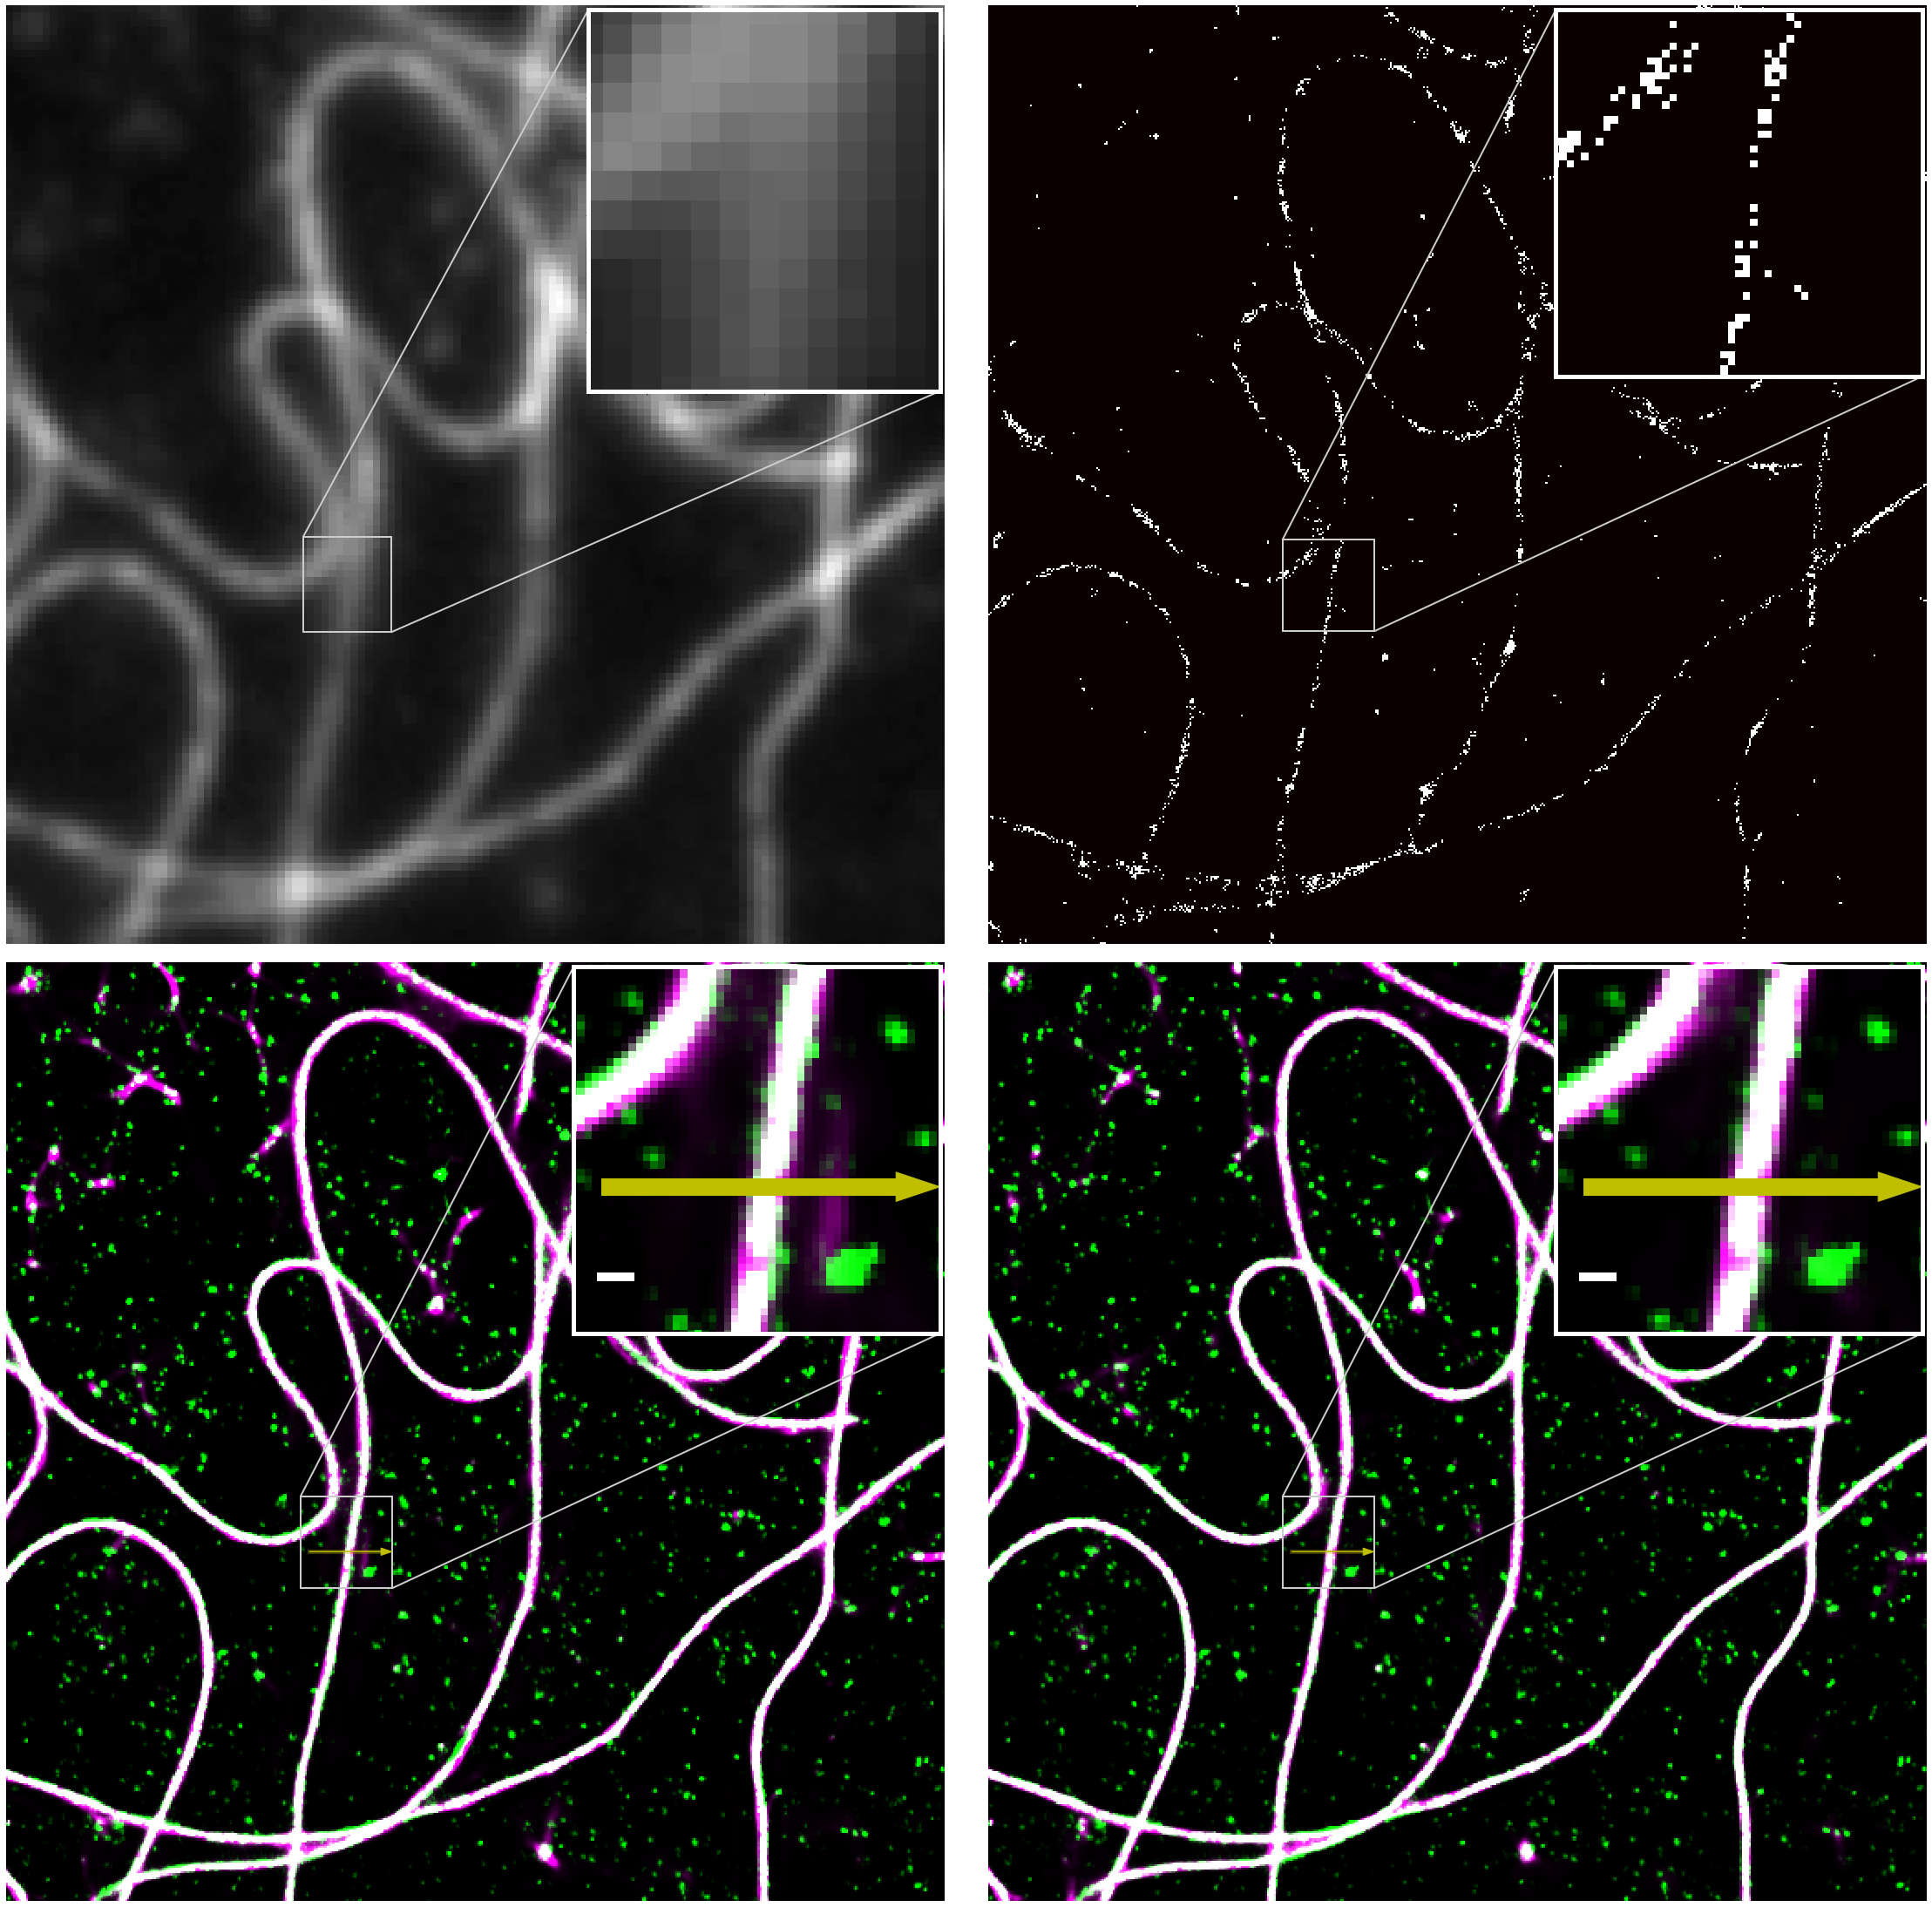

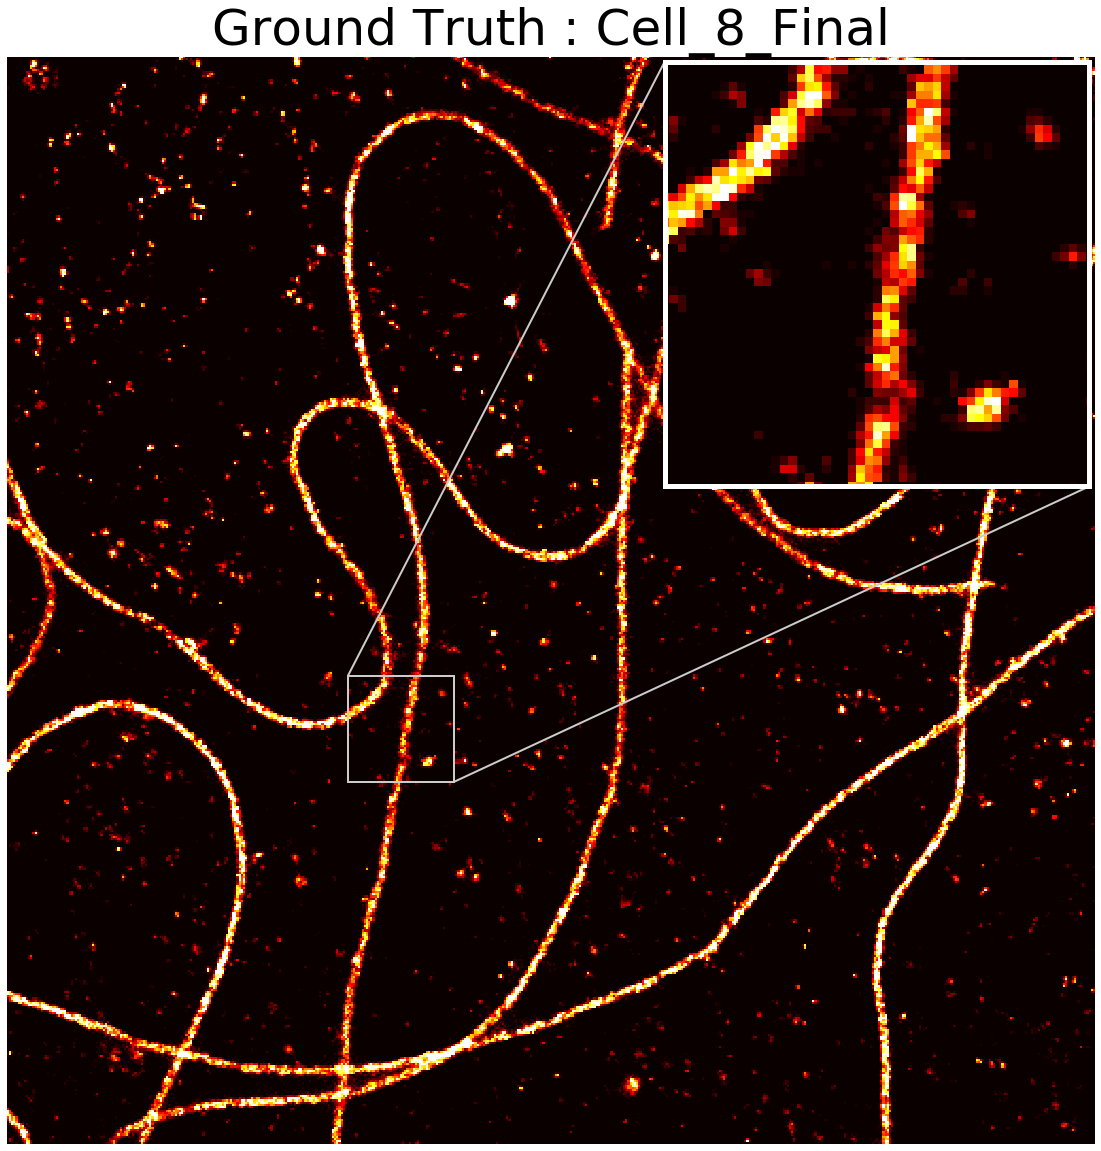

In [40]:
name_ind = 18


    
DirBase_c = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/Traitement_concentration/train_on_imod/withWF/1uM/outputs/'

DirBase_d = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/Traitement_concentration/ssABBE/outputs/'
#DirBase_d = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/Traitement_concentration/ssCL/outputs/'
#DirBase_d = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/Traitement_concentration/ssSAUER/outputs/'
DirBase_d = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/Traitement_concentration/ssSIN/100nM/outputs/'
DirBase_d = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/Traitement_concentration/ssSIN/withWF/1uM/outputs/'

DirGT = DirBase_d
fact = 20
crop_cord = (384,384)
zoom_cord = (160,170)
line = (225, 200, 225+20, 195+40)
line = (165, 190, 204, 190)

outputs_shareloc(DirGT = DirGT,
                 DirBase_c = DirBase_c, 
                 DirBase_d = DirBase_d,
                 fact = fact,
                 crop_cord = crop_cord, 
                 zoom_cord=zoom_cord, 
                 line = line,
                 zoomsize = 50,
                 chopsize = 512, 
                 FrameNb = 300, 
                 name_ind=name_ind, 
                 add_title = False, 
                 save_fig = True, 
                 show_zoom = True,
                 norm = True,
                 savedir = 'noco',
                 title_c = 'Merged,trained on M0', 
                 title_d = 'Merged,trained on M4')


## import ssim.

../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/__images__/outputs/
['Cell_10_noco_1uM_15min_Final' 'Cell_1_noco_1uM_15min_Final'
 'Cell_2_noco_1uM_15min_Final' 'Cell_3_noco_1uM_15min_Final'
 'Cell_4_noco_1uM_15min_Final' 'Cell_5_noco_1uM_15min_Final'
 'Cell_6_noco_1uM_15min_Final' 'Cell_7_noco_1uM_15min_Final'
 'Cell_8_noco_1uM_15min_Final' 'Cell_9_noco_1uM_15min_Final']
['Cell_7_noco_1uM_15min_Final.csv_A_0_(1, 301).png_real_B_b0_i0.tif']
1456.0
LocNb 1456.0


/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:101: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:102: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:103: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:104: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


ssim_raw_1 :  0.8743420811900287 ssim_raw_2 :  0.9538027314866668
ploting
(116, 116)
(462, 462)
b vmax: 3.0
(462, 462)


<Figure size 2880x2880 with 0 Axes>

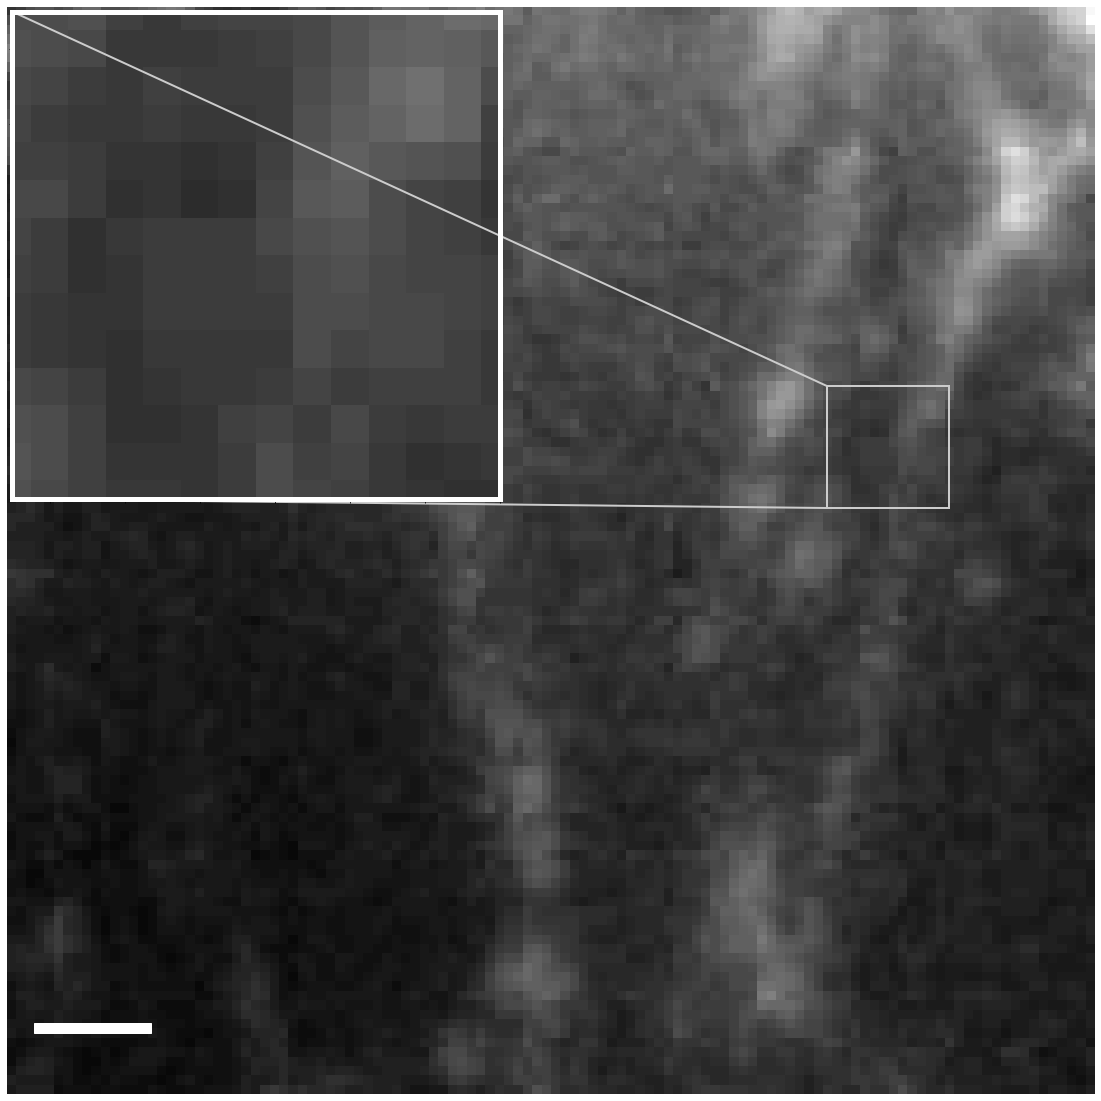

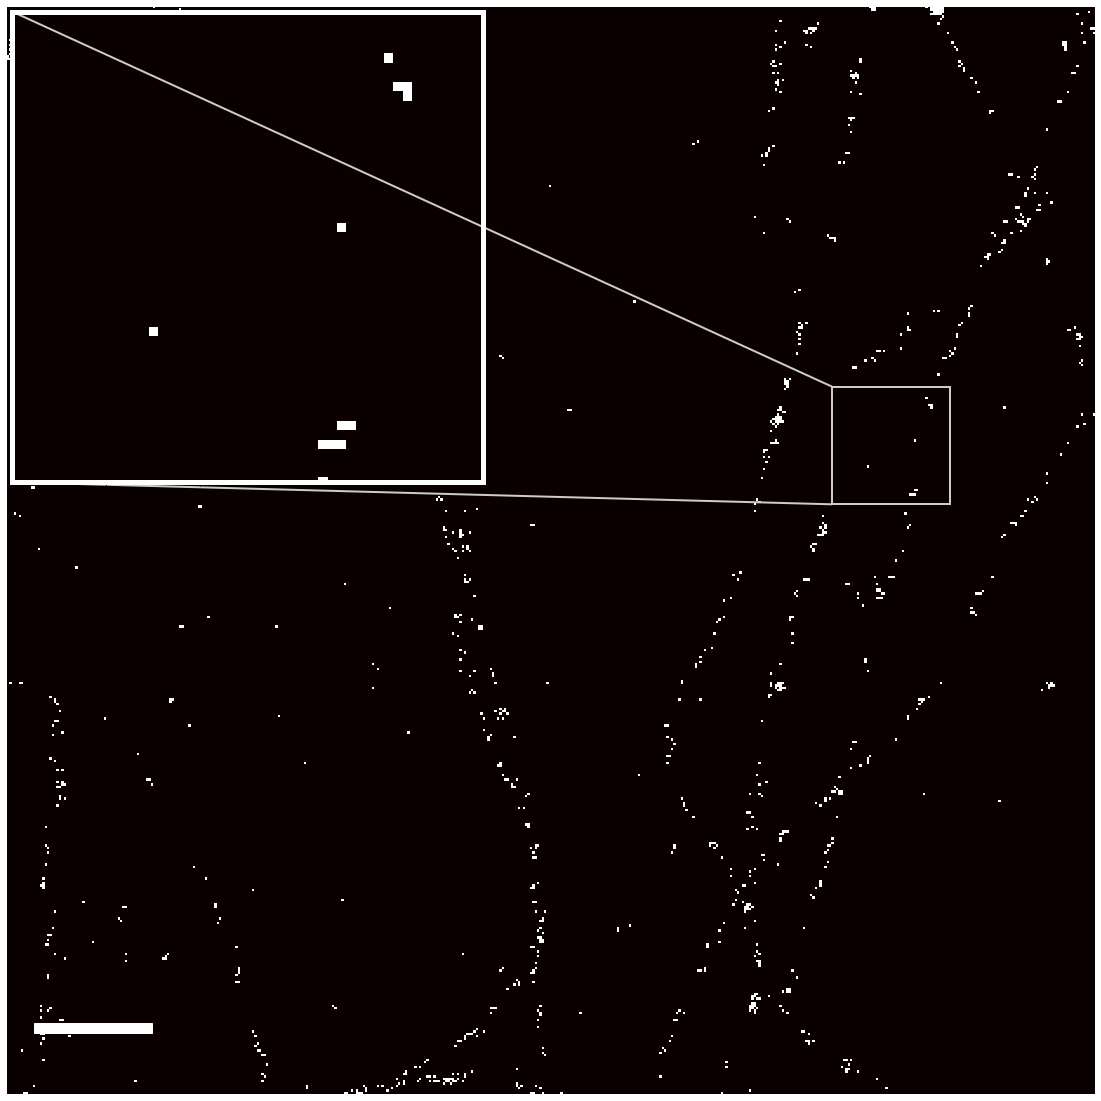

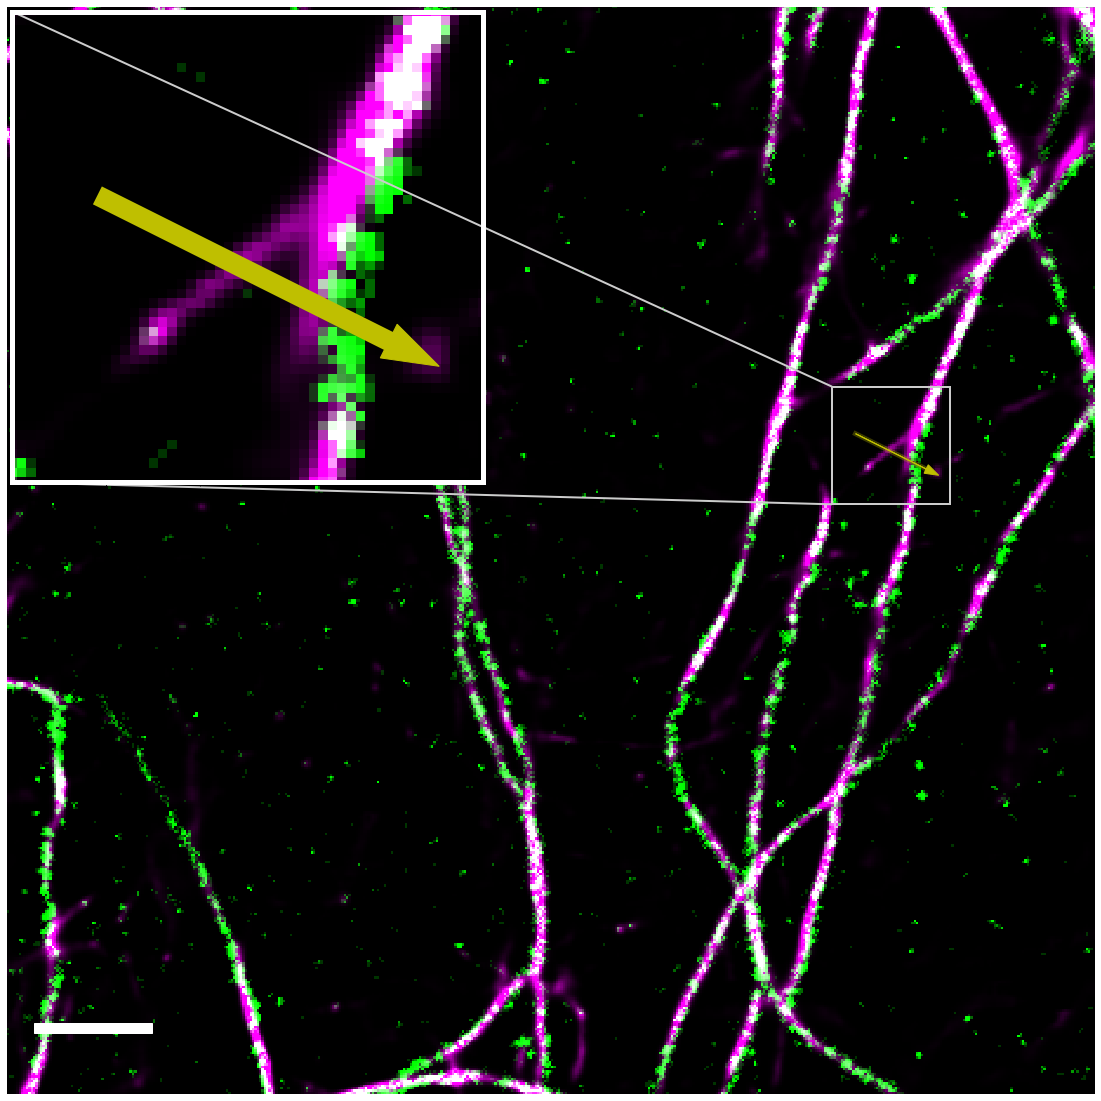

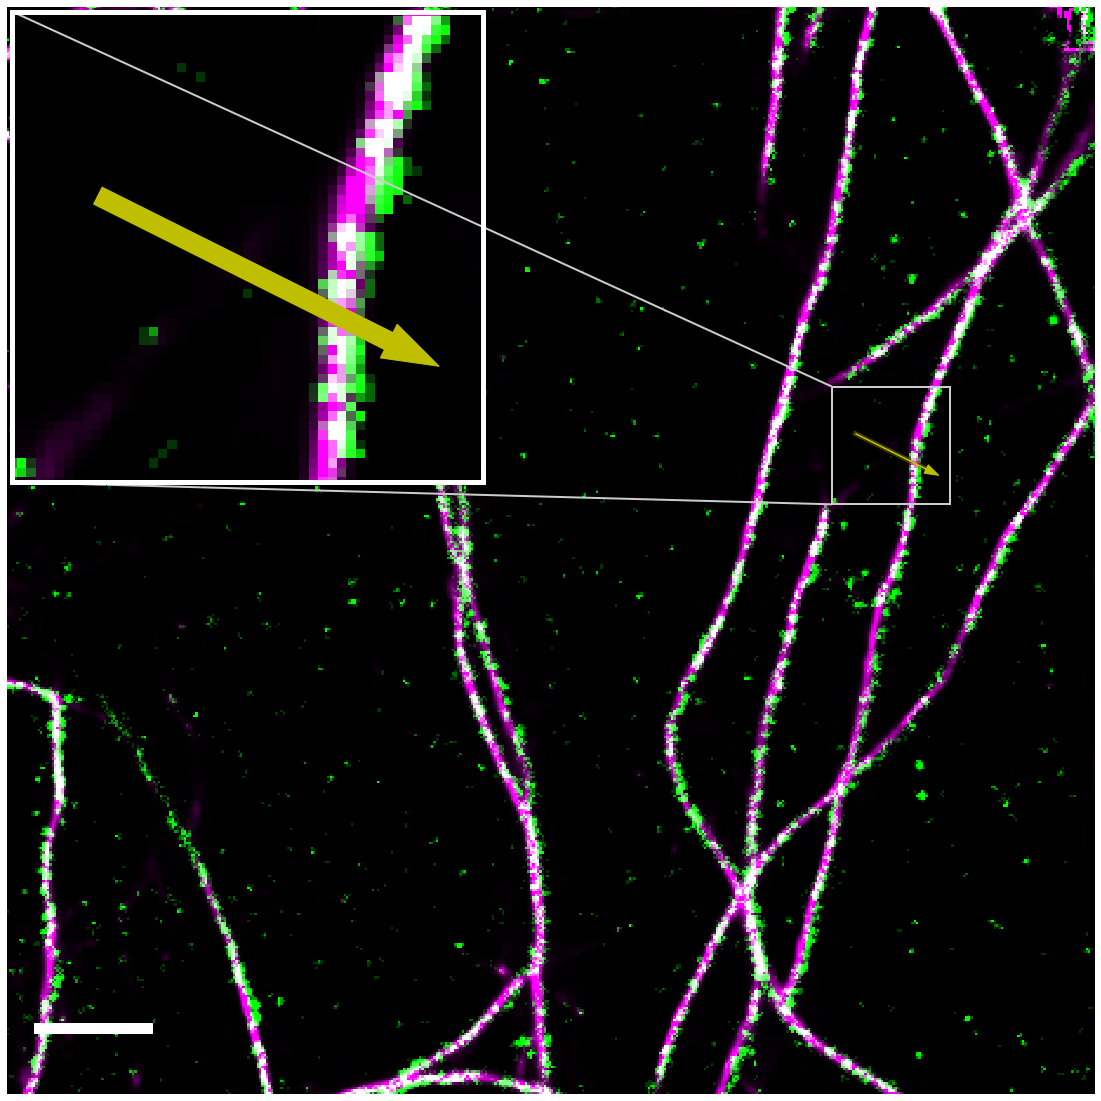

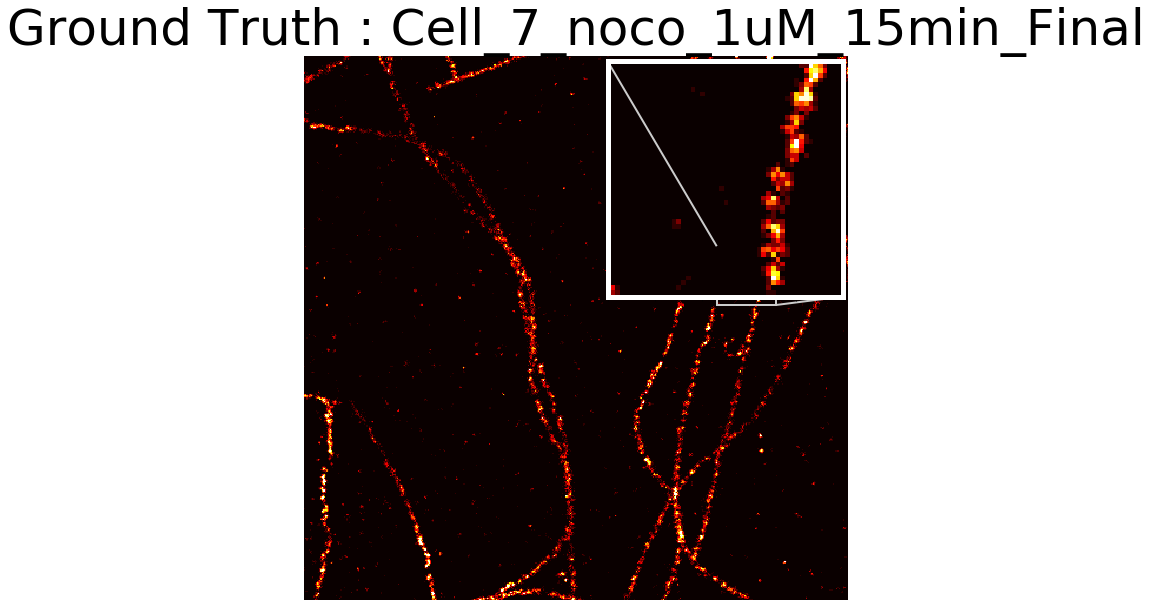

In [290]:
name_ind = 7
crop_cord = (50,50)
zoom_cord = (1150,1450)
zoom_cord = (450,950)
zoom_cord = (200,200)
zoom_cord = (210,195)
zoom_cord = (60,195)
DirBase_c = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/2000epoch/test_on_SIN/__images__/outputs/'
DirBase_c = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/2000epoch/test_on_SAUER/__images__/outputs/'
DirBase_c = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/__images__/outputs/'

DirBase_d = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/ssSIN/__images__/outputs/'
DirBase_d = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/ssSAUER/2000epoch/__images__/outputs/'
DirBase_d = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/ssSAUER/outputs/'

DirGT = DirBase_d
fact = 20
line = (235,260,235, 260+40)
line = (82,224, 82,240)
line = (90,200, 90,240)
line = (210,265, 210,305)
zoom_cord = (210,195)
zoom_cord = (350,250)

line = (360,280,360+30,265)

outputs_shareloc(DirGT = DirGT,
                 DirBase_c = DirBase_c, 
                 DirBase_d = DirBase_d,
                 fact = fact,
                 crop_cord = crop_cord, 
                 zoom_cord=zoom_cord, 
                 line = line,
                 zoomsize = 50,
                 chopsize = 512, 
                 FrameNb = 300, 
                 name_ind=name_ind, 
                 add_title = False, 
                 save_fig = True, 
                 show_zoom = True,
                 norm = True,
                 savedir = 'Inquey',
                 title_c = 'Merged,trained on IMOD', 
                 title_d = 'Merged,trained on 4Labs')


../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/Traitement_concentration/train_on_imod/withWF/1uM/outputs/
['Cell_10_Final' 'Cell_11_Final' 'Cell_12_Final' 'Cell_13_Final'
 'Cell_14_Final' 'Cell_15_Final' 'Cell_16_Final' 'Cell_17_Final'
 'Cell_18_Final' 'Cell_19_Final' 'Cell_1_Final' 'Cell_20_Final'
 'Cell_2_Final' 'Cell_3_Final' 'Cell_4_Final' 'Cell_5_Final'
 'Cell_6_Final' 'Cell_7_Final' 'Cell_8_Final' 'Cell_9_Final']
['Cell_10_Final.csv_A_0_(1, 301).png_real_B_b0_i0.tif']
2065.0
LocNb 2065.0


/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:101: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:102: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:103: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:104: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


ssim_raw_1 :  0.7098444178264031 ssim_raw_2 :  0.8182651653384577
ploting
(128, 128)
(512, 512)
b vmax: 3.0
(512, 512)


<Figure size 2880x2880 with 0 Axes>

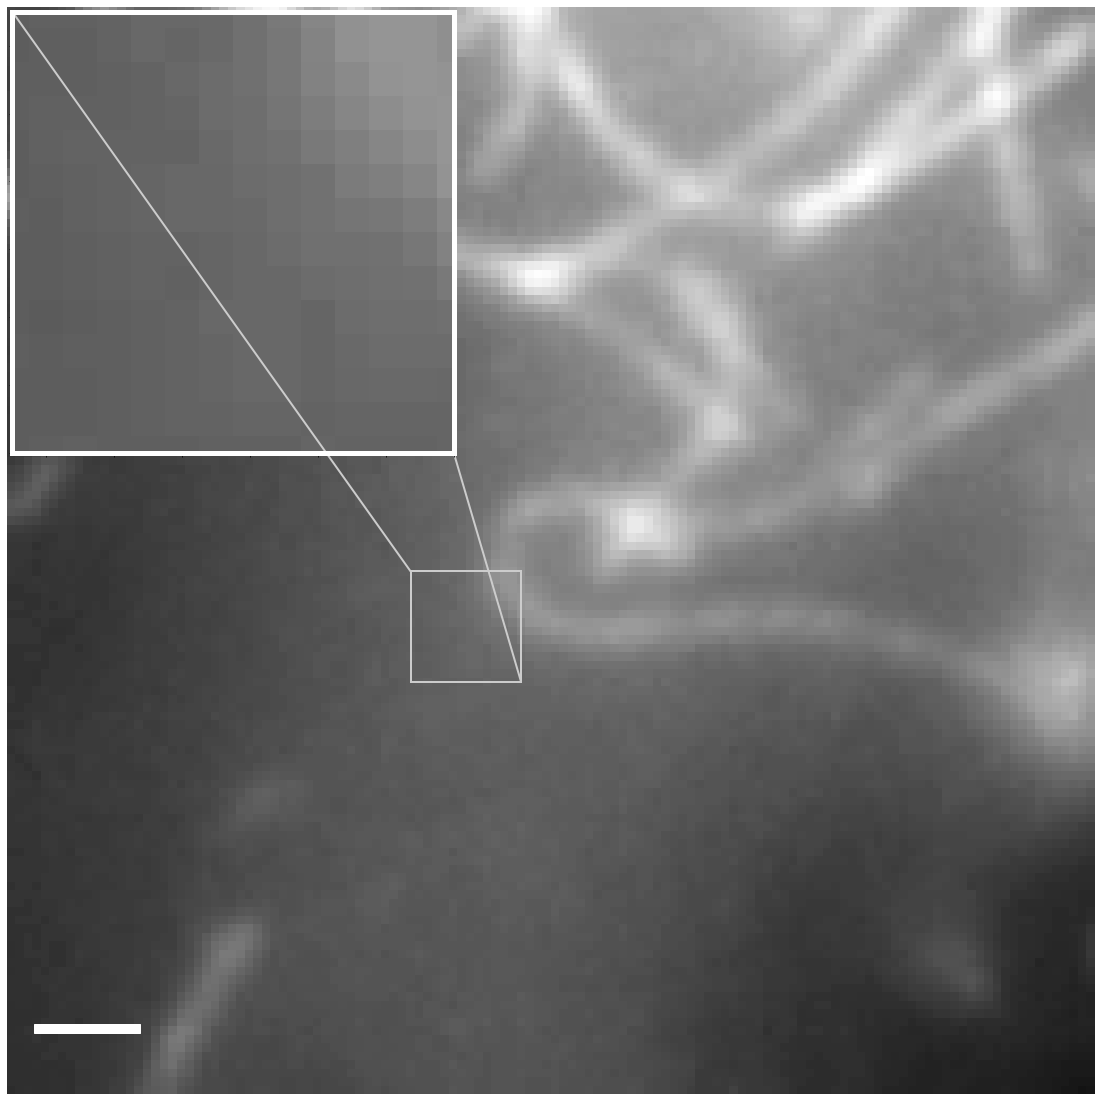

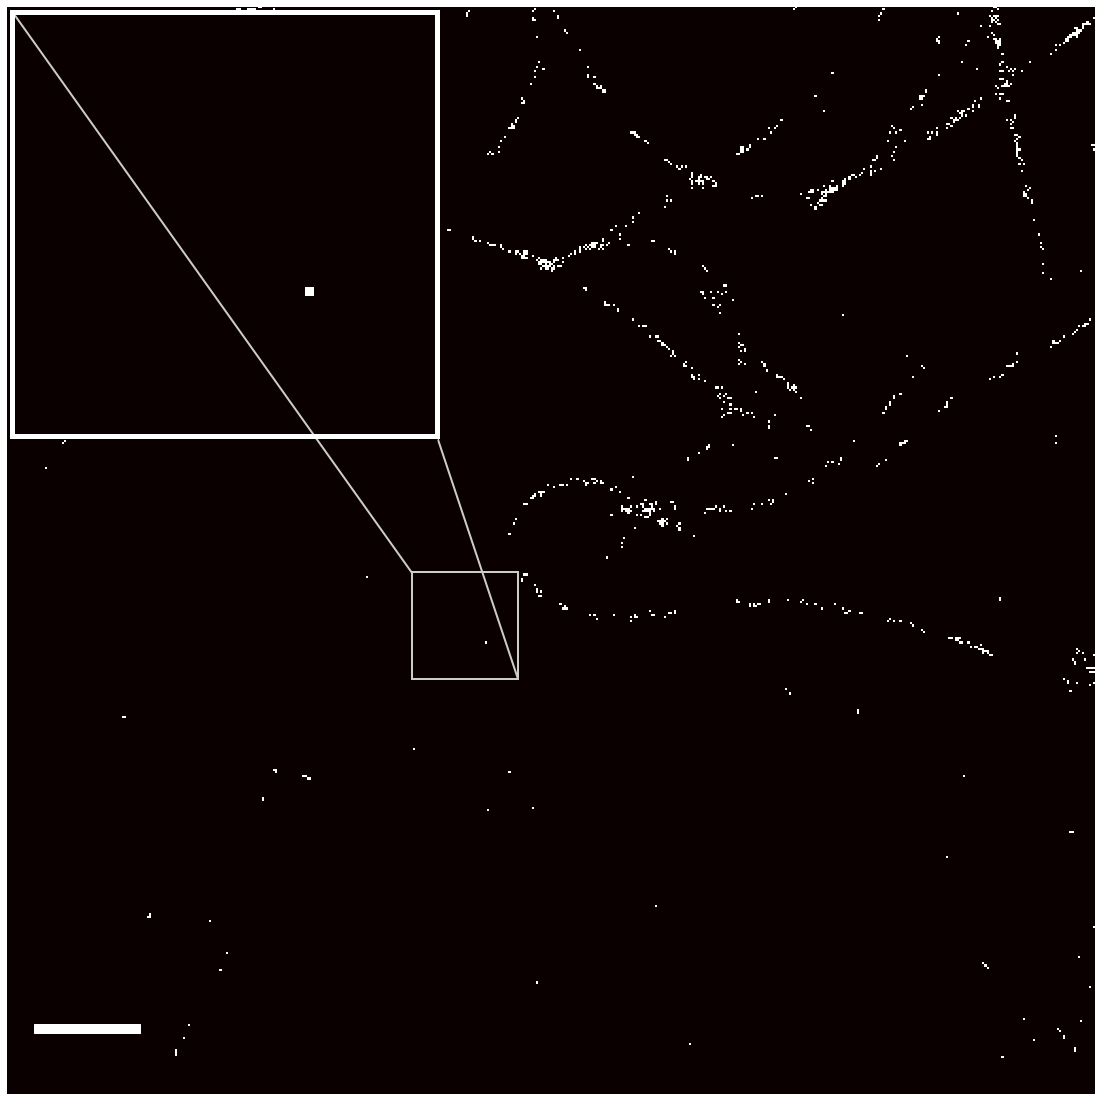

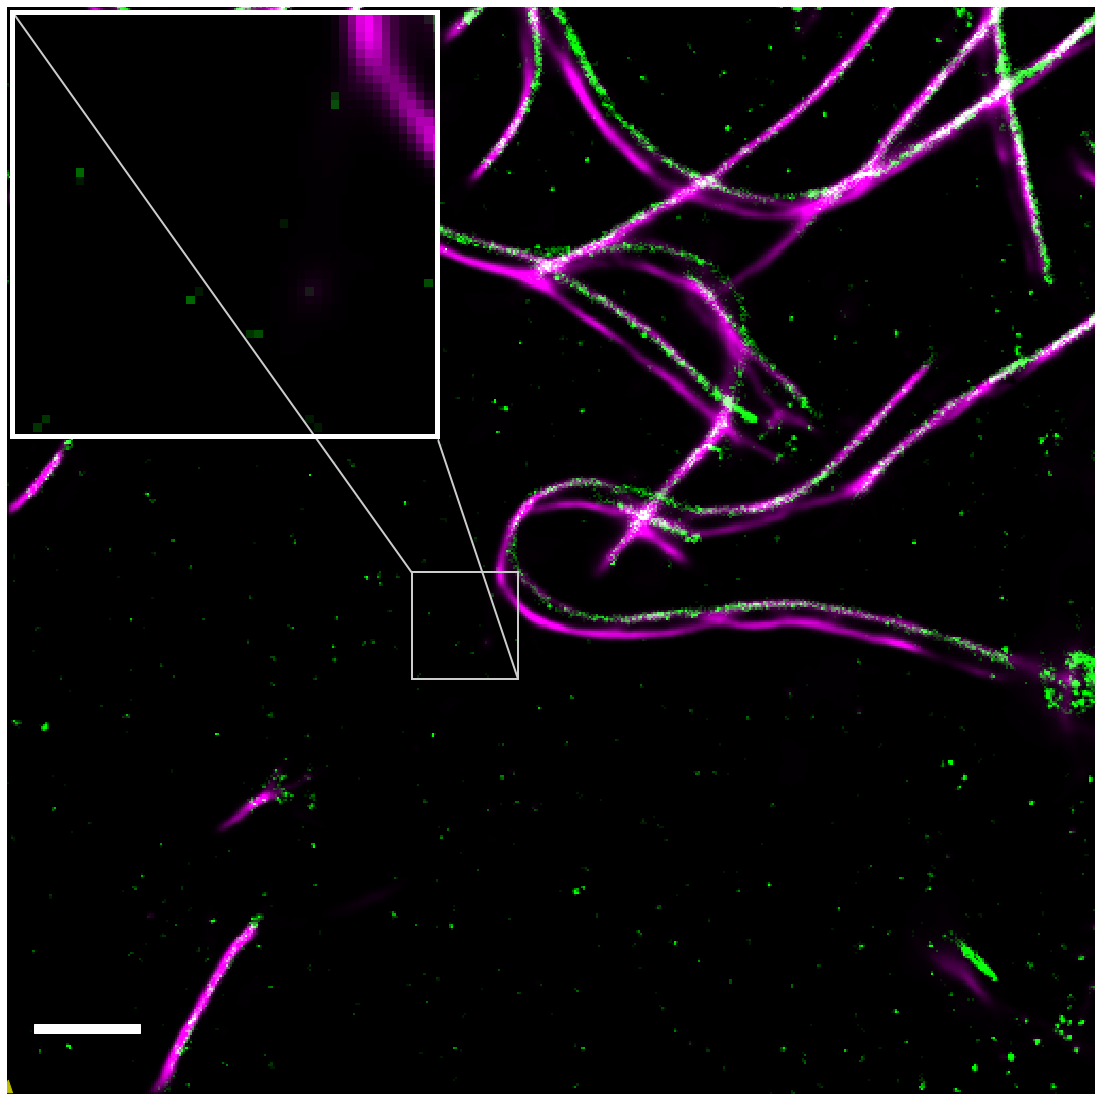

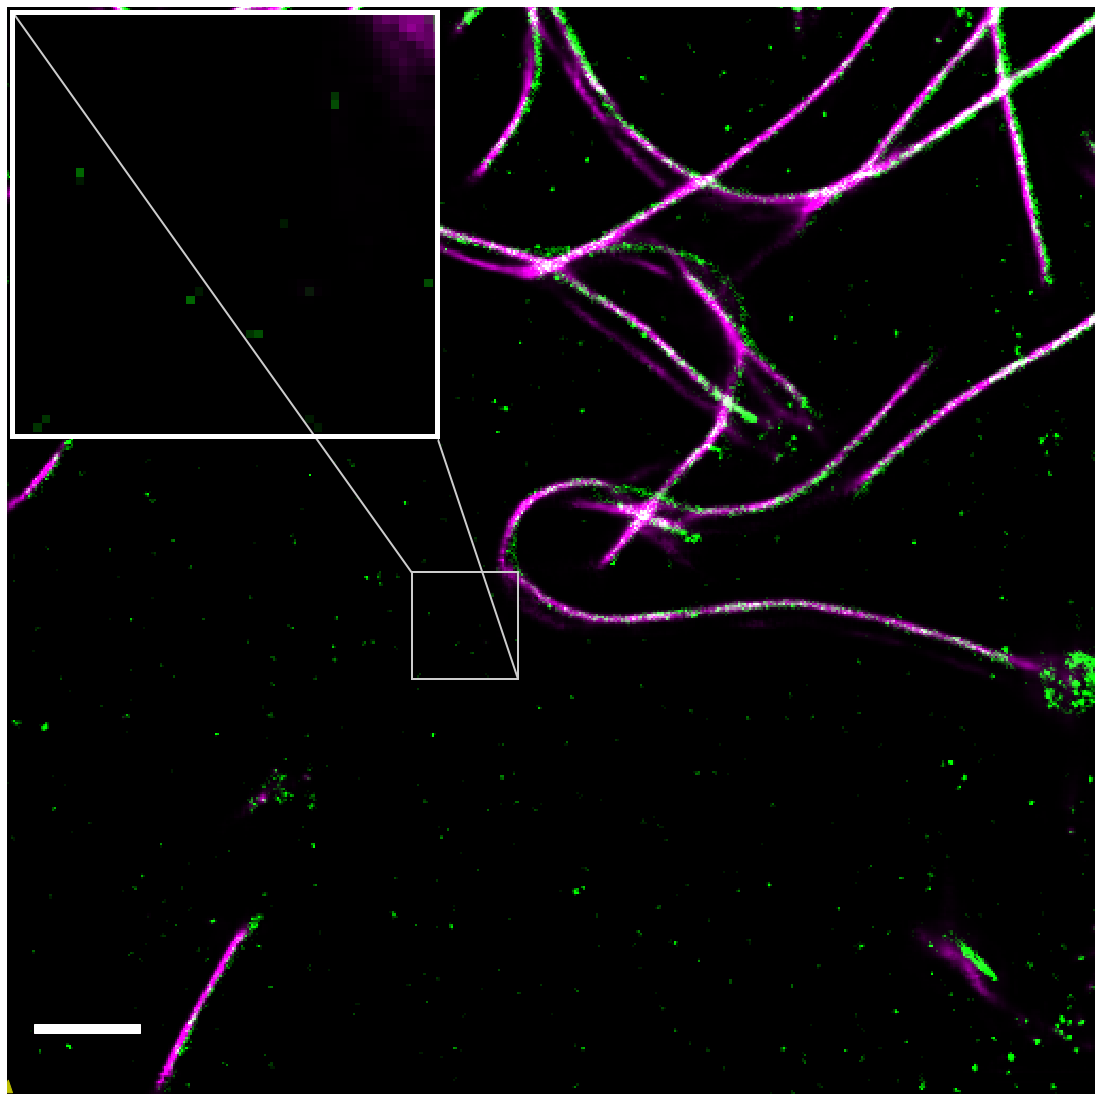

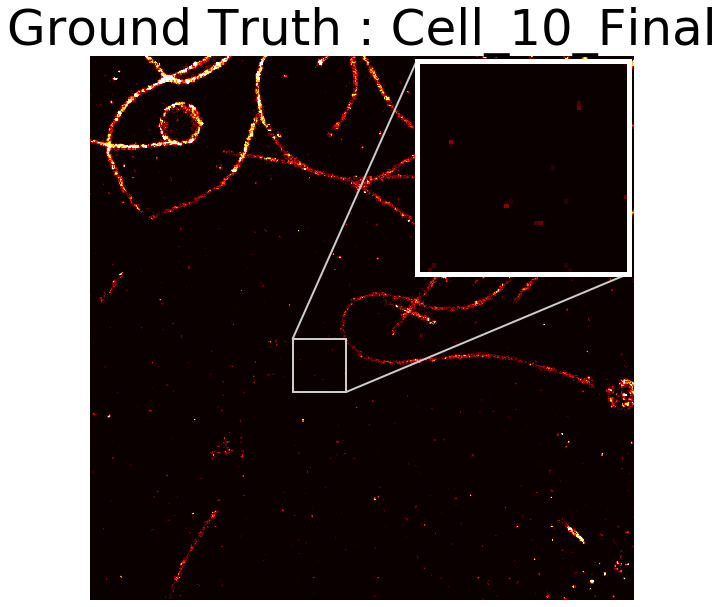

In [265]:
name_ind = 0
crop_cord = ((1280-512)//2,(1280-512)//2)
crop_cord = (0,0)
zoom_cord = (1150,1450)
zoom_cord = (450,950)
zoom_cord = (200,200)
zoom_cord = (210,195)
zoom_cord = (60,195)
DirBase_c = '../../../zeus/Jiachuan/shareLoc-Anet_test/workspace/Traitement_concentration/train_on_imod/100nM/outputs/'
DirBase_c = "../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/Traitement_concentration/train_on_imod/withWF/1uM/outputs/"
#DirBase_c = "../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/Traitement_concentration/ssSAUER/withWF/100nM/outputs/"

DirBase_d = '../../../zeus/Jiachuan/shareLoc-Anet_test/workspace/Traitement_concentration/ssABBE/100nM/outputs/'
DirBase_d = "../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/Traitement_concentration/ssABBE/withWF/100nm/outputs/"
DirBase_d = "../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/Traitement_concentration/ssSIN/withWF/1uM/outputs/"
#DirBase_d = "../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/Traitement_concentration/ssCL/withWF/100nM/outputs/"



DirGT = DirBase_d
fact = 20
line = (235,260,235, 260+40)
line = (82,224, 82,240)
line = (90,200, 90,240)
line = (210,265, 210,305)
zoom_cord = (190,195)
line = (0,0,0,0)


outputs_shareloc(DirGT = DirGT,
                 DirBase_c = DirBase_c, 
                 DirBase_d = DirBase_d,
                 fact = fact,
                 crop_cord = crop_cord, 
                 zoom_cord=zoom_cord, 
                 line = line,
                 zoomsize = 50,
                 chopsize = 512, 
                 FrameNb = 300, 
                 name_ind=name_ind, 
                 add_title = False, 
                 save_fig = False, 
                 show_zoom = True,
                 norm = True,
                 savedir = 'fig2',
                 title_c = 'Merged,trained on IMOD', 
                 title_d = 'Merged,trained on 4Labs')


../../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/diversity/trained_on_imod/__images__/outputs/
['Cell_060_DC' 'Cell_061_DC' 'Cell_062_DC' 'Cell_063_DC' 'Cell_064_DC'
 'Cell_065_DC' 'Cell_066_DC' 'Cell_067_DC' 'Cell_068_DC' 'Cell_069_DC'
 'Cell_070_DC' 'Cell_071_DC' 'Cell_072_DC' 'Cell_073_DC' 'Cell_074_DC'
 'Cell_075_DC' 'Cell_076_DC' 'Cell_077_DC' 'Cell_078_DC' 'Cell_079_DC'
 'Cell_080_DC' 'Ctrl-lowDens-12pos-taxol-exp-60k-10ms_1_MMStack_Pos0'
 'Ctrl-lowDens-12pos-taxol-exp-60k-10ms_1_MMStack_Pos1'
 'Ctrl-lowDens-12pos-taxol-exp-60k-10ms_1_MMStack_Pos2'
 'Ctrl-lowDens-12pos-taxol-exp-60k-10ms_1_MMStack_Pos3'
 's1-c1-storm-wo-COT_1_TSrec']
['Ctrl-lowDens-12pos-taxol-exp-60k-10ms_1_MMStack_Pos3.csv_A_0_(1, 301).png_real_B_b0_i0.tif']
loc: 33293.0 total 20365.145
LocNb 33293.0
ssim_raw_1 :  0.7690563873458833 ssim_raw_2 :  0.6201512986957043
ploting
(128, 128)
(512, 512)
b vmax: 3.0
(512, 512)


<Figure size 2880x2880 with 0 Axes>

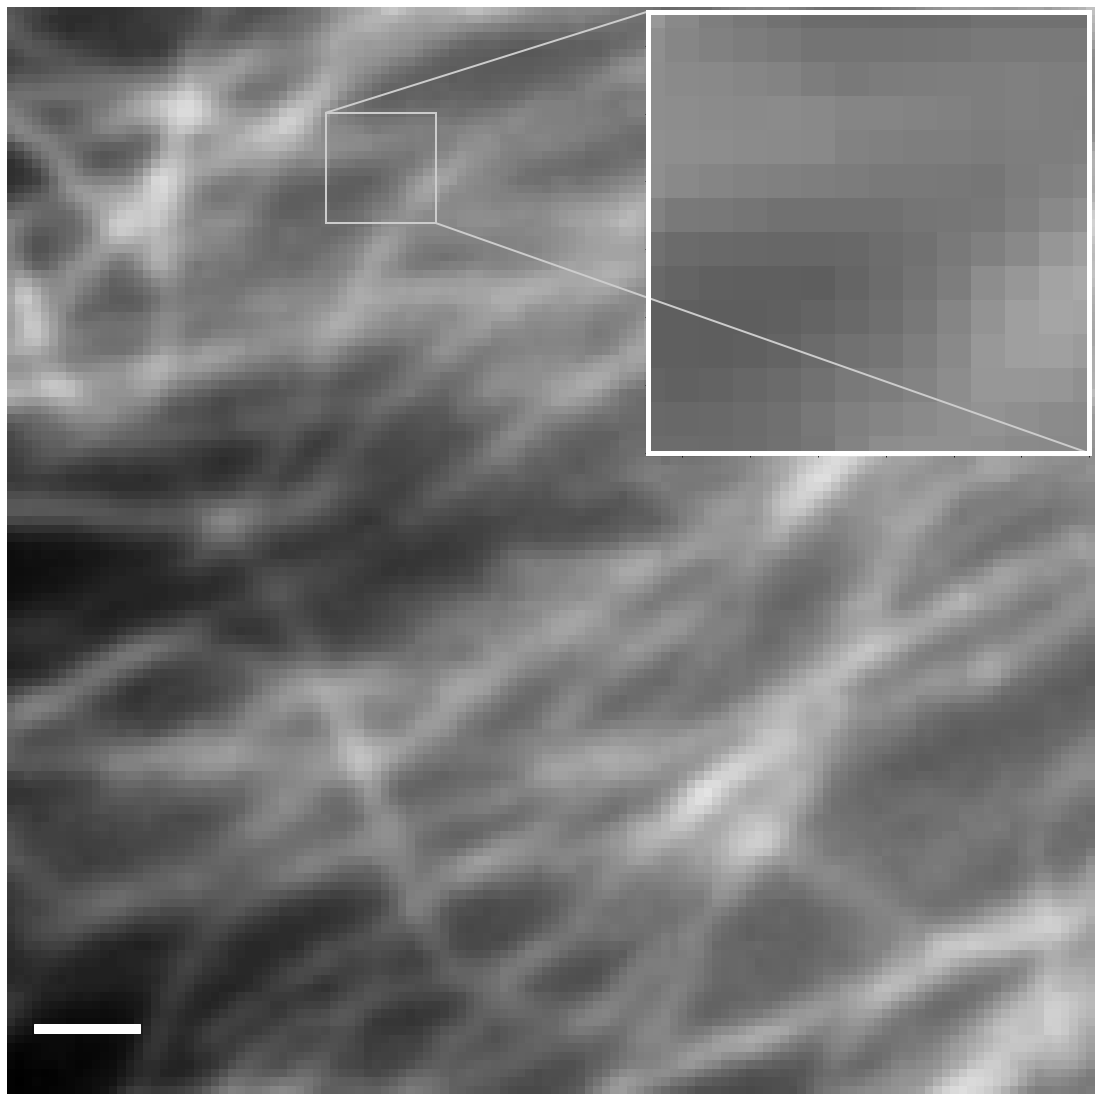

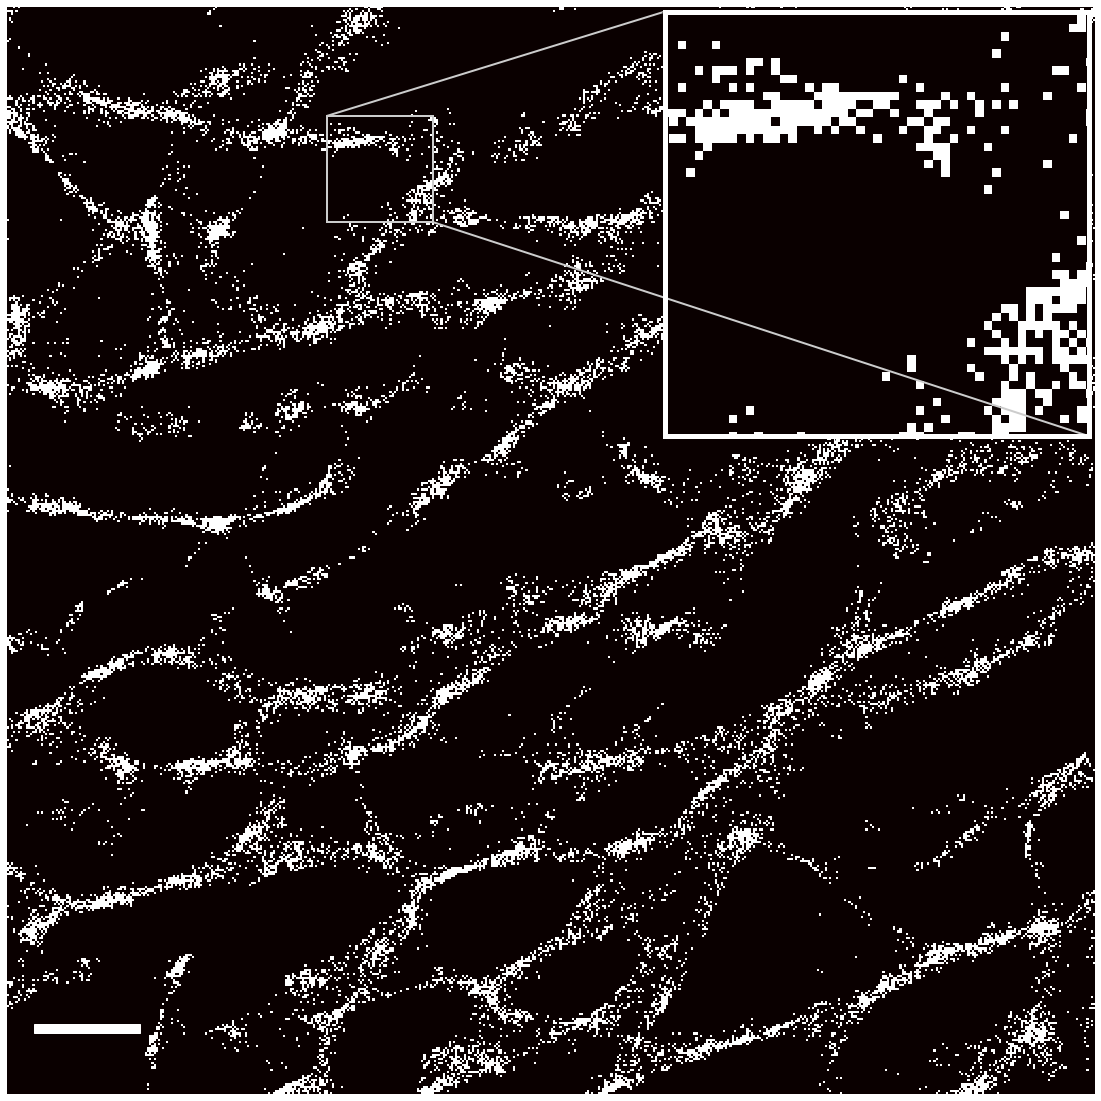

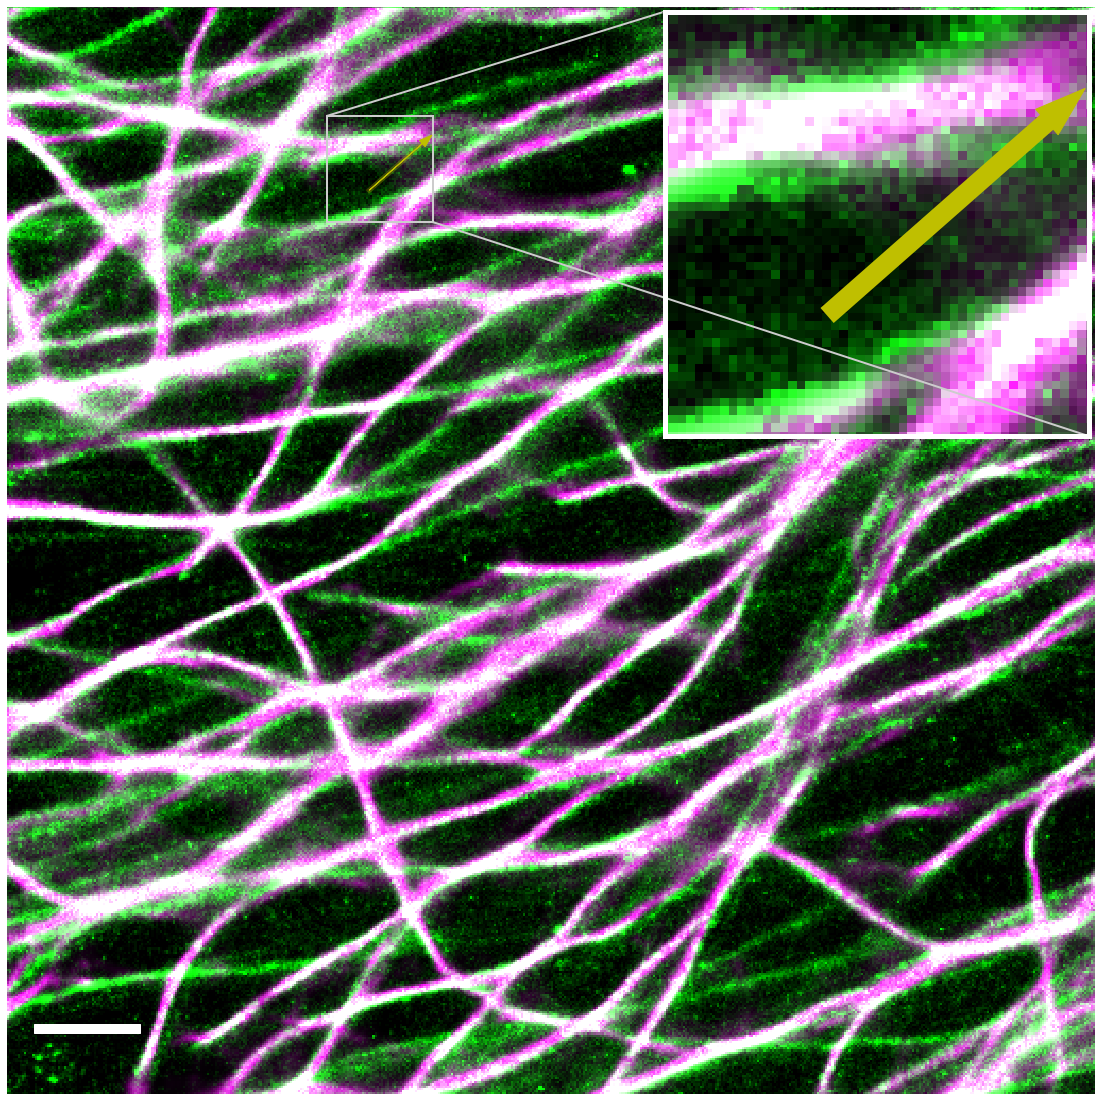

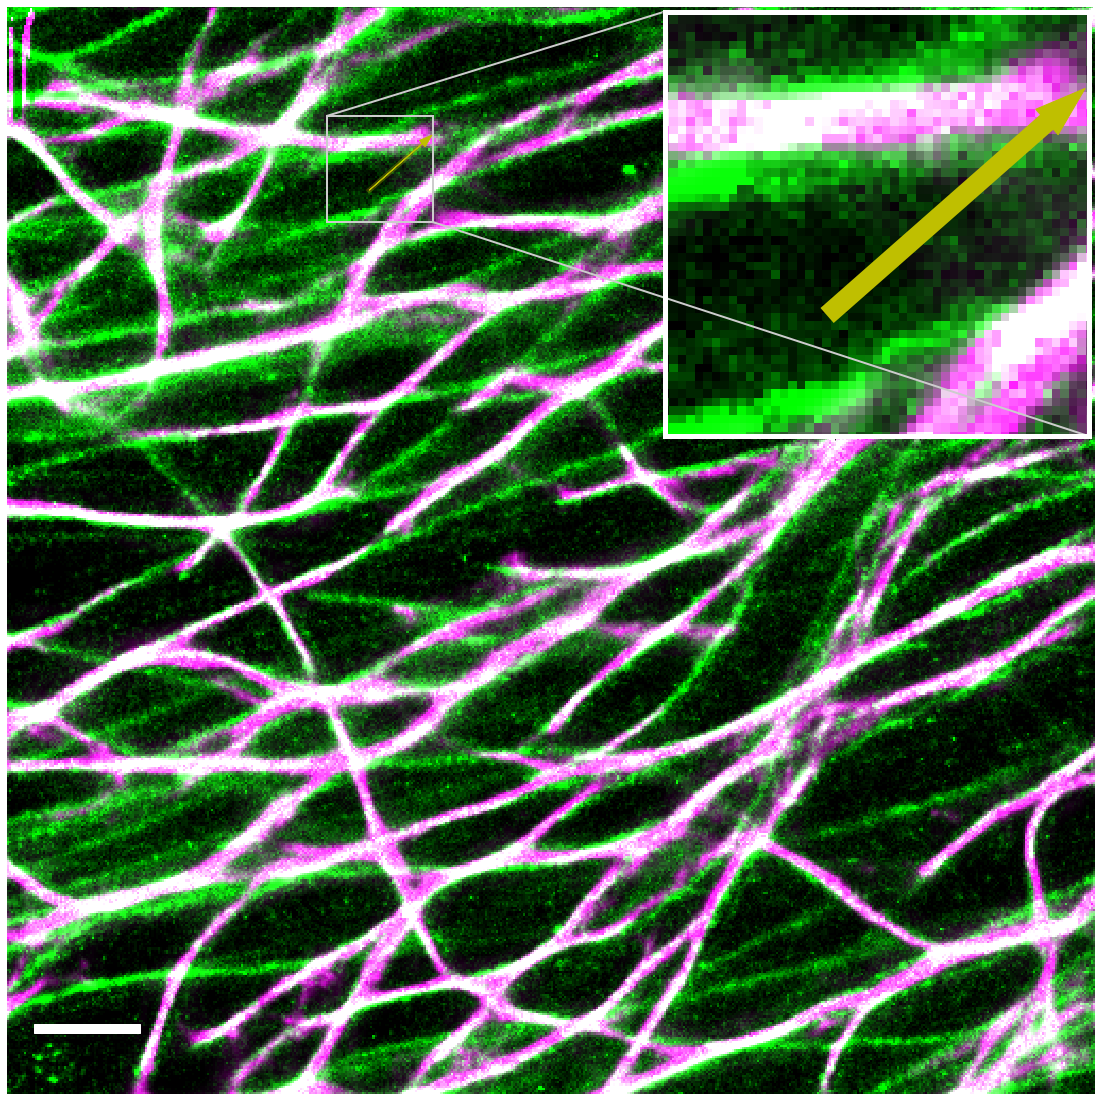

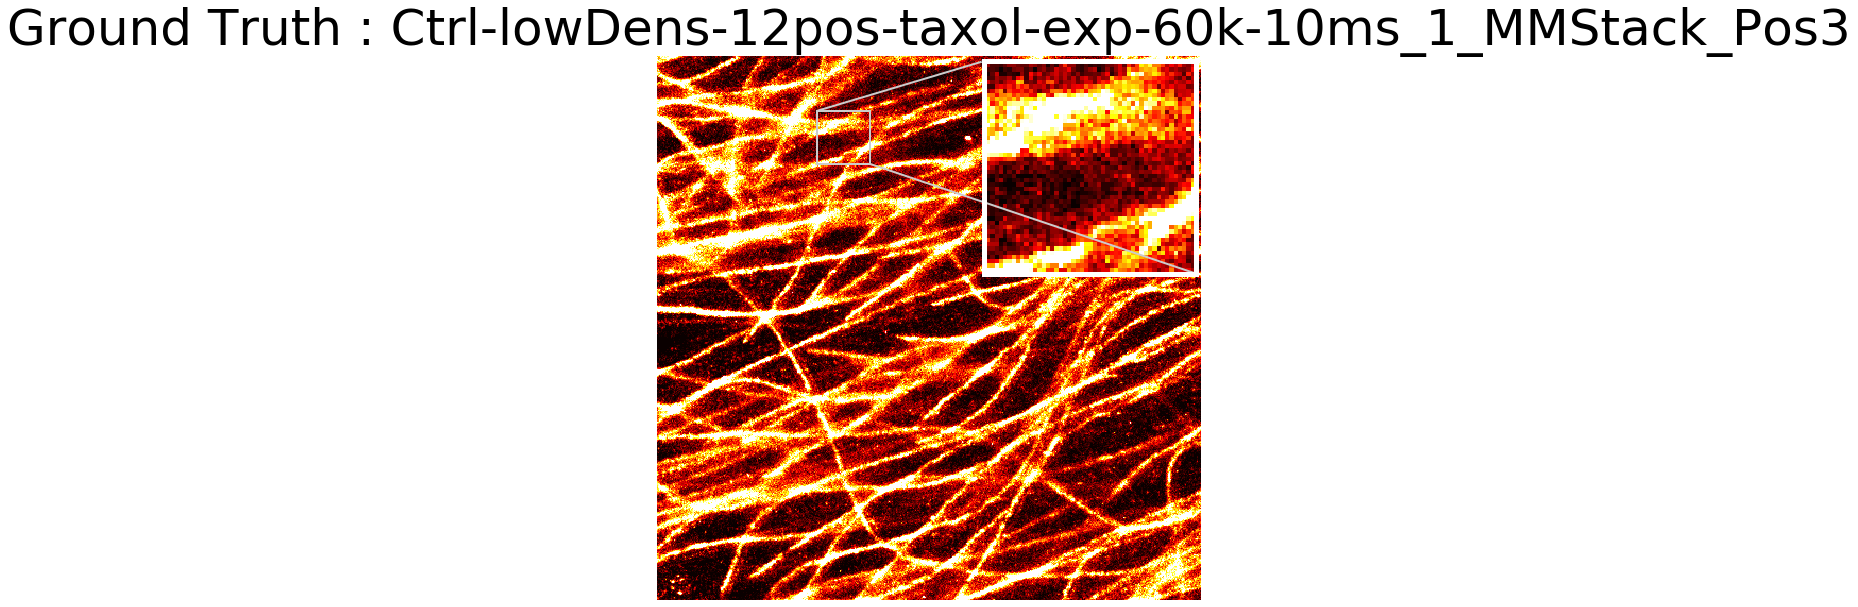

In [161]:
DirBase_c = '../../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/diversity/trained_on_imod/__images__/outputs/'

DirBase_d = '../../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/diversity/A_tr_L2_Z1_S2_K2/__images__/outputs/'

DirGT = DirBase_d
#DirGT = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/GT_Singapour/sep/'
fact = 5
name_ind = 24
line = (170,425, 195,447)
#line = (0,0, 0,0)

zoom_cord = (150,410)

outputs_shareloc(DirGT = DirGT,
                 DirBase_c = DirBase_c, 
                 DirBase_d = DirBase_d,
                 fact = fact,
                 zoom_cord=zoom_cord, 
                 line = line,
                 zoomsize = 50,
                 chopsize = 512, 
                 FrameNb = 300, 
                 name_ind=name_ind, 
                 add_title = False, 
                 save_fig = False, 
                 show_zoom = True,
                 norm = True,
                 savedir = 'quantity_only',
                 title_c = 'Merged,trained M0', 
                 title_d = 'Merged,trained on 60imags')

../../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/quantity_manish/TrainOn60/test_in_distribution/outputs
['Cell_060_DC' 'Cell_061_DC' 'Cell_062_DC' 'Cell_063_DC' 'Cell_064_DC'
 'Cell_065_DC' 'Cell_066_DC' 'Cell_067_DC' 'Cell_068_DC' 'Cell_069_DC'
 'Cell_070_DC' 'Cell_071_DC' 'Cell_072_DC' 'Cell_073_DC' 'Cell_074_DC'
 'Cell_075_DC' 'Cell_076_DC' 'Cell_077_DC' 'Cell_078_DC' 'Cell_079_DC'
 'Cell_080_DC']
['Cell_070_DC.csv_A_0_(1, 301).png_real_B_b0_i0.tif']
loc: 19597.0 total 5328.211
LocNb 19597.0
ssim_raw_1 :  0.9107385907442914 ssim_raw_2 :  0.8156925221877082
ploting
(128, 128)
(512, 512)
b vmax: 3.0
(512, 512)


<Figure size 2880x2880 with 0 Axes>

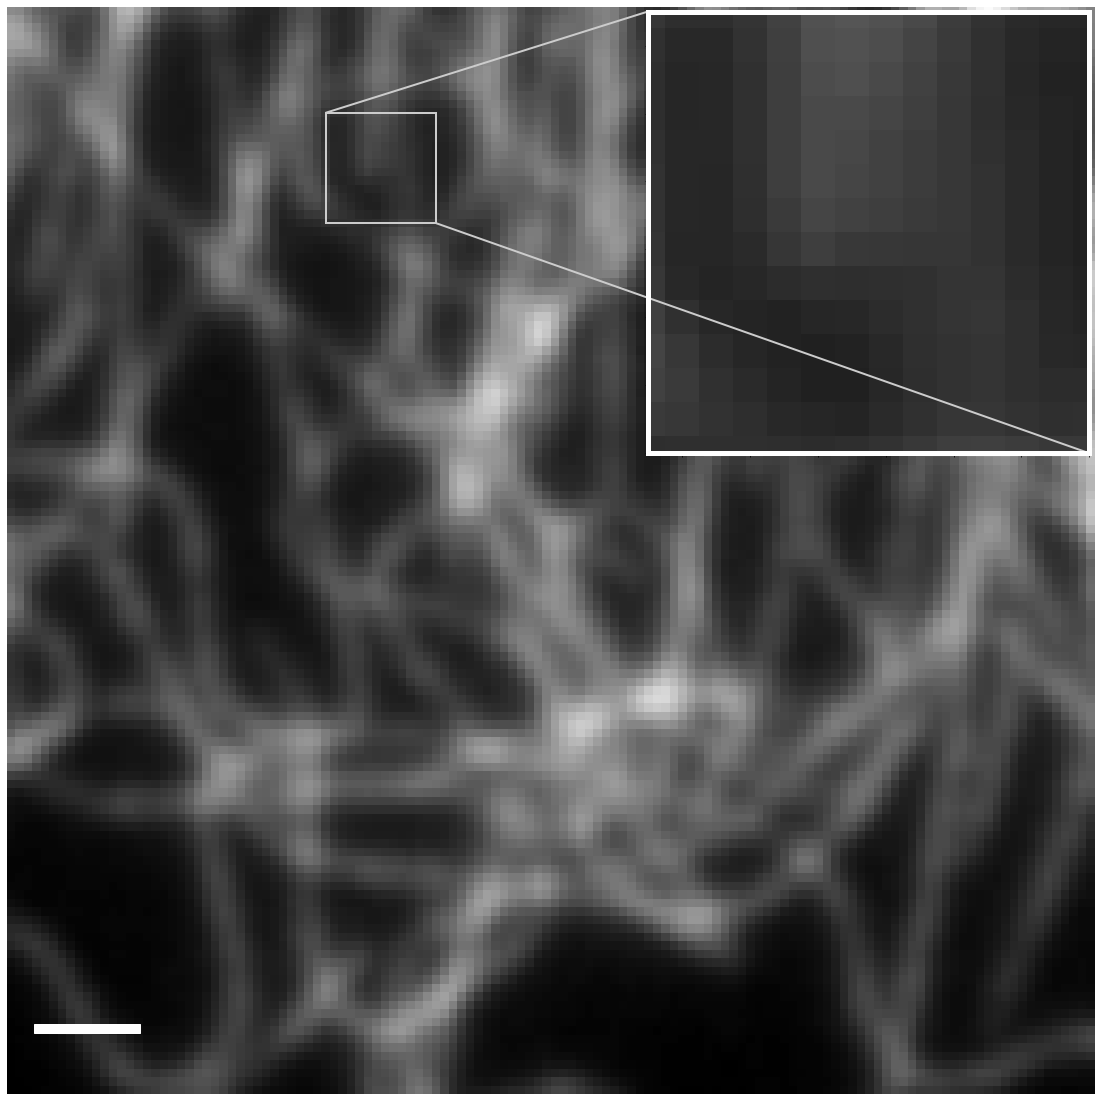

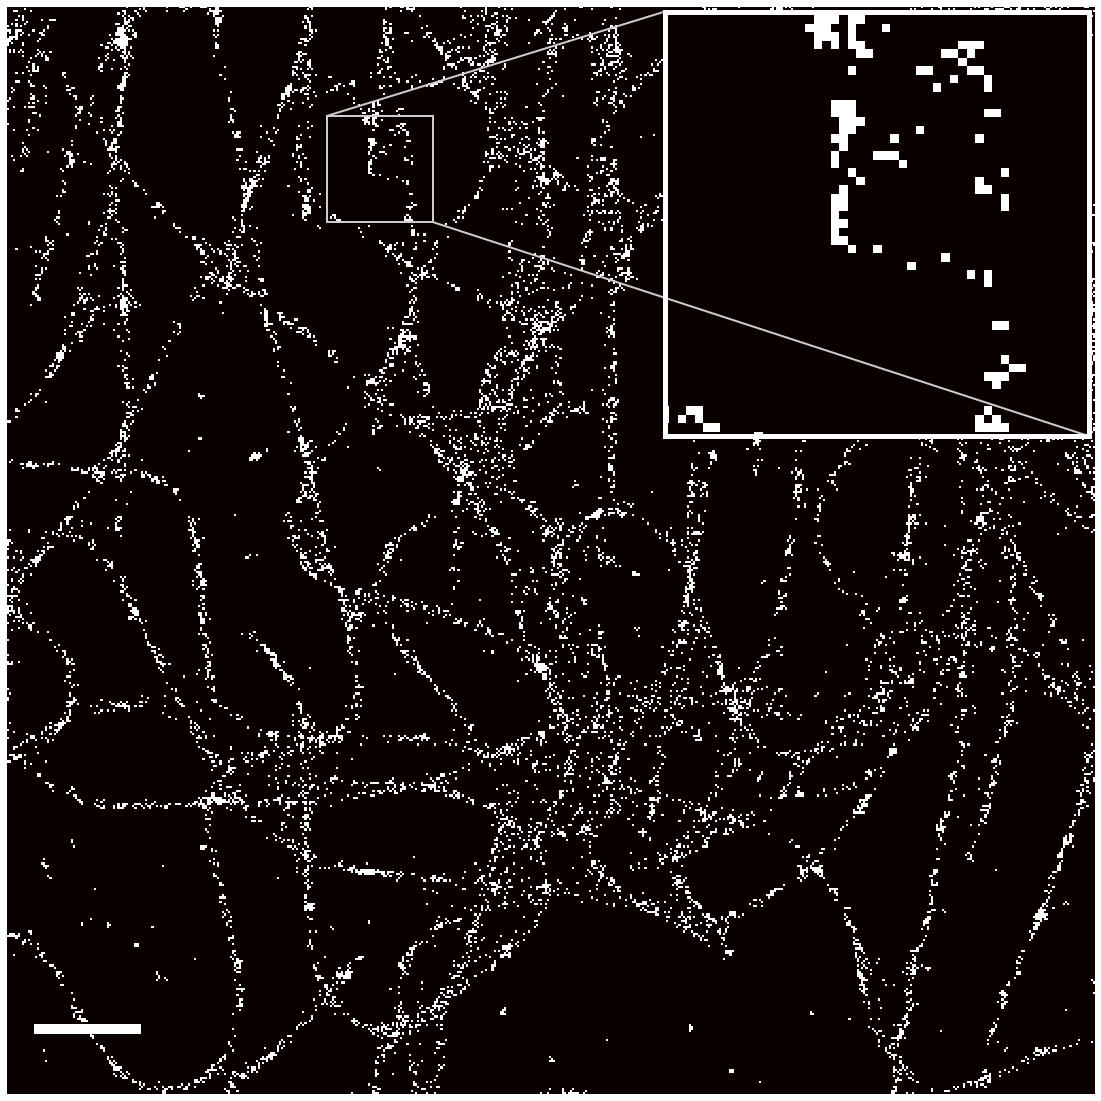

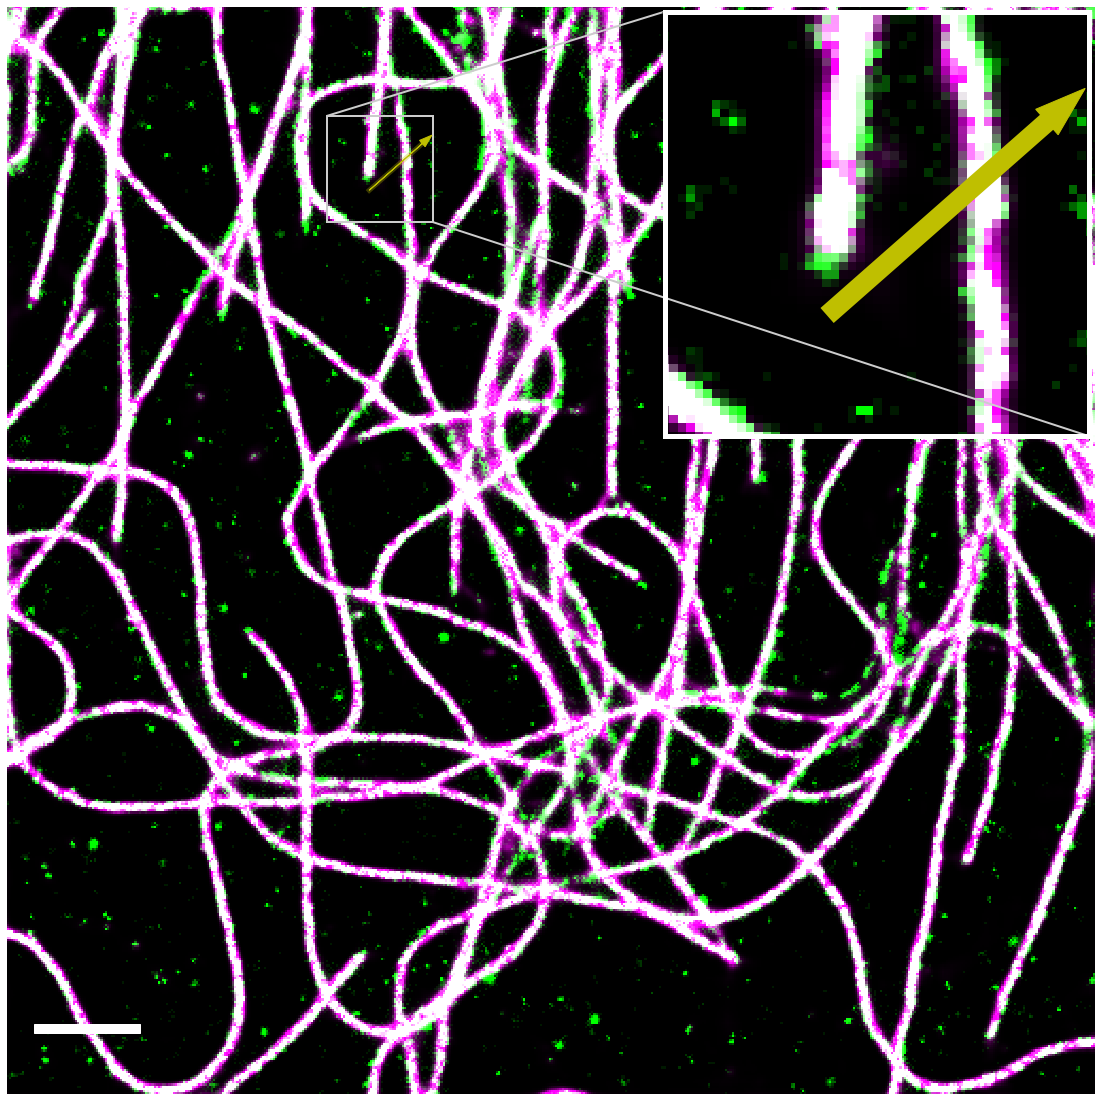

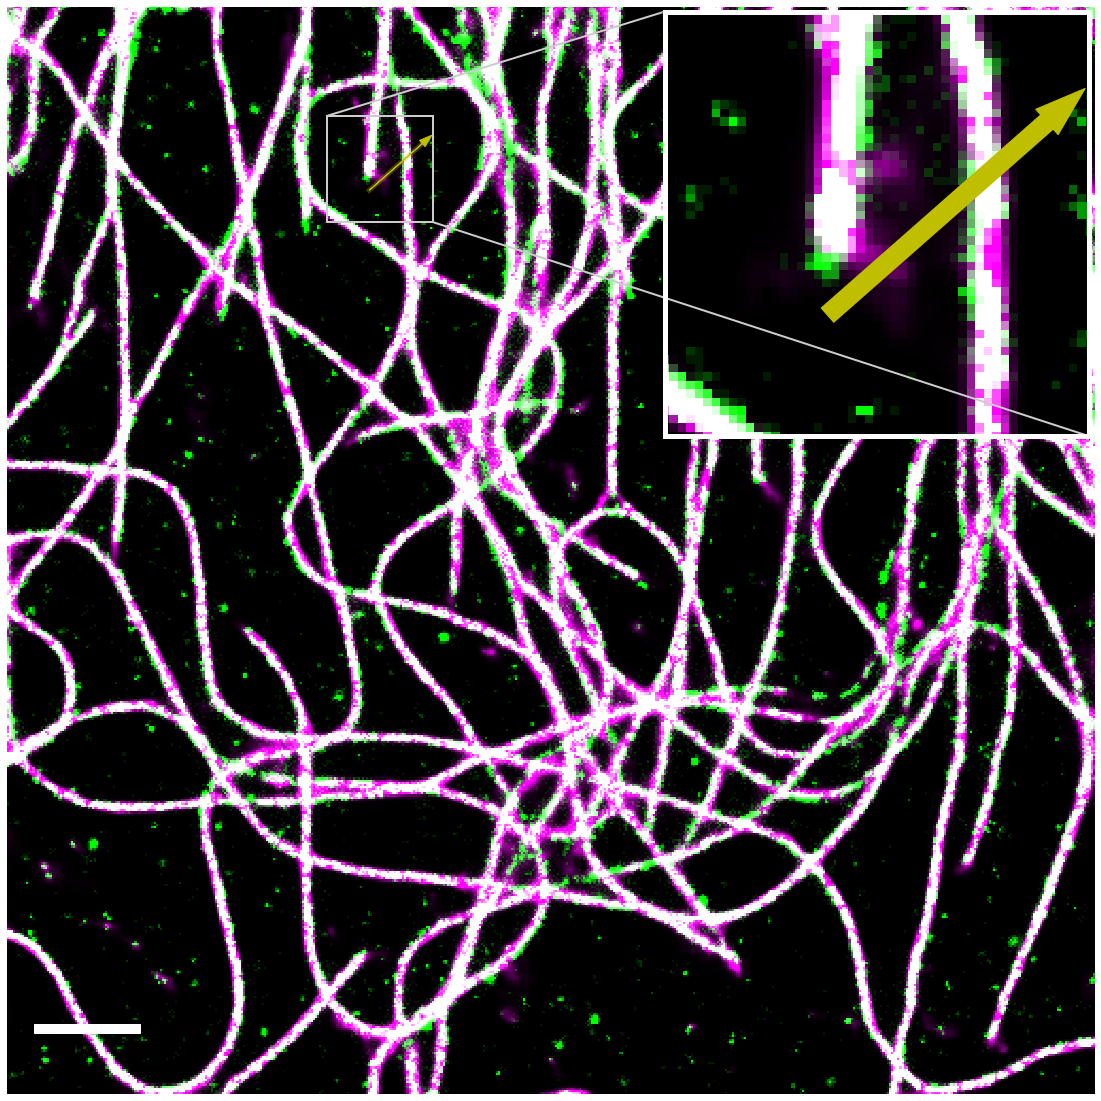

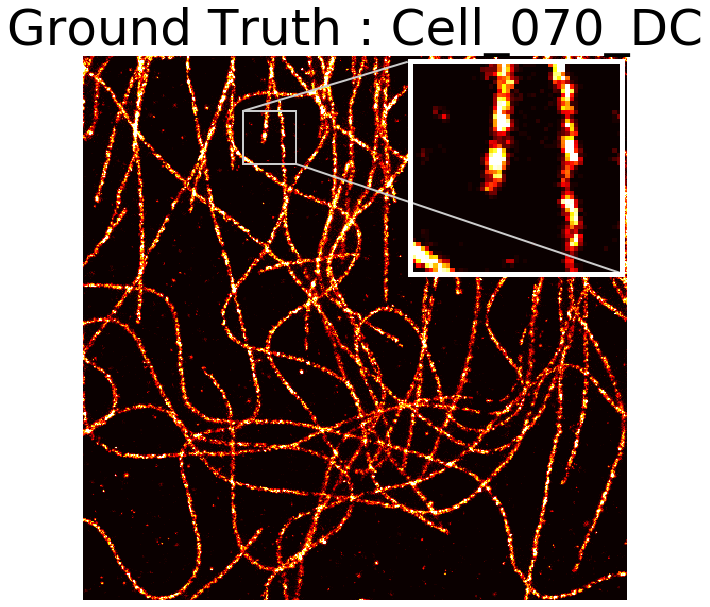

In [143]:
DirBase_c = '../../../../zeus/Jiachuan/shareLoc-Anet_test/workspace/quantity_manish/TrainOn1_1/__images__/outputs/'
DirBase_d = '../../../zeus/Jiachuan/shareLoc-Anet_test/workspace/quantity_manish/TrainOn60_0/1100epoch/__images__/outputs/'
DirBase_c = '../../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/quantity_manish/TrainOn1_8/outputs/'
DirBase_c = '../../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/quantity_manish/TrainOn60/test_in_distribution/outputs'

DirBase_d = '../../../../gpulab/shareLoc-Anet/shareLoc-Anet_jiachuan/workspace/quantity_manish/Train7_0/__images__/outputs/'
DirGT = DirBase_d
#DirGT = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/GT_Singapour/sep/'
fact = 20
name_ind = 10
line = (170,425, 195,447)
#line = (0,0, 0,0)

zoom_cord = (150,410)

outputs_shareloc(DirGT = DirGT,
                 DirBase_c = DirBase_c, 
                 DirBase_d = DirBase_d,
                 fact = fact,
                 zoom_cord=zoom_cord, 
                 line = line,
                 zoomsize = 50,
                 chopsize = 512, 
                 FrameNb = 300, 
                 name_ind=name_ind, 
                 add_title = False, 
                 save_fig = True, 
                 show_zoom = True,
                 norm = True,
                 savedir = 'quantity_only',
                 title_c = 'Merged,trained on 1_5', 
                 title_d = 'Merged,trained on 60imags')

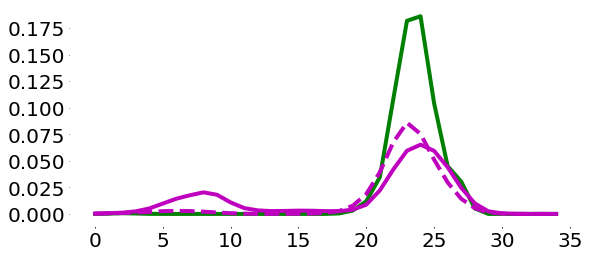

In [144]:
#ax = plt.figure(figsize=(7, 5))
#fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(20, 4))
plt.subplot(121)
savedir = "quantity_only"
zoomsize = 50
#line = (215,200, 255,245)
x0,y0,x1,y1 = line
x0,y0,x1,y1 = line

(wf, histin, gt, Merged_c, Merged_d,Reco_c,Reco_d) = __data['results_images']
profile_gt = profile_line(gt,(y0,x0),(y1,x1), linewidth=5)
profile_c = profile_line((Reco_c/Reco_c.sum())*gt.sum(),(y0,x0),(y1,x1), linewidth=5)
#profile_c = profile_line(Reco_c,(y0,x0),(y1,x1), linewidth=5)

profile_d = profile_line((Reco_d/Reco_d.sum())*gt.sum(),(y0,x0),(y1,x1), linewidth=5)  
#profile_d = profile_line(Reco_d,(y0,x0),(y1,x1), linewidth=5)  

matplotlib.rc('axes',edgecolor='k',linewidth=2)
lw = 4
plt.plot(profile_gt,color='green',lw = lw)
plt.plot(profile_c,color='m',ls = '--',lw = lw)
plt.plot(profile_d,color='m',lw = lw)
#ax.xaxis.tick_top()
#ax.yaxis.tick_right()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.ylim(0,0.06)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)


"""plt.legend(("Ground truth","Model 1 img","Model 60 img"),
           fontsize=20,
           loc='upper center', 
           ncol=3, bbox_to_anchor=(1, 1.2),
           borderaxespad=0.)"""

"""
"""
#ax.invert_yaxis()
plt.axis('on')
from datetime import date
today = str(date.today()).replace("-", "_")

plt.savefig('../Shareloc/{}/profilline_quantity_{}_{}_{}_{}_{}_legendnormolized_m7m60.svg'.format(savedir,
                                                                           x0,y0,x1,y1,today),
            transparent=False)

/home/jiachuan/miniconda3/envs/shareloc/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  
/home/jiachuan/miniconda3/envs/shareloc/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jiachuan/miniconda3/envs/shareloc/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  
/home/jiachuan/miniconda3/envs/shareloc/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  import sys


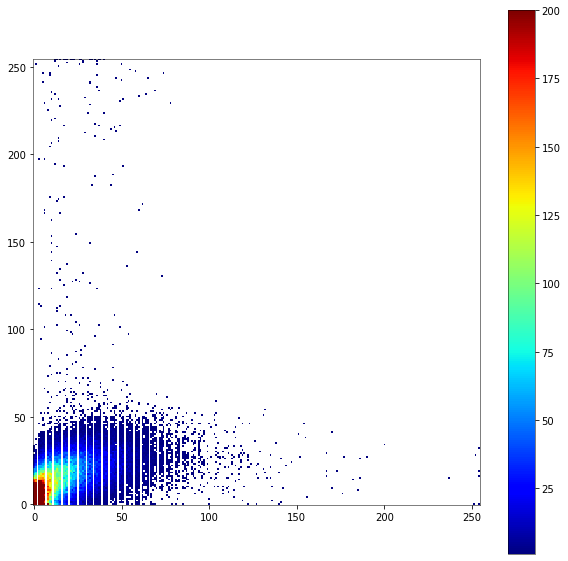

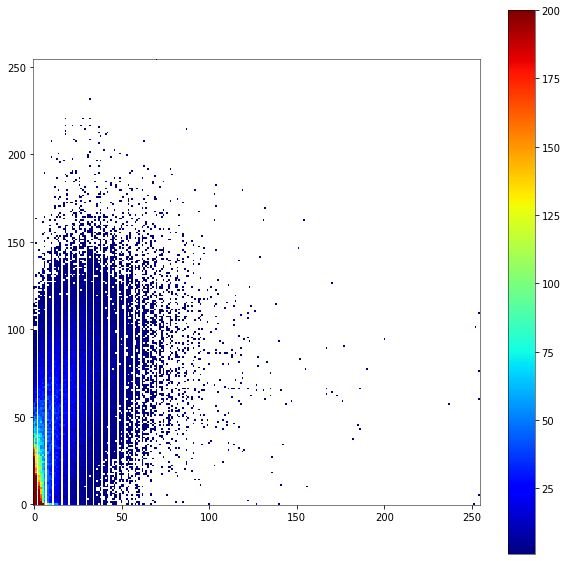

In [145]:
matplotlib.rc('axes',edgecolor='k',linewidth=0.5)
Hc, xedges, yedges = np.histogram2d(np.reshape(bytescale(Reco_c), (-1)), 
                                   np.reshape(bytescale(gt), (-1)), 
                                   bins=(255, 255))
Hmasked_c=np.ma.masked_where(Hc==0,Hc)
Hd, xedges, yedges = np.histogram2d(np.reshape(bytescale(Reco_d), (-1)), 
                                   np.reshape(bytescale(gt), (-1)), 
                                   bins=(255, 255))
Hmasked_d=np.ma.masked_where(Hd==0,Hd)

plt.figure(figsize=(10,10))
plt.imshow(Hmasked_c, origin=True,vmax=200, cmap='jet')
plt.colorbar()
plt.savefig('../Shareloc/{}/hist2d_{}_{}_{}_{}_{}_legendnormolized_m1.svg'.format(savedir,
                                                                           x0,y0,x1,y1,today),
            transparent=False)
plt.figure(figsize=(10,10))
plt.imshow(Hmasked_d, origin=True,vmax=200, cmap='jet')
plt.colorbar()
plt.savefig('../Shareloc/{}/hist2d_{}_{}_{}_{}_{}_legendnormolized_m7.svg'.format(savedir,
                                                                           x0,y0,x1,y1,today),
            transparent=False)


96303.0

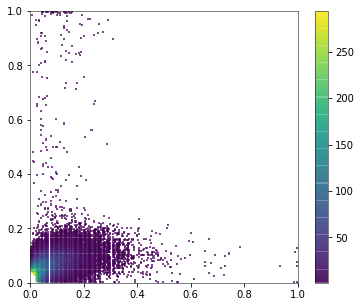

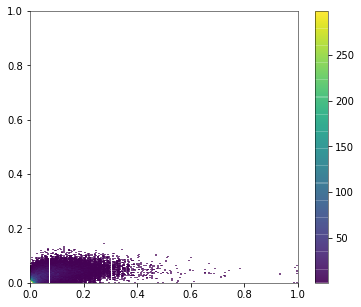

In [146]:
plt.figure(figsize=(6,5))

plt.hist2d(y=np.reshape((Reco_c), (-1)), 
           x =np.reshape((gt), (-1)), 
           bins=255, cmin=0.1, cmax=300, alpha=0.7)
plt.xlim(0,1)
plt.ylim(0,1)
plt.colorbar()
plt.savefig('../Shareloc/{}/hist2d_{}_{}_{}_{}_{}_legendnormolized_m60.svg'.format(savedir,
                                                                           x0,y0,x1,y1,today),
            transparent=False)
plt.figure(figsize=(6,5))
plt.hist2d(y=np.reshape((Reco_d), (-1)), 
             x =np.reshape((gt), (-1)), 
                                   bins=255, cmin=0.1, cmax=300, alpha=0.7)
plt.xlim(0,1)
plt.ylim(0,1)
plt.colorbar()
plt.savefig('../Shareloc/{}/hist2d_{}_{}_{}_{}_{}_legendnormolized_m7.svg'.format(savedir,
                                                                           x0,y0,x1,y1,today),
            transparent=False)

In [72]:
xedges.max()

0.14517289400100708

In [24]:
DirBase_c = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/__images__/outputs/'
DirBase_d = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/ssSIN/noco/__images__/outputs/'

DirGT = DirBase_d
#DirGT = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/GT_Singapour/sep/'
fact = 10
name_ind = 1
line = (170,425, 195,447)
#line = (0,0, 0,0)

zoom_cord = (150,410)

outputs_shareloc(DirGT = DirGT,
                 DirBase_c = DirBase_c, 
                 DirBase_d = DirBase_d,
                 fact = fact,
                 zoom_cord=zoom_cord, 
                 line = line,
                 zoomsize = 50,
                 chopsize = 512, 
                 FrameNb = 300, 
                 name_ind=name_ind, 
                 add_title = False, 
                 save_fig = False, 
                 show_zoom = True,
                 norm = True,
                 savedir = 'quantity_only',
                 title_c = 'Merged,trained on 1_5', 
                 title_d = 'Merged,trained on 60imags')

../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/__images__/outputs/
['Noco_merged_filtered' 'Noco_merged_filtered_ssWF']
['Noco_merged_filtered_ssWF.csv_A_0_(501, 801).png_real_B_b0_i0.tif']
(640, 640)


/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:68: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:70: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:71: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


ssim_raw_1 :  0.7722648462548325 ssim_raw_2 :  0.9681372272679427


IndexError: index -9223372036854775808 is out of bounds for axis 0 with size 512

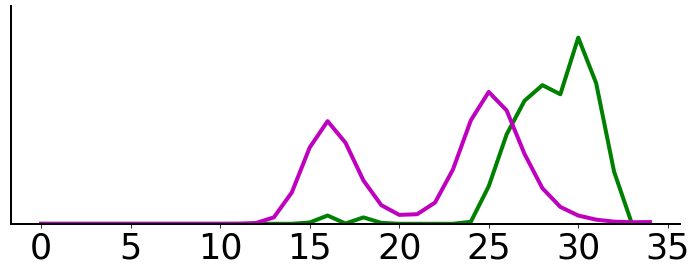

In [301]:
#ax = plt.figure(figsize=(7, 5))
#fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12, 4))
savedir = "noco"
zoomsize = 50
#line = (215,200, 255,245)
x0,y0,x1,y1 = line
x0,y0,x1,y1 = line

(wf, histin, gt, Merged_c, Merged_d,Reco_c,Reco_d) = __data['results_images']
#Reco_c = align_image(Reco_c,gt)
#Reco_d = align_image(Reco_d,gt)

profile_gt = profile_line(gt,(y0,x0),(y1,x1), linewidth=5)
profile_c = profile_line((Reco_c/Reco_c.sum())*gt.sum(),(y0,x0),(y1,x1), linewidth=5)
#profile_c = profile_line(Reco_c,(y0,x0),(y1,x1), linewidth=5)

profile_d = profile_line((Reco_d/Reco_d.sum())*gt.sum(),(y0,x0),(y1,x1), linewidth=5)  
#profile_d = profile_line(Reco_d,(y0,x0),(y1,x1), linewidth=5)  

matplotlib.rc('axes',edgecolor='k',linewidth=2)
lw = 4
plt.plot(profile_gt,color='green',lw = lw)
#plt.plot(profile_c,color='m',ls = '--',lw = lw)
plt.plot(profile_c,color='m',lw = lw)

#plt.plot(profile_d,color='m',lw = lw)
#ax.xaxis.tick_top()
#ax.yaxis.tick_right()
plt.xticks(fontsize=35)
#plt.xticks([])

plt.yticks(fontsize=35)
#
plt.yticks([])

plt.ylim(0,0.05)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

"""
plt.legend(("Ground truth","Model Ouyang2019","Model 4"),
           fontsize=35,
           loc='upper left', 
           ncol=1, bbox_to_anchor=(1.5, 1),
            borderaxespad=0.)

"""
#ax.invert_yaxis()
#ax.invert_xaxis()
plt.axis('on')
from datetime import date
today = str(date.today()).replace("-", "_")
plt.savefig('../Projects/Shareloc/{}/profilline_quantity_{}_{}_{}_{}_{}_Nnormolized_c.svg'.format(savedir,
                                                                           x0,y0,x1,y1,today),
            transparent=False)

../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/diversity/O18/test_on_K/438000/outputs
['200729_REF52_lvl11_MT_006' '200729_REF52_lvl11_MT_010'
 '200729_REF52_lvl11_MT_012' '200729_REF52_lvl11_MT_016'
 '200729_REF52_tubulinalpha_MT_005' '200729_REF52_tubulinalpha_MT_006'
 '200729_REF52_tubulinalpha_MT_007' '200729_REF52_tubulinalpha_MT_008'
 '200729_REF52_tubulinalpha_MT_010' '200729_REF52_tubulinalpha_MT_012'
 '200730_MDCK_MT_002' '200730_MDCK_MT_003' '200730_REF52_MT_002'
 '200730_REF52_MT_003' '200730_REF52_MT_004' '200730_REF52_MT_005'
 '200730_REF52_MT_006']
['200729_REF52_tubulinalpha_MT_008.csv_A_0_(1, 301).png_real_B_b0_i0.tif']
(128, 128)
ssim_raw_1 :  0.7484001143114233 ssim_raw_2 :  0.9554698203147164
1.0
40.147076 2.3115757 20.0
ploting
b vmax: 3.0


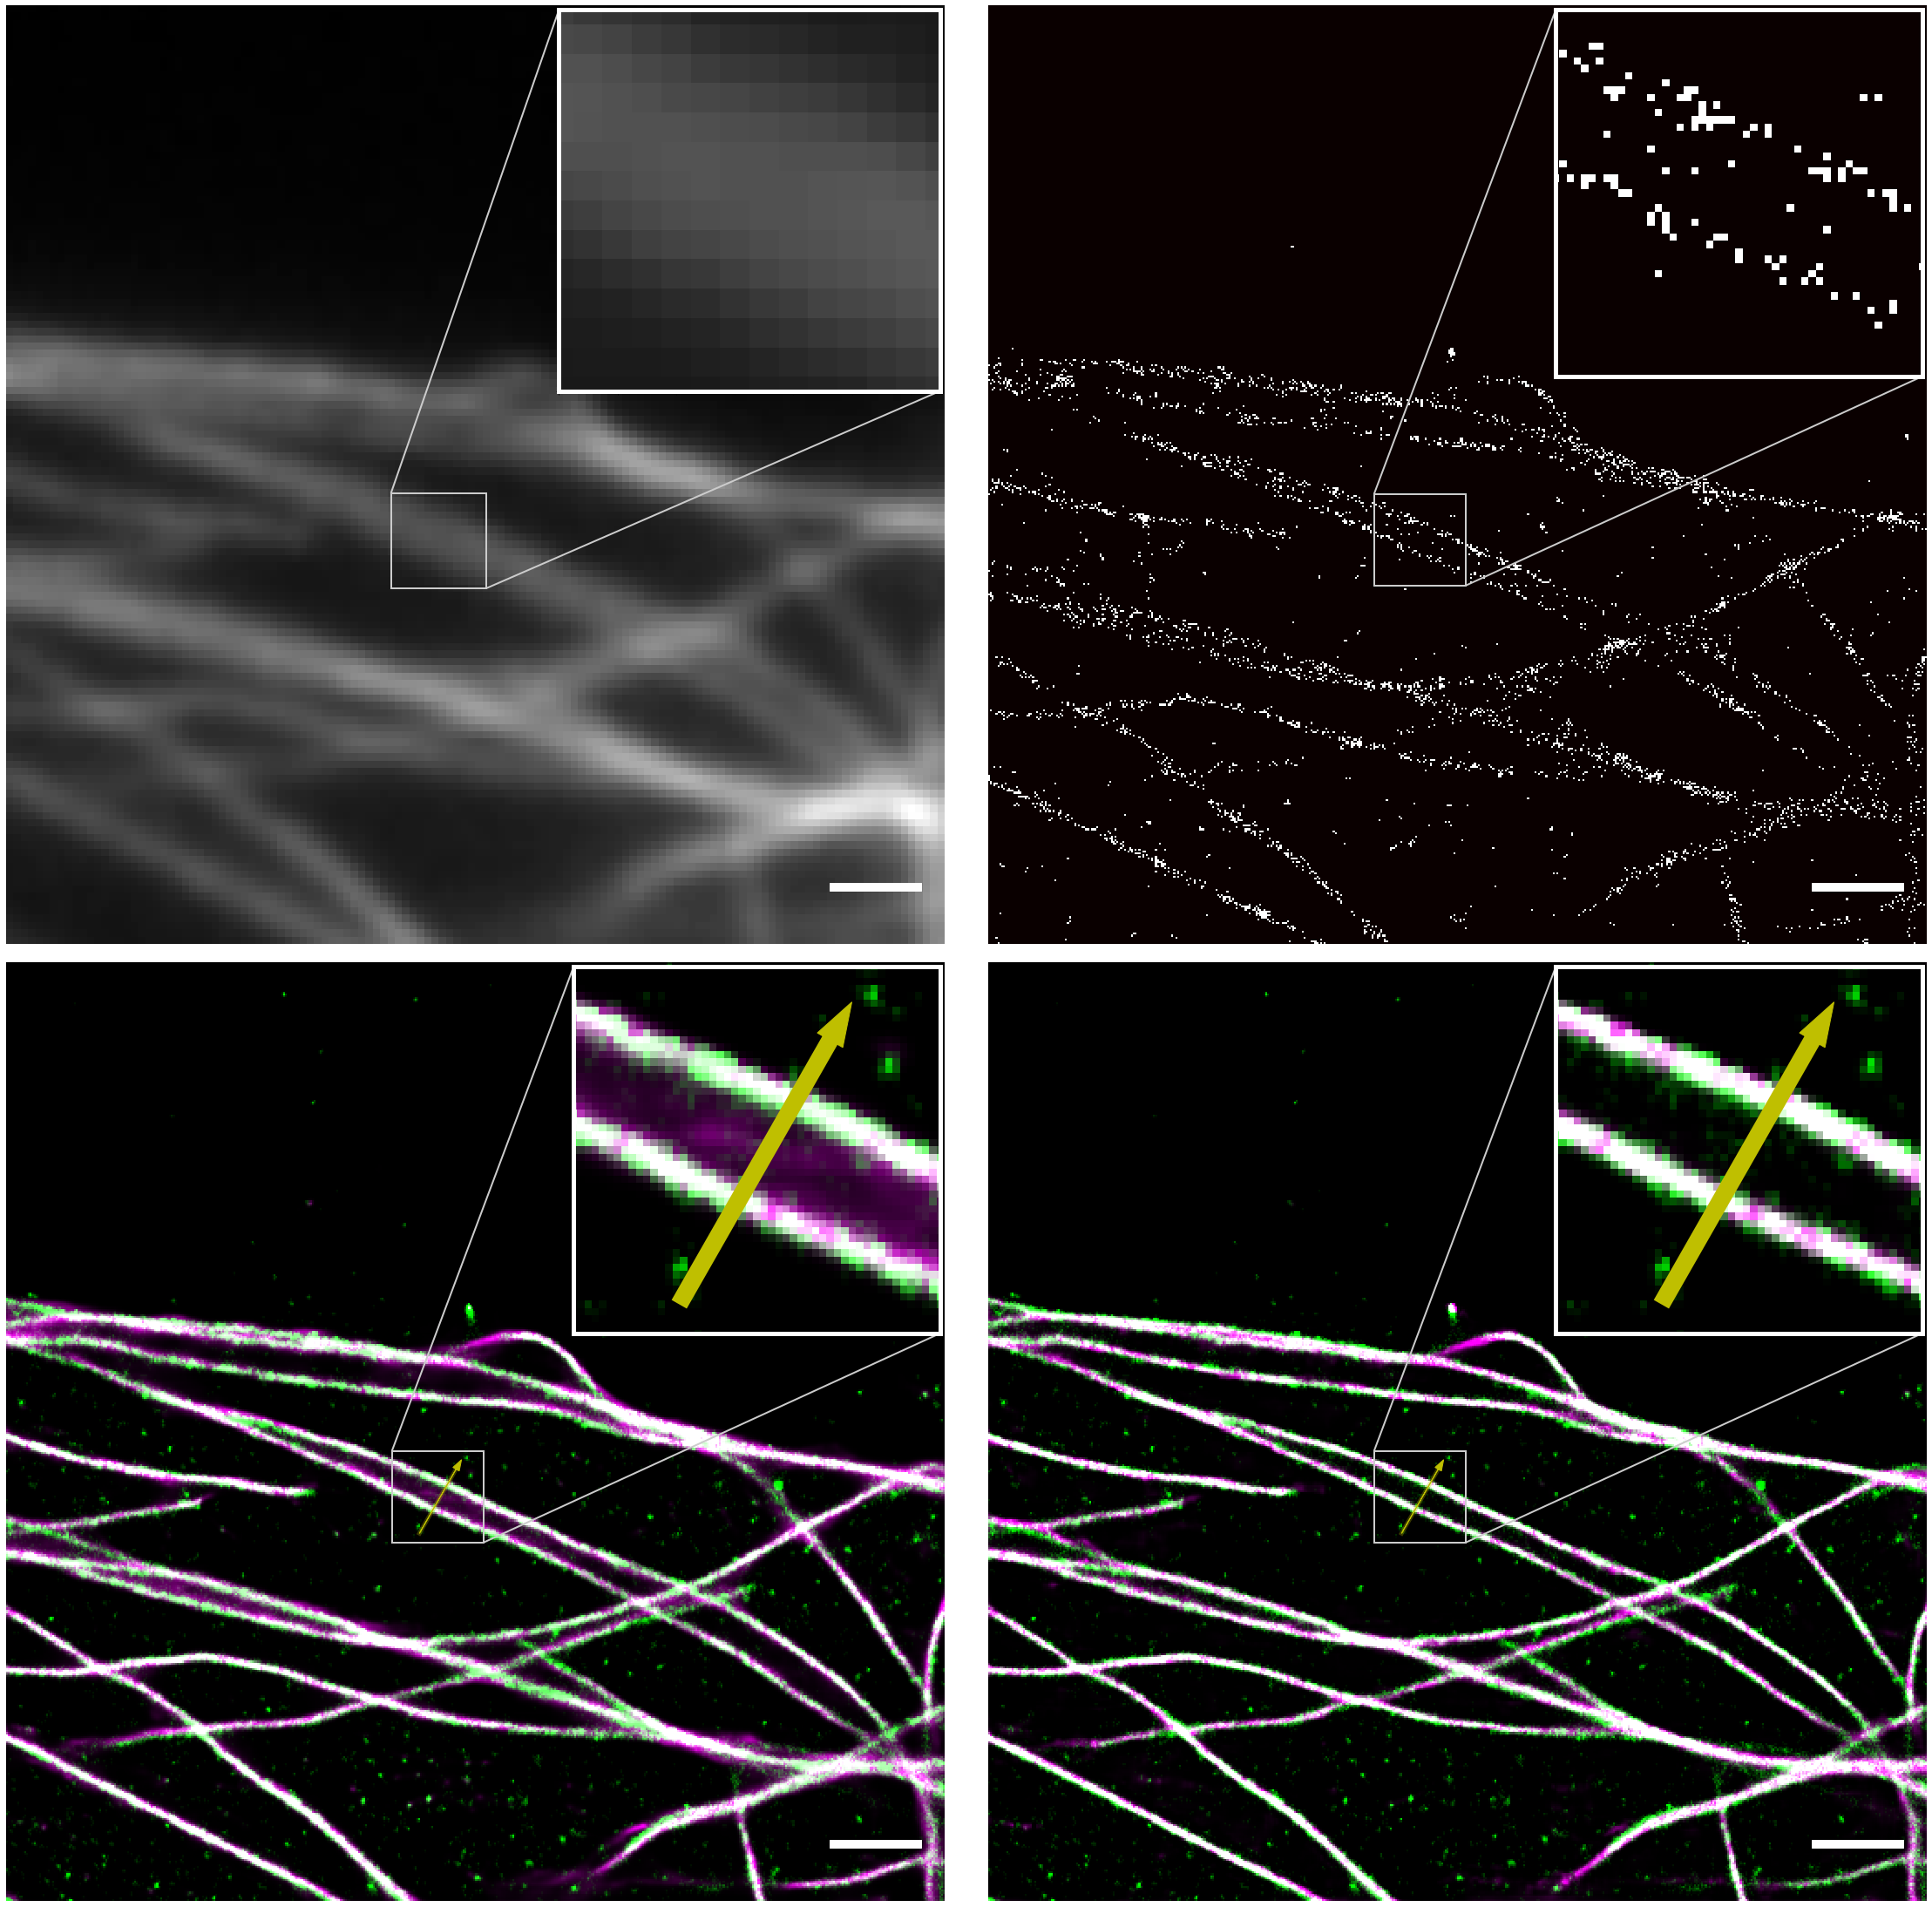

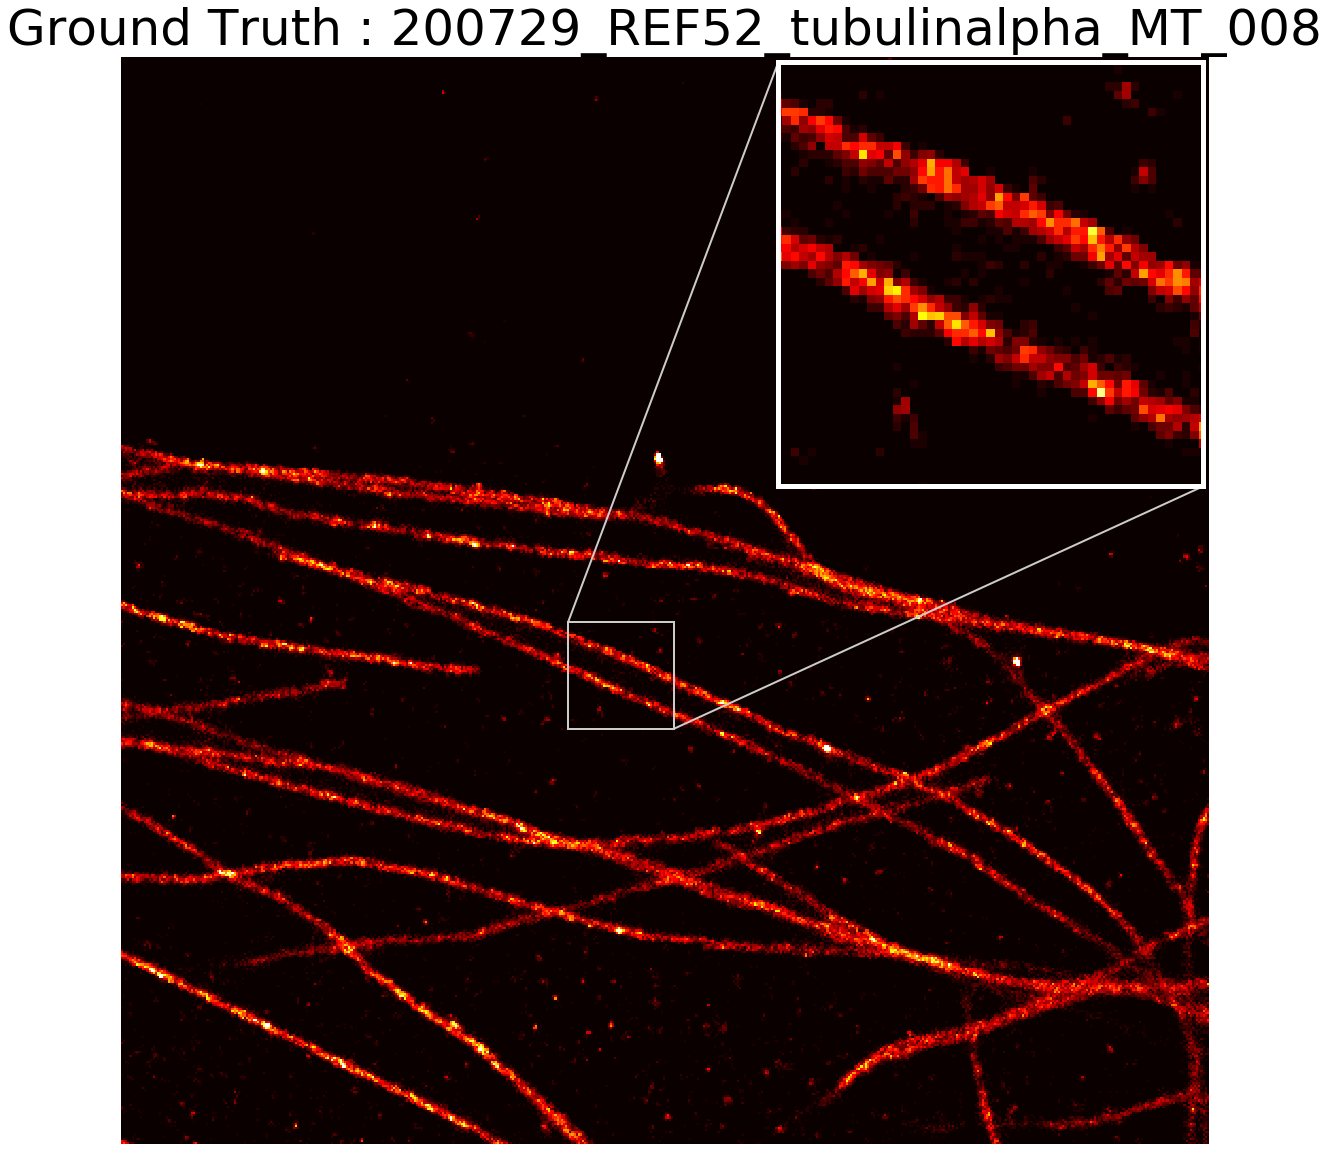

In [29]:
name_ind = 7
zoom_cord = (190,265)
zoom_cord = (210,195)
line = (225,200,225+20, 195+40)
fact = 20

DirBase_d = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/diversity/K_tr_A2_L2_Z1_S2/438000/outputs/'
DirBase_c = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/diversity/O18/test_on_K/438000/outputs'
#DirBase_c = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/diversity/trained_on_imod/test_on_K/__images__/outputs/'
#DirBase_d = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/diversity/K_tr_A2_L2_Z1_S2/__images__/outputs/'
#DirGT = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/TestOnAbbelight_ImodOnly_nonBlur/outputs/'
DirGT = DirBase_d
outputs_shareloc(DirGT = DirGT,
                 DirBase_c = DirBase_c, 
                 DirBase_d = DirBase_d,
                 fact = fact, 
                 zoom_cord=zoom_cord, 
                 line = line,
                 zoomsize = 50,
                 chopsize = 512, 
                 FrameNb = 300, 
                 name_ind=name_ind, 
                 add_title = False, 
                 save_fig = True, 
                 show_zoom = True,
                 norm = True,
                 savedir="diversity_only",
                 title_c = 'Merged,trained on IMOD', 
                 title_d = 'Merged,trained on 4Labs')

In [30]:
def plot_image1(zoom_lim = (150, 180, 190, 220), 
                line = (215,200, 255,240),
                add_title=True, save_fig=False, show_zoom=True,
                savedir = "figs",
                name = 'ANNA-PALM_model',
                title_c = 'Merged,trained on IMOD', 
                title_d = 'Merged,trained on 3Labs'):
    print('ploting')
    (wf, histin, gt, Merged_c, Merged_d,Reco_c,Reco_d) = __data['results_images']
    zoom_rate = 4 #10  #4
    font_size = 45
    loc1=4  #4
    loc2=2
    loc=3
    fontsize=45
    zoomsize = 50
    zoom_lim_2=350,50,350+50,50+50
    #x0 = 210+5#60
    #y0 = 195+5#20
    #x1 = 210-5+zoomsize#350
    #y1 = 195-5+zoomsize#350
    x0,y0,x1,y1 = line
    plt.figure(figsize=(40, 40))
    gs = gridspec.GridSpec(2,2)
    gs.update(wspace=0.02, hspace=0.02) # set the spacing between axes.
    matplotlib.rc('axes',edgecolor='w',linewidth=5)

    #-------------input-target---------------

    plt.subplot(gs[0])
    plt.axis('off')
    plt.imshow(wf,  interpolation="nearest",
              origin="lower", cmap='gray', vmin=0)
    if add_title:
        plt.title('a. wide-field', fontsize=fontsize)
    scalebar(scale_factor=1000/pixel_size/4,down_scale=2)
    if show_zoom:
        zoom(wf, list(np.array(zoom_lim)//4),list(np.array(zoom_lim_2)//4),
             zoom_rate, loc=loc, loc1=loc1, loc2=loc2, cmap='gray', vmin=0)



#     if histin.max() >= 10/255:
#         histin = exposure.equalize_hist(histin)
#         vmax_in = None
#     else:
    vmax_in = 3/255

    plt.subplot(gs[1])
    plt.axis('off')
    scalebar(scale_factor=1000/pixel_size,down_scale=0.5)
    plt.imshow(histin,
               origin="lower", cmap='hot', vmin=0, vmax=vmax_in)
    if add_title:
        plt.title('b. PALM(k={})'.format(frame_num), fontsize=fontsize)
    if show_zoom:
        zoom(histin, zoom_lim, zoom_lim_2,
             zoom_rate, loc=loc, loc1=loc1, 
             loc2=loc2, cmap='hot', vmin=0, vmax=vmax_in)

    print('b vmax:', vmax_in*255)


    #-------------merged---------------

    ax2 = plt.subplot(gs[2])
    plt.axis('off')
    plt.imshow(Merged_c,origin="lower")
    plt.plot([x0, x1], [y0, y1], 'y-',linewidth=5,alpha = 0.3)
    plt.arrow(x0, y0, (x1-x0), (y1-y0), fc='y', ec='y',head_width=4)
    if add_title:
        plt.title('c. {}'.format(title_c), fontsize=fontsize)
    #scalebar()
    scalebar(scale_factor=1000/pixel_size,down_scale=0.5)
    if show_zoom:
        #zoom(Merged_c, zoom_lim, zoom_rate, loc=loc, loc1=loc1, loc2=loc2)
        zoom_line(Merged_c,lim=zoom_lim,line=(x0,y0,x1,y1),
                  zoom=zoom_rate,loc=loc,loc1=loc1,loc2=loc2,
                  cmap='hot',vmin=0,vmax=1,c='y')


    ax3 = plt.subplot(gs[3])
    plt.axis('off')
    #scalebar()
    scalebar(scale_factor=1000/pixel_size,down_scale=0.5)
    plt.imshow(Merged_d,origin="lower")
    plt.plot([x0, x1], [y0, y1], 'y-',linewidth=5,alpha = 0.3)
    plt.arrow(x0, y0, (x1-x0), (y1-y0), fc='y', ec='y',head_width=4)
    if add_title:
        plt.title('d. {}'.format(title_d), fontsize=fontsize)
    if show_zoom:
        #zoom(Merged_d, zoom_lim, zoom_rate,loc=loc, loc1=loc1, loc2=loc2)
        zoom_line(Merged_d,lim=zoom_lim,line=(x0,y0,x1,y1),
                  zoom=zoom_rate,loc=loc,loc1=loc1,loc2=loc2,
                  cmap='hot',vmin=0,vmax=1,c='y')

    if save_fig:
        from datetime import date
        today = str(date.today()).replace("-", "_")
        
        if not os.path.exists('../Shareloc/{}/'.format(savedir)):
            os.makedirs('../Shareloc/{}/'.format(savedir))
        # model_no = os.path.split(MODEL_DIR)[1].split('-')[0]
        # model_no = MODEL_DIR[18:-10]
        plt.savefig('../Shareloc/{}/{}frames_{}_{}_{}.svg'.format(savedir, int(frame_num),
                                                                                   name, zoom_lim,
                                                                                   today),
                    transparent=False)
        # plt.clf()


In [13]:
def zoom(image, lim, lim2=(300,50,350,100), zoom=3, loc=2, loc1=2, loc2=4, **kwargs):
    # --------
    ax = plt.gca()
    axins = zoomed_inset_axes(ax, zoom, loc=loc) # zoom = 6

    axins.imshow(np.array(image), interpolation="nearest",
          origin="lower", **kwargs)
    # sub region of the original image
    x1, y1, x2, y2 = lim
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)
    axins1 = zoomed_inset_axes(ax, zoom, loc=1) # zoom = 8
    
    axins1.imshow(image, interpolation="nearest",
          origin="lower", **kwargs)
    x1, x2, y1, y2 = lim2
    axins1.set_xlim(x1, x2)
    axins1.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)


    # draw a bbox of the region of the inset axes in the parent axes and
    # connecting lines between the bbox and the inset axes area
    mark_inset(ax, axins, loc1=loc1, loc2=loc2, fc="none", ec="0.8", lw=2)
    mark_inset(ax, axins1, loc1=loc1, loc2=loc2, fc="none", ec="0.5", lw=2)



In [14]:
def zoom_line_1(image, lim, line, c ='y',zoom=3, loc=2, loc1=2, loc2=4, **kwargs):
    # --------
    ax = plt.gca()
    axins = zoomed_inset_axes(ax, zoom, loc=loc) # zoom = 6
    x0,y0,x1,y1 = line
    axins.imshow(image, interpolation="nearest",
          origin="lower", **kwargs)
    axins.plot([x0, x1], [y0, y1], '{}-'.format(c),linewidth=5*zoom,alpha = 1)
    axins.plot([x0, x1], [y0, y1], '{}-'.format(c),linewidth=1*zoom)
    axins.arrow(x0, y0, (x1-x0), (y1-y0), fc='y', ec='y',head_width=zoom)
    # sub region of the original image
    x1, y1, x2, y2 = lim
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)
    axins1 = zoomed_inset_axes(ax, zoom, loc=1) # zoom = 6
    x0,y0,x1,y1 = 350,50,350+50,50+50
    axins1.imshow(image, interpolation="nearest",
          origin="lower", **kwargs)
    axins1.plot([x0, x1], [y0, y1], '{}-'.format(c),linewidth=5*zoom,alpha = 1)
    axins1.plot([x0, x1], [y0, y1], '{}-'.format(c),linewidth=1*zoom)
    axins1.arrow(x0, y0, (x1-x0), (y1-y0), fc='y', ec='y',head_width=zoom)
    # sub region of the original image
    x1, y1, x2, y2 = 350,50,350+50,50+50
    axins1.set_xlim(x1, x2)
    axins1.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)

    # draw a bbox of the region of the inset axes in the parent axes and
    # connecting lines between the bbox and the inset axes area
    mark_inset(ax, axins1, loc1=loc1, loc2=loc2, fc="none", ec="0.8", lw=2)

../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/quantity_shareloc/7Juin2021/trained_on_1/outputs/
['160530_C2C1_MT2D_2377K' '160530_C4C1_MT2D_1363K' '160603_C2C1_MT2D_814K'
 '160603_C2C2_MT2D_661K' '160603_C2C3_MT2D_801K' '170720_C1C1_MT2D_4133K'
 '170822_C1C2_MT2D_3260K' '170907_C2C3_MT2D_3059K'
 '170914_C1C3_MT2D_3252K' '170914_C1C4_MT2D_2713K'
 '170914_C1C5_MT2D_3748K' '170914_C1C6_MT2D_1820K']
['170907_C2C3_MT2D_3059K.csv_A_0_(1, 301).png_real_B_b0_i0.tif']
(128, 128)
ssim_raw_1 :  0.8694781294397977 ssim_raw_2 :  0.9569640209920053
1.0
2.8201234 5.275526 20.0
ploting
b vmax: 3.0


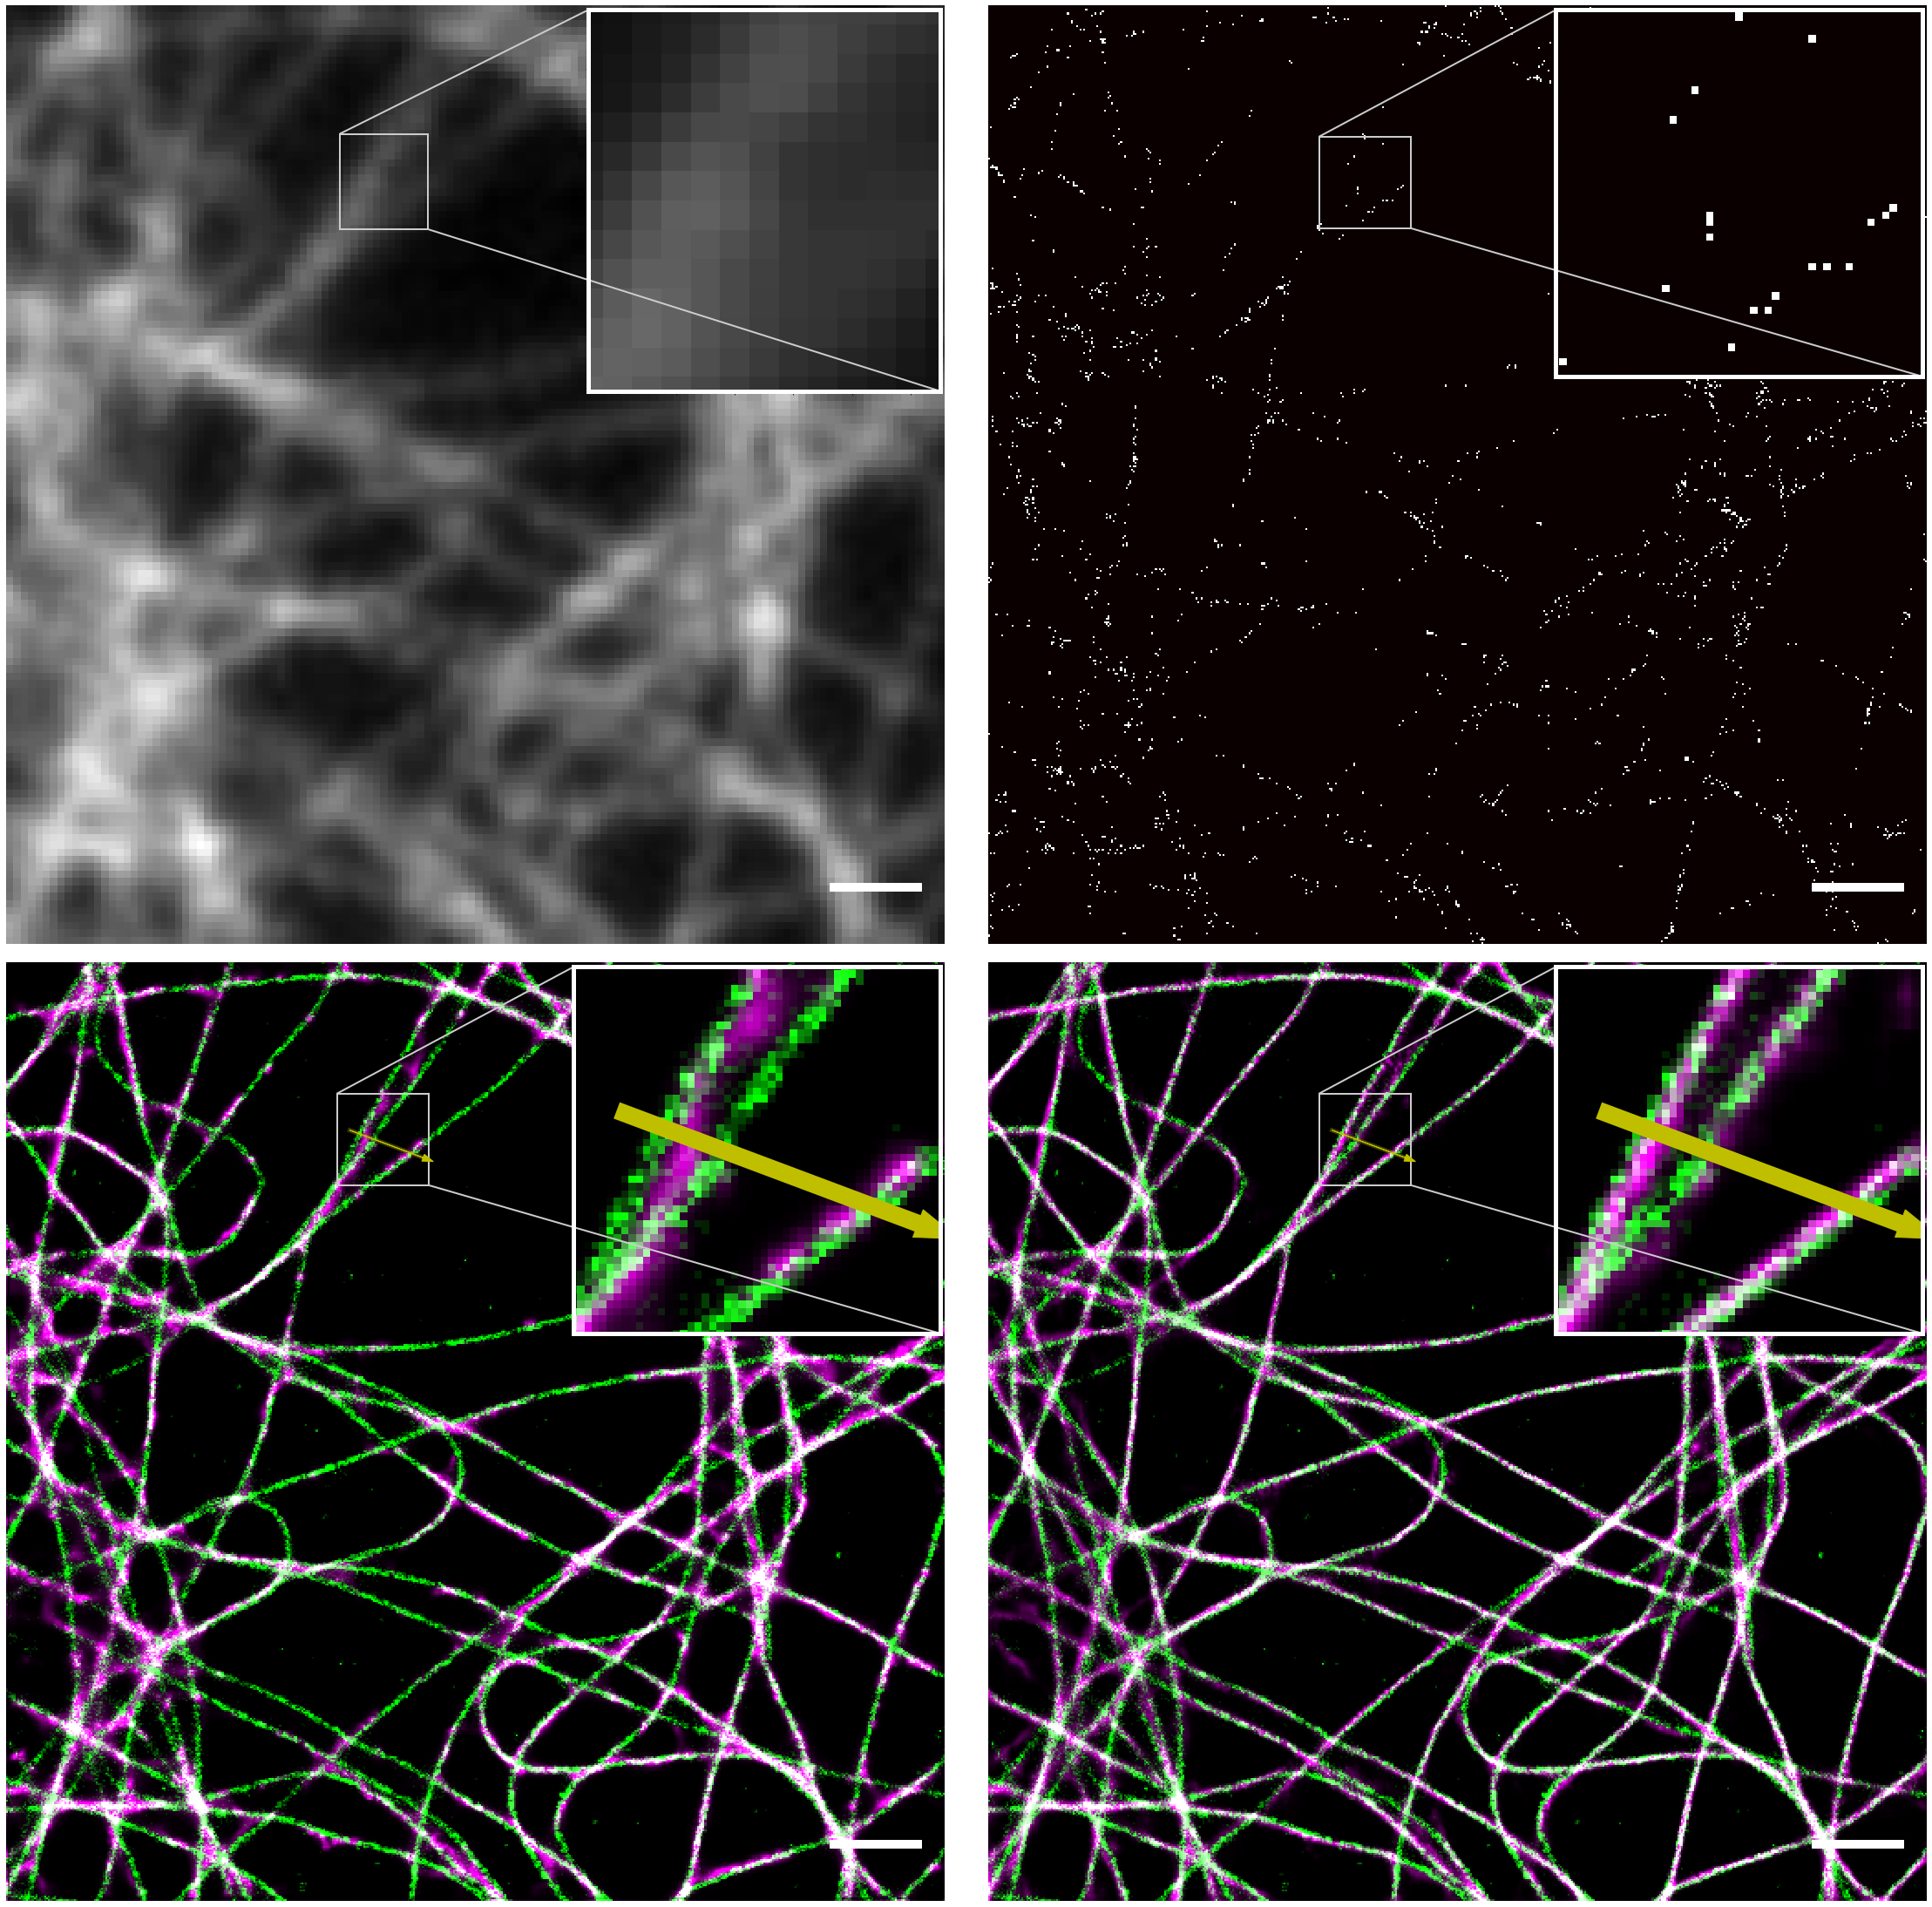

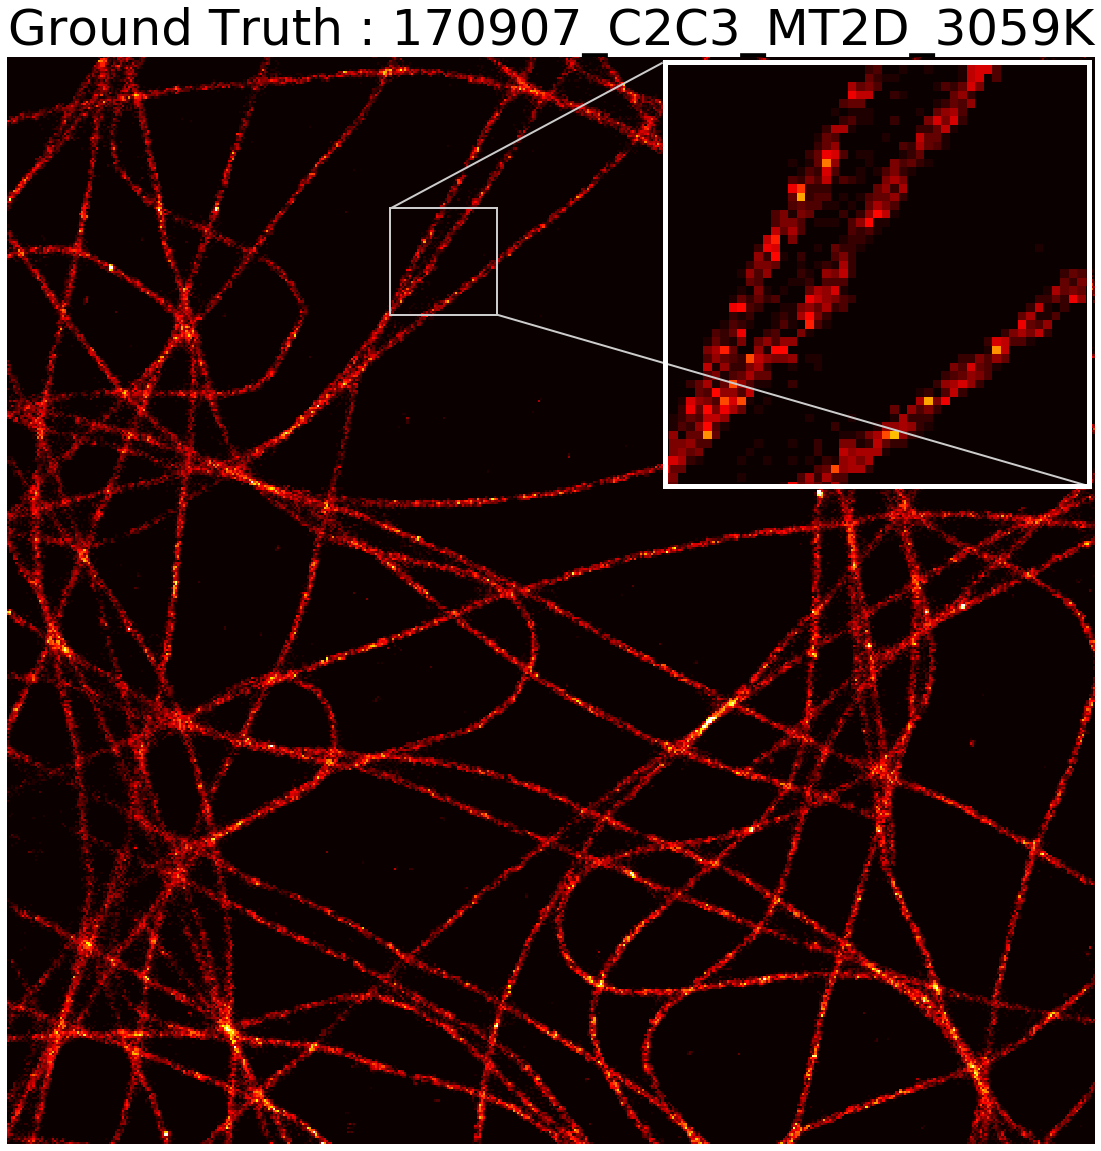

In [115]:
name_ind = 7
crop_cord = (0,0)
zoom_cord = (190,265)
zoom_cord = (180,390)
line = (187,420,187+40, 405)

DirBase_c = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/diversity/trained_on_imod/__images__/outputs/'
DirBase_d = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/diversity/tained_on_2CL2Imod3Sauer/__images__/outputs/'
DirBase_c = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/quantity_shareloc/7Juin2021/trained_on_1/outputs/'
DirBase_d = '../../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/quantity_shareloc/7Juin2021/trained_on_43/outputs/'

#DirGT = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/TestOnAbbelight_ImodOnly_nonBlur/outputs/'
DirGT = DirBase_d
outputs_shareloc(DirGT = DirGT,
                 DirBase_c = DirBase_c, 
                 DirBase_d = DirBase_d,
                 fact = fact,
                 crop_cord = crop_cord, 
                 zoom_cord=zoom_cord, 
                 line = line,
                 zoomsize = 50,
                 chopsize = 512, 
                 FrameNb = 300, 
                 name_ind=name_ind, 
                 add_title = False, 
                 save_fig = True, 
                 show_zoom = True,
                 norm = True,
                 savedir = "quantity_only",
                 title_c = 'Merged,trained on CL1', 
                 title_d = 'Merged,trained on CL43')

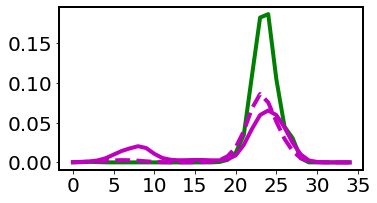

In [45]:
#ax = plt.figure(figsize=(7, 5))
#fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12, 3))
plt.subplot(121)
savedir = "noco"
zoomsize = 50
#line = (215,200, 255,245)
x0,y0,x1,y1 = line
x0,y0,x1,y1 = line

(wf, histin, gt, Merged_c, Merged_d,Reco_c,Reco_d) = __data['results_images']
profile_gt = profile_line(gt,(y0,x0),(y1,x1), linewidth=5)
profile_c = profile_line((Reco_c/Reco_c.sum())*gt.sum(),(y0,x0),(y1,x1), linewidth=5)
#profile_c = profile_line(Reco_c,(y0,x0),(y1,x1), linewidth=5)

profile_d = profile_line((Reco_d/Reco_d.sum())*gt.sum(),(y0,x0),(y1,x1), linewidth=5)  
#profile_d = profile_line(Reco_d,(y0,x0),(y1,x1), linewidth=5)  

matplotlib.rc('axes',edgecolor='k',linewidth=2)
lw = 4
plt.plot(profile_gt,color='green',lw = lw)
plt.plot(profile_c,color='m',ls = '--',lw = lw)
plt.plot(profile_d,color='m',lw = lw)
#ax.xaxis.tick_top()
#ax.yaxis.tick_right()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.ylim(0,0.06)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)


"""plt.legend(("Ground truth","Model 1 img","Model 60 img"),
           fontsize=20,
           loc='upper center', 
           ncol=3, bbox_to_anchor=(1, 1.2),
           borderaxespad=0.)"""

"""
"""
#ax.invert_yaxis()
plt.axis('on')
from datetime import date
today = str(date.today()).replace("-", "_")
plt.savefig('../Shareloc/{}/profilline_quantity_{}_{}_{}_{}_{}_legendnormolized.svg'.format(savedir,
                                                                           x0,y0,x1,y1,today),
            transparent=False)

In [35]:
from datetime import date

today = date.today()
str(today).replace("-", "_")

20210610

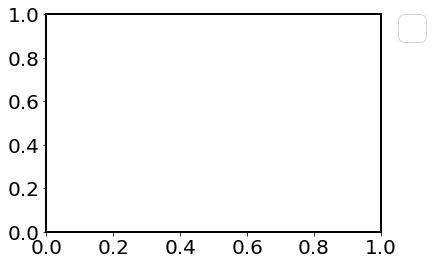

In [367]:
plt.legend(("Ground truth","Model 1","Model 5"),
           fontsize=35,
           loc='upper left', 
           ncol=1, bbox_to_anchor=(1.05, 1),
            borderaxespad=0.)

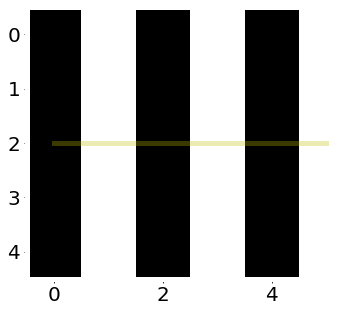

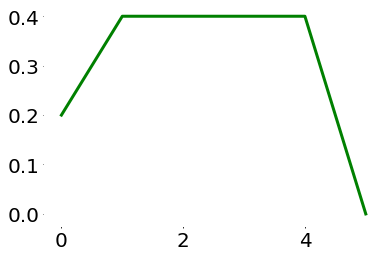

In [293]:
test = np.asarray([[0,1,0,1,0],[0,1,0,1,0],[0,1,0,1,0],[0,1,0,1,0],[0,1,0,1,0]])
plt.figure(figsize=(15, 5))
line = (0,2, 5,2)
x0,y0,x1,y1 = line
(wf, histin, gt, Merged_c, Merged_d,Reco_c,Reco_d) = __data['results_images']
profile_gt = profile_line(test,(y0,x0),(y1,x1), linewidth=5) 
profile_gt = profile_line(test,(x0,y0),(x1,y1), linewidth=5) 

plt.imshow(test,cmap='gray')
#plt.plot([y0, y1],[x0, x1], 'y-',linewidth=5,alpha = 0.3)
plt.plot([x0, x1], [y0, y1],'y-',linewidth=5,alpha = 0.3)
plt.show()
lw = 3
plt.plot(profile_gt,color='green',lw = lw)

In [ ]:
name_ind = 9
name_ind = 3
crop_cord = (0,0)
zoom_cord = (1150,1450)
zoom_cord = (450,950)
zoom_cord = (130,900)
zoom_cord = (200,60)
#zoom_cord = (1100,130)
DirBase_d = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/Manish/DC/outputs/'
DirBase_c = DirBase_d
#DirBase_c = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/ssCL/__images__/outputs/'

#DirBase_d = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/ssABBE/outputs/'
DirGT = DirBase_d
#DirGT = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/GT_Singapour/sep/'
fact = 20
outputs_shareloc(DirGT = DirGT,
                 DirBase_c = DirBase_c, 
                 DirBase_d = DirBase_d,
                 fact = fact,
                 crop_cord = crop_cord, 
                 zoom_cord=zoom_cord, 
                 zoomsize = 50,
                 chopsize = 1280, 
                 FrameNb = 300, 
                 name_ind=name_ind, 
                 add_title = False, 
                 save_fig = True, 
                 show_zoom = True,
                 norm = True,
                 title_c = 'Merged,trained on IMOD', 
                 title_d = 'Merged,trained on 4Labs')


In [ ]:
name_ind = 7
crop_cord = (0,0)
zoom_cord = (1150,1450)
zoom_cord = (450,950)
zoom_cord = (200,200)
DirBase_d = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/ssSIN/'
DirBase_c = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/2000epoch/noco/__images__/outputs/'
DirGT = DirBase_d
#DirGT = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/GT_Singapour/sep/'
fact = 20
outputs_shareloc(DirGT = DirGT,
                 DirBase_c = DirBase_c, 
                 DirBase_d = DirBase_d,
                 fact = fact,
                 crop_cord = crop_cord, 
                 zoom_cord=zoom_cord, 
                 zoomsize = 50,
                 chopsize = 512, 
                 FrameNb = 300, 
                 name_ind=name_ind, 
                 add_title = False, 
                 save_fig = True, 
                 show_zoom = True,
                 norm = True,
                 title_c = 'Merged,trained on IMOD', 
                 title_d = 'Merged,trained on 4Labs')


/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


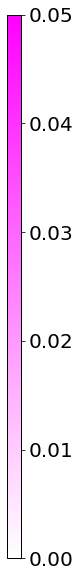

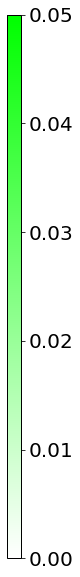

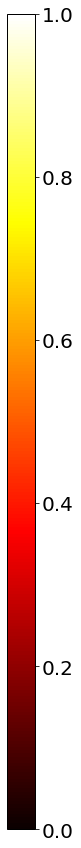

In [154]:
import matplotlib.pyplot as plt
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(0.25, 10))
#fig.subplots_adjust(bottom=0.5)
#cmap = mpl.cm.cool
mpl.rc('axes',edgecolor='k',linewidth=1)
cmap = mpl.colors.LinearSegmentedColormap.from_list('magenta', ['#ffffff','#ff00ff'], N=256)
norm = mpl.colors.Normalize(vmin=0, vmax=1/(fact))

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
plt.savefig('..//Shareloc/sup_04_juin_2021/magenta_fact{}.svg'.format(fact),
                    transparent=True)
fig.show()
fig, ax = plt.subplots(figsize=(0.25, 10))
#fig.subplots_adjust(bottom=0.5)
cmap = mpl.colors.LinearSegmentedColormap.from_list('vert', ['#ffffff','#00ff00'], N=256)
norm = mpl.colors.Normalize(vmin=0, vmax=1/(fact))

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
plt.savefig('../Shareloc/sup_04_juin_2021/green_fact{}.svg'.format(fact*gt.sum()),
                    transparent=True)
fig.show()
mpl.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(0.5, 15))
#fig.subplots_adjust(bottom=0.5)
cmap = mpl.cm.hot
norm = mpl.colors.Normalize(vmin=0, vmax=1)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
#plt.axis('off')
fig.show()
mpl.rcParams.update({'font.size': 20})



/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


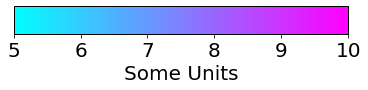

In [210]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=5, vmax=10)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Some Units')
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
fig.show()

In [53]:
(Reco_c/(Reco_c.sum())*(gt.sum())).max()*fact

2.893799841403961

In [837]:
name_ind =  24
crop_cord = (0,0)
zoom_cord = (190,120)
#DirBase_c = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/TestOnAbbelight_ImodOnly_nonBlur/outputs/'
#DirBase_d = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/TestOnAbbelight_3labs_nonBlur/outputs/'
DirBase_c = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/test_on_SIM/__images__/outputs/'
#DirBase_d = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/ssABBE/test_on_SIM/__images__/outputs/'
DirBase_d = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/ssCL/test_on_SIM/__images__/outputs/'
DirBase_d = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/ssSAUER/test_on_SIM/__images__/outputs/'
DirBase_d = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/ssSIN/test_on_SIM/__images__/outputs/'

DirGT = DirBase_d
#DirGT = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/GT_Singapour/sep/'

outputs_shareloc_sim(DirGT = DirGT,
                     DirBase_c = DirBase_c, 
                     DirBase_d = DirBase_d,
                     fact = 25,
                     crop_cord = crop_cord, 
                     zoom_cord=zoom_cord, 
                     zoomsize = 50,
                     chopsize = 512, 
                     FrameNb = 300, 
                     name_ind=name_ind, 
                     add_title = False, 
                     save_fig = False, 
                     show_zoom = False,
                     title_c = 'Merged,trained on IMOD', 
                     title_d = 'Merged,trained on 4Labs')

FileNotFoundError: [Errno 2] No such file or directory: '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/test_on_SIM/__images__/outputs/'

../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/test_on_CL/__images__/outputs/
170914_C4C3_MT2D_1458K
['170914_C4C3_MT2D_1458K.csv_A_0_(1, 301).png_real_A_b0_i0.tif']
(512, 512)
ploting
b vmax: 2.0


/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:75: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
/home/jiachuan/.local/lib

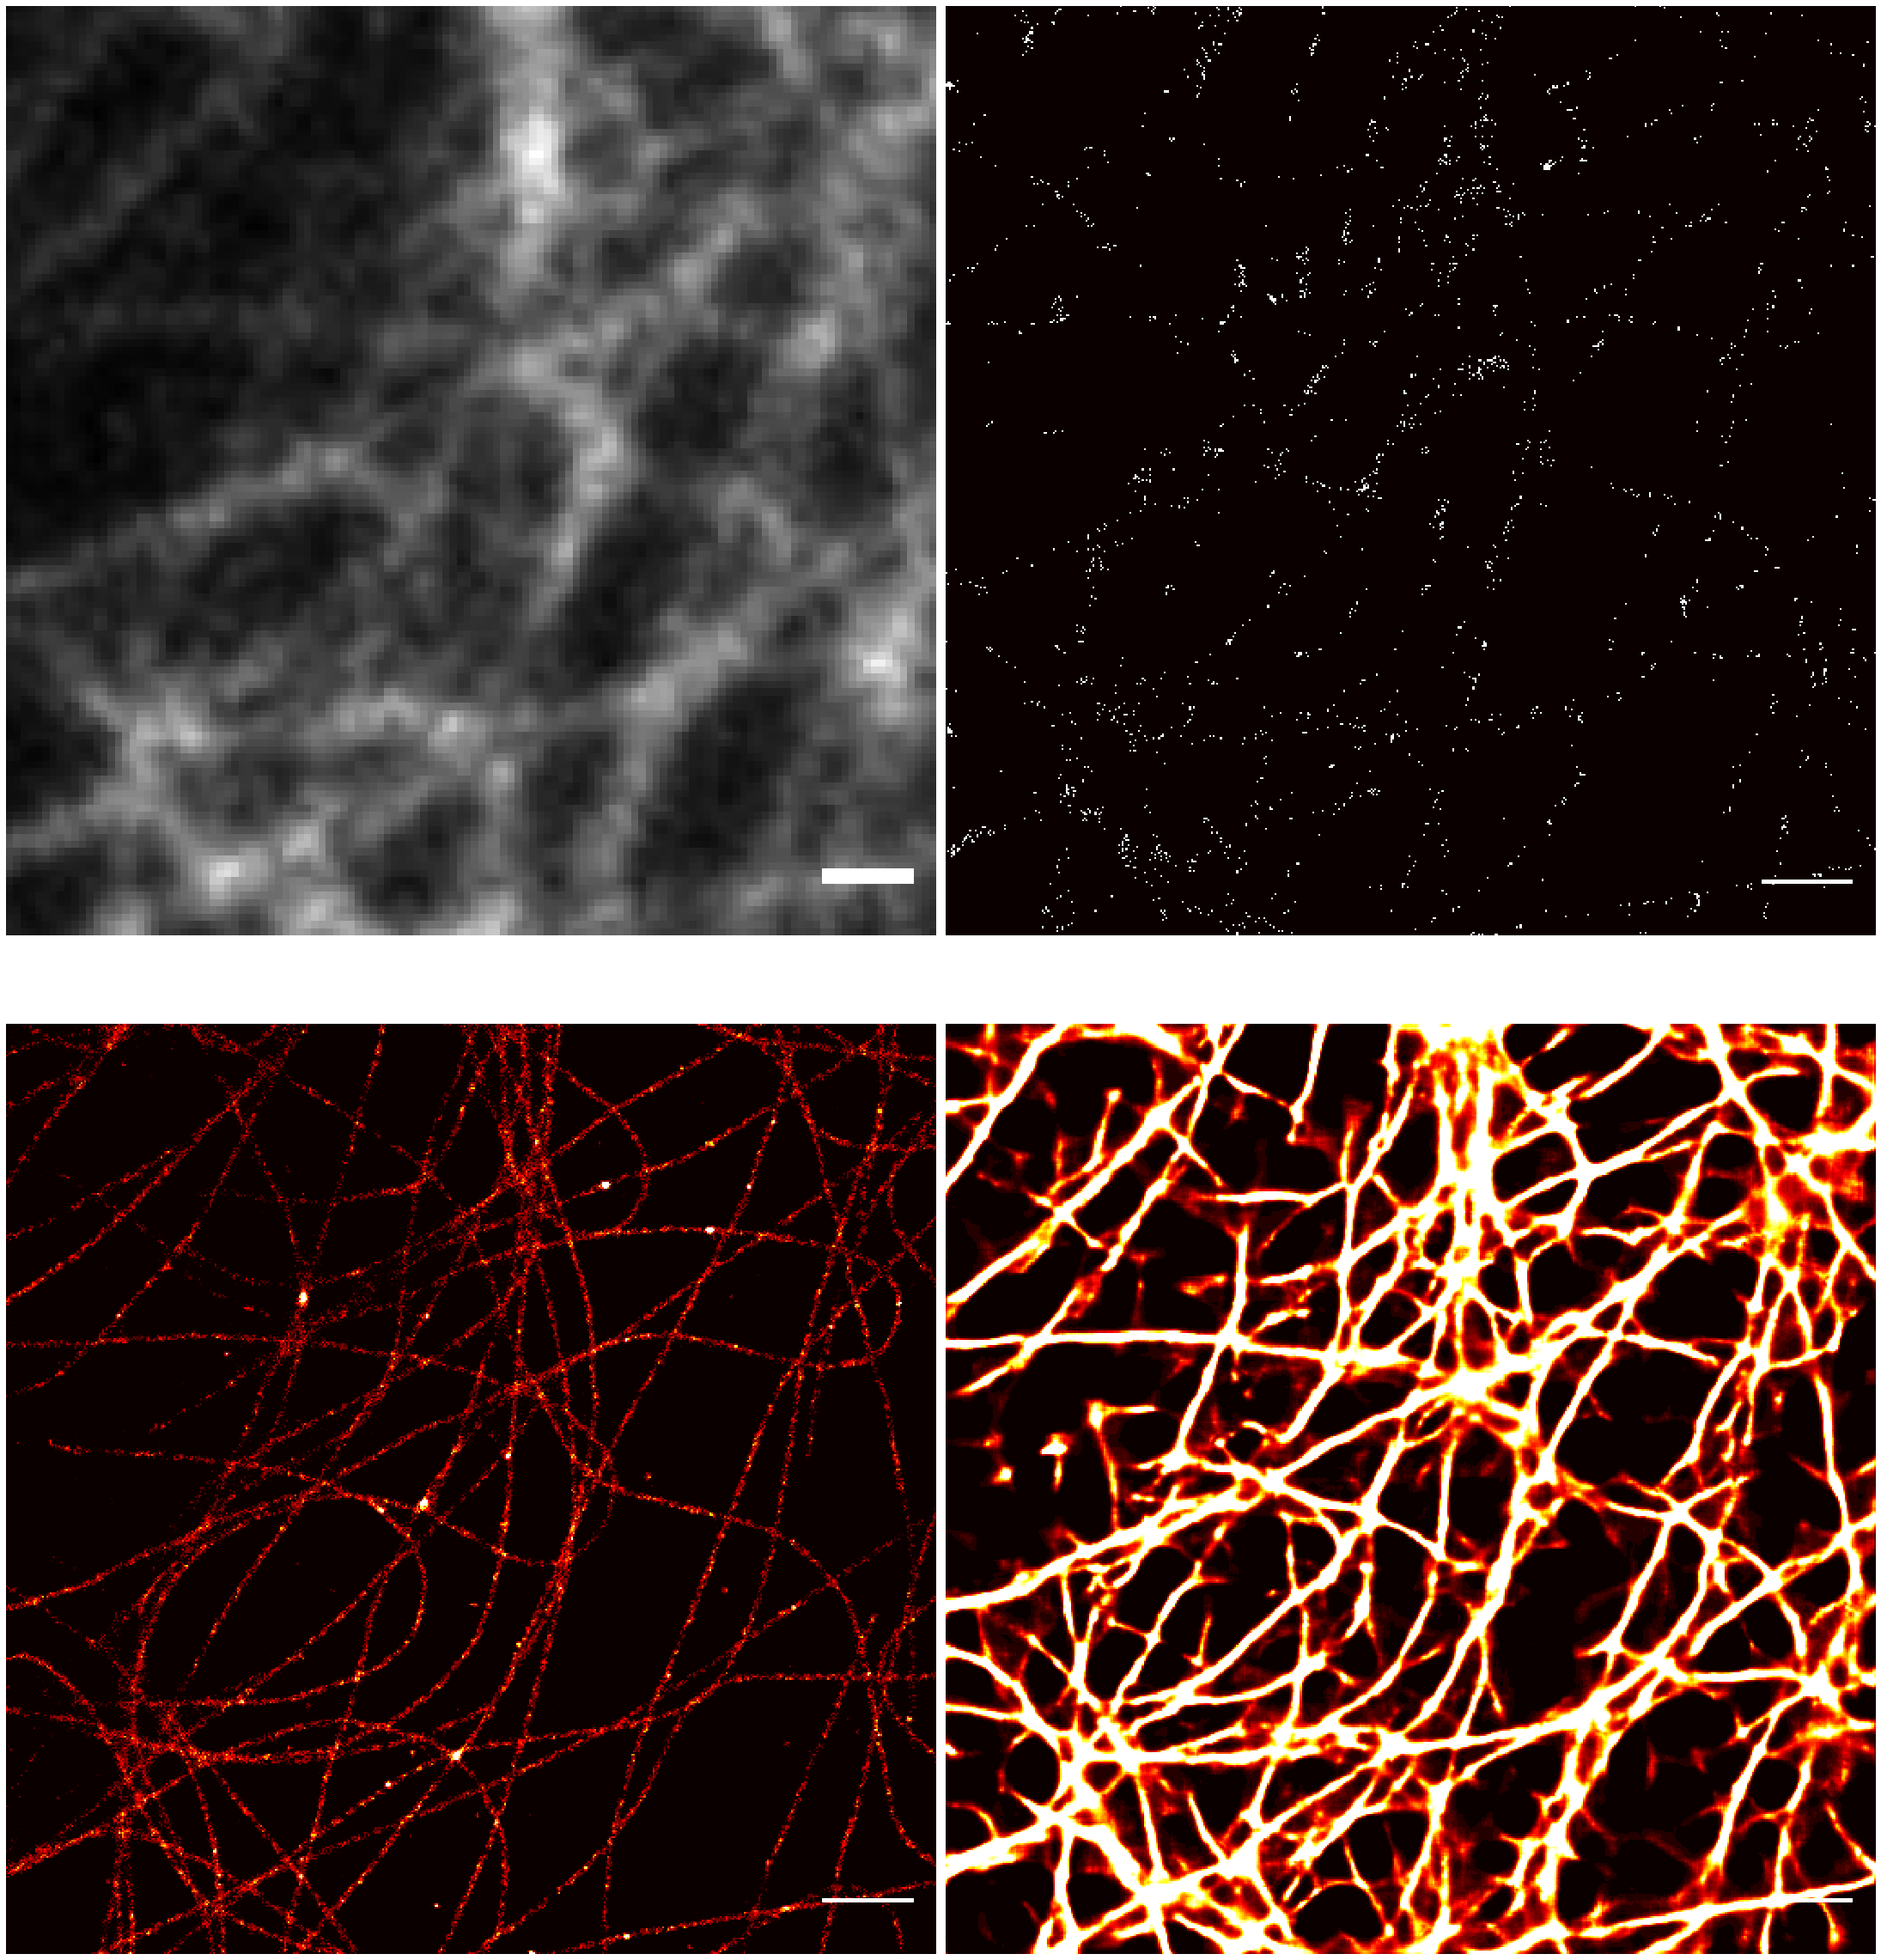

In [655]:
name_ind =  30
crop_cord = (0,0)
zoom_cord = (400,150)
#zoom_cord = (200,120)
#DirBase_c = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/SAUER7_With6WF_seed123/512/outputs/'
#DirBase_c = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/workdir_shareloc_SinWithWF/TrainedOnIMOD_6WF/512/outputs/'
#DirBase_d = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/workdir_shareloc_SinWithWF/TrainedOn3Labs_All/512/outputs/'

DirBase_c = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/GT_Singapour/TrainOn_SIngapoure_all/GT/outputs/'
DirBase_c = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/train_on_imod/test_on_CL/__images__/outputs/'
#DirBase_c = '../../gpulab/shareLoc-Anet/shareLoc-Anet_test/workspace/cross_validation/ssCL/test_on_CL/__images__/outputs/'

outputs_singel_model(DirBase_d= DirBase_c,
                 fact = 30,
                 crop_cord = crop_cord, 
                 zoom_cord=zoom_cord, 
                 zoomsize = 50,
                 chopsize = 512, 
                 FrameNb = 300, 
                 name_ind=name_ind, 
                 add_title = False, 
                 save_fig = False, 
                 show_zoom = False,
                 title_d = 'Merged,trained on 3 abs')

# profile d'intensité

In [45]:
def zoom_line(image, lim, line, c ='y',zoom=3, loc=2, loc1=2, loc2=4, **kwargs):
    # --------
    ax = plt.gca()
    axins = zoomed_inset_axes(ax, zoom, loc=loc) # zoom = 6
    x0,y0,x1,y1 = line
    axins.imshow(image, interpolation="nearest",
          origin="lower", **kwargs)
    plt.plot([x0, x1], [y0, y1], '{}-'.format(c),linewidth=5*zoom,alpha = 1)
    plt.plot([x0, x1], [y0, y1], '{}-'.format(c),linewidth=1*zoom)
    plt.arrow(x0, y0, (x1-x0), (y1-y0), fc='y', ec='y',head_width=zoom)
    # sub region of the original image
    x1, y1, x2, y2 = lim
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.xticks(visible=False)
    plt.yticks(visible=False)

    # draw a bbox of the region of the inset axes in the parent axes and
    # connecting lines between the bbox and the inset axes area
    mark_inset(ax, axins, loc1=loc1, loc2=loc2, fc="none", ec="0.8", lw=2)

In [46]:
def plot_line_profile(line, fact, zoom_rate = 4,fontsize = 20,
                      zoom_lim = (150, 180, 190, 220),
                      add_title=True, save_fig=False, show_zoom=True,
                      name = 'ANNA-PALM_model',title_c = 'Merged,trained on IMOD', 
                      title_d = 'Merged,trained on 4Labs'):
    from skimage.measure import profile_line
    
    print('ploting')
    (wf, histin, gt, Merged_c, Merged_d,Reco_c,Reco_d) = __data['results_images']
    (x0,y0,x1,y1) = line
    font_size = 45
    loc1=4  #4
    loc2=2
    loc=1
    fontsize=45
    widths = [1, 0.25]
    plt.figure(figsize=(10, 35))
    gs = gridspec.GridSpec(4,1,height_ratios=[1,1,1,0.5])
    gs.update(wspace=0.001, hspace=0.005) # set the spacing between axes.
    matplotlib.rc('axes',edgecolor='w',linewidth=3)


    #-------------GT---------------


    vmax_in = 255//fact
    ax1 = plt.subplot(gs[0, 0])
    plt.subplot(gs[0])
    plt.axis('off')
    scalebar(scale_factor=1000/pixel_size)
    plt.imshow(gt,
               origin="lower", cmap='hot', vmin=0, vmax=1)
    plt.plot([x0, x1], [y0, y1], 'y-',linewidth=5,alpha = 0.3)
    plt.arrow(x0, y0, (x1-x0), (y1-y0), fc='y', ec='y',head_width=4)
    if add_title:
        plt.title('a. GT'.format(frame_num), fontsize=fontsize)
    if show_zoom:
        zoom_line(gt,lim=zoom_lim,line=line,
                  zoom=zoom_rate,loc=2,loc1=1,loc2=3,
                  cmap='hot',vmin=0,vmax=1,c='y')
        

    print('b vmax:', vmax_in)


    #-------------RECO trained on 1lab---------------

    #ax2 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[1, 0])

    plt.axis('off')
    #plt.imshow(Merged_c,  interpolation="nearest", origin="lower")
    Reco_c_tmp = Reco_c*(gt.sum())/((Reco_c.sum()))
    plt.imshow(Reco_c, origin="lower", cmap='hot', vmin=0, vmax=1)
    plt.plot([x0, x1], [y0, y1], 'y-',linewidth=5,alpha = 0.3)
    plt.arrow(x0, y0, (x1-x0), (y1-y0), fc='y', ec='y',head_width=4)
    if add_title:
        plt.title('b. {}'.format(title_c), fontsize=fontsize)
    #scalebar()
    scalebar(scale_factor=1000/pixel_size)
    if show_zoom:
        zoom_line(Reco_c,lim=zoom_lim,line = line,
                  zoom = zoom_rate,loc=2,loc1=1,loc2=3,
                  cmap='hot',vmin=0,vmax=1,c='y')
        
    #-------------RECO trained on more labs---------------

    #ax3 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[2, 0])
    
    plt.axis('off')
    #scalebar()
    scalebar(scale_factor=1000/pixel_size)
    #plt.imshow(Merged_d, interpolation="nearest",origin="lower")
    Reco_d_tmp = Reco_d*(gt.sum())/((Reco_d.sum()))
    plt.imshow(Reco_d, origin="lower", cmap='hot', vmin=0, vmax=1)
    plt.plot([x0, x1], [y0, y1], 'y-',linewidth=5,alpha = 0.3)
    plt.arrow(x0, y0, (x1-x0), (y1-y0), fc='y', ec='y',head_width=4)

    if add_title:
        plt.title('c. {}'.format(title_d), fontsize=fontsize)
    if show_zoom:
        zoom_line(Reco_d,lim=zoom_lim,line=line,
                  zoom=zoom_rate,loc=2,loc1=1,loc2=3,
                  cmap='hot',vmin=0,vmax=1,c='y')
        

        
    #-------------line-profiler---------------    
    profile_gt = profile_line(gt,(x0,y0),(x1,y1), linewidth=5)
    profile_c = profile_line(Reco_c,(x0,y0),(x1,y1), linewidth=5)
    profile_d = profile_line(Reco_d,(x0,y0),(x1,y1), linewidth=5)        
    matplotlib.rc('axes',edgecolor='k',linewidth=3)
    #ax4 = plt.subplot(gs[3])
    ax4 = plt.subplot(gs[3,0])
    
    plt.plot(profile_gt,color='green',lw = 2)
    plt.plot(profile_c,color='k',lw = 2)
    plt.plot(profile_d,color='r',lw = 2)

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    #plt.ylim((-0.1,1))
    
    #plt.xlim(np.ceil(np.sqrt((zoom_x0-x0)**2+(zoom_y0-y0)**2)),
    #         np.ceil(np.sqrt((zoom_x0-x0+zoomsize)**2+(zoom_y0-y0+zoomsize)**2)))
    plt.legend(("Ground truth","Model 1","Model 5"),
               loc = "upper right",fontsize=fontsize,
               bbox_to_anchor=(-0.9, 1)
              )
    plt.axis('on')
    plt.setp(ax4.spines.values(), linewidth=3)
    ax4.xaxis.set_tick_params(width=3)
    ax4.yaxis.set_tick_params(width=3)

    if add_title:
        plt.title('d. {}'.format(title_d), fontsize=fontsize)

    if save_fig:
        if not os.path.exists('./figs_out/'):
            os.makedirs('./figs_out/')
        # model_no = os.path.split(MODEL_DIR)[1].split('-')[0]
        # model_no = MODEL_DIR[18:-10]
        plt.savefig('./figs_out/{}frames_{}_{}.svg'.format(int(frame_num), name, zoom_lim),
                    transparent=True)
        # plt.clf()

ploting
b vmax: 1


/home/jiachuan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


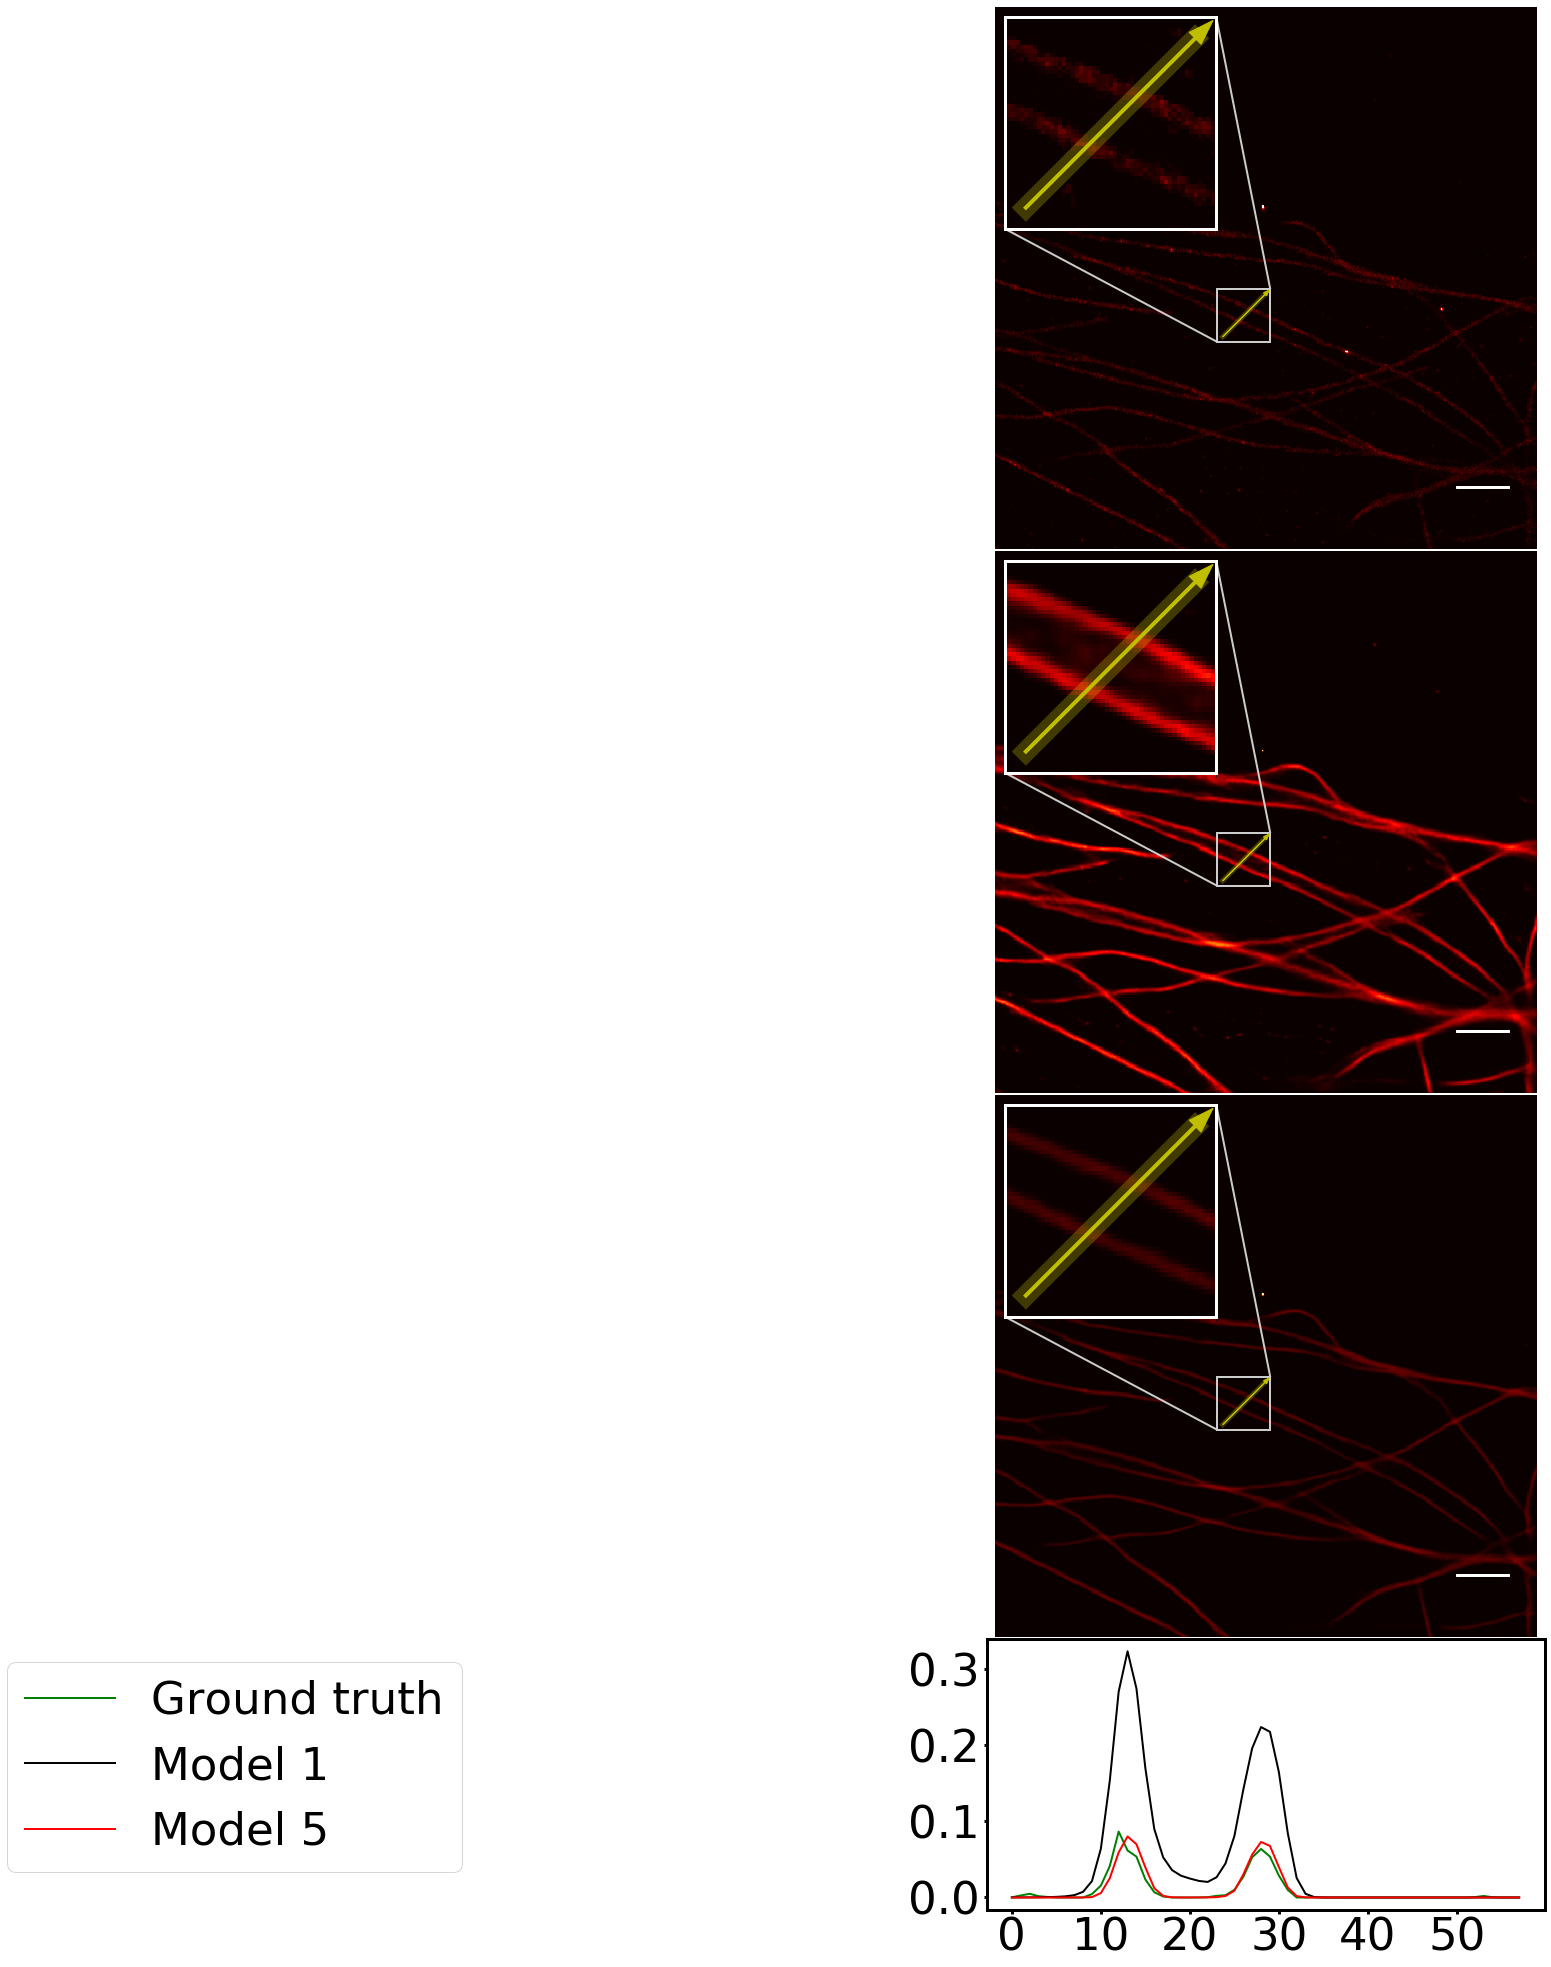

In [988]:
x0 = 210+5#60
y0 = 195+5#20
x1 = 210-5+zoomsize#350
y1 = 195-5+zoomsize#350
line = (x0,y0,x1,y1)
zoom_x0,zoom_y0=(210,195)
zoom_lim = (zoom_x0,zoom_y0,zoom_x0+zoomsize,zoom_y0+zoomsize)
plot_line_profile(line, 255, zoom_rate = 4, fontsize = 40,
                  zoom_lim = zoom_lim,
                  add_title=False, save_fig=False, show_zoom=True,
                  name = 'ANNA-PALM_model',title_c = 'Merged,trained on IMOD', 
                  title_d = 'Merged,trained on 4Labs')

In [2]:
from skimage import io
import matplotlib.pyplot as plt
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray
img = io.imread('/home/jiachuan/Téléchargements/1968 - Boris EPHRUSSI (génétique) © CNRS Photothèque (1).jpg')

/home/jiachuan/miniconda3/envs/shareloc/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


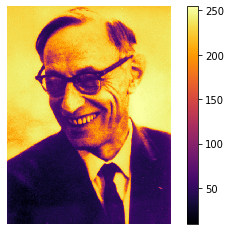

In [3]:
plt.imshow(rgb2gray(img), "inferno")
plt.axis('off')
plt.colorbar()

(600, 450, 3)